# From Chain Ladder to Individual Mixture Density Networks on SPLICE Data
-----

The goal of this notebook is to start with a Chain Ladder model but progressively expand it into an deep learning individual claim model while still having sensible results. Additionally, there is a benchmark against a GBM model as well.

The notebook is long but structured into sections as follows:

 * **Data**: Read in SPLICE data (including case estimates) and create additional fields, test and train datasets,
 * **Chain ladder**: Directly calculate Chain Ladder factors as a baseline,
 * **Chain ladder (GLM)** Recreate Chain Ladder results, with a GLM formulation,
 * **Individual GLM** Convert the GLM into a very basic individual claims model,
 * **Individual GLM with splines** Replace the overparametrized one-hot encoding with splines,
 * **Residual network** Consider a ResNet,
 * **Spline-based individual network**: Create a customised neural network architecture with similar behaviour to the individual GLM with splines,
 * **Spline-based Individual Log-normal Mixture Density Network**: Introduce a MDN-based network, with modifications to accommodate a log-normal distribution,
 * **Rolling origin cross-validation and parameter search**,
 * **Additional data augmentation** for training individual claim features,
 * **Detailed individual models** using claim features, including a hyperparameter tuned GBM as a benchmark,
 * **Review and summary**.

In [1]:
dataset_no = 1     # Re-run this for datasets 1-5 to see how it performs
cutoff     = 40    # 40 is the (hard-coded) cut-off as set out previously
cv_runs    = 1     # Testing only: 4, proper runs of the models: 24
glm_iter   = 500   # 500 epochs for gradient descent fitting of GLMs is very quick
nn_iter    = 500   # 100 for experimentation, 500 appears to give models that have fully converged or are close to convergence. 
nn_cv_iter = 100   # Lower for CV to save running time
mdn_iter   = 500   # Latest architecture and loss converges fairly quickly

In [2]:
pip show pandas numpy scikit-learn torch matplotlib

Name: pandas
Version: 2.3.2
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License

 Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
 All rights reserved.

 Copyright (c) 2011-2023, Open source contributors.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:

 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

 * Neither the name of the copyright holder nor the names of its
   contribut

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# from torch.utils.data.sampler import BatchSampler, RandomSampler
# from torch.utils.data import DataLoader

import torch
import torch.nn as nn
from torch.nn import functional as F

from torch.autograd import Variable

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, SplineTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error

from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit
# from skopt import BayesSearchCV
import math

In [4]:
pd.options.display.float_format = '{:,.2f}'.format

## Scikit Module
----

This has been used in past experiments so it is basically my boilerplate code. With minor tweaks. 

In [5]:
class TabularNetRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self, 
        module,
        criterion=nn.PoissonNLLLoss,
        max_iter=100,   
        max_lr=0.01,
        keep_best_model=False,
        batch_function=None,
        rebatch_every_iter=1,
        n_hidden=20,                  
        l1_penalty=0.0,          # lambda is a reserved word
        l1_applies_params=["linear.weight", "hidden.weight"],
        weight_decay=0.0,
        batch_norm=False,
        interactions=True,
        dropout=0.0,
        clip_value=None,
        n_gaussians=3,
        verbose=1,                
        device="cpu" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"),  # Use GPU if available, leave mps off until more stable
        init_extra=None,
        **kwargs
    ):
        """ Tabular Neural Network Regressor (for Claims Reserving)

        This trains a neural network with specified loss, Log Link and l1 LASSO penalties
        using Pytorch. It has early stopping.

        Args:
            module: pytorch nn.Module. Should have n_input and n_output as parameters and
                if l1_penalty, init_weight, or init_bias are used, a final layer 
                called "linear".

            criterion: pytorch loss function. Consider nn.PoissonNLLLoss for log link.

            max_iter (int): Maximum number of epochs before training stops. 
                Previously this used a high value for triangles since the record count is so small.
                For larger regression problems, a lower number of iterations may be sufficient.

            max_lr (float): Min / Max learning rate - we will use one_cycle_lr

            keep_best_model (bool): If true, keep and use the model weights with the best loss rather 
                than the final weights.

            batch_function (None or fn): If not None, used to get a batch from X and y

            rebatch_every_iter (int): redo batches every

            l1_penalty (float): l1 penalty factor. If not zero, is applied to 
                the layers in the Module with names matching l1_applies_params.

                (we use l1_penalty because lambda is a reserved word in Python 
                for anonymous functions)

            weight_decay (float): weight decay - analogous to l2 penalty factor
                Applied to all weights

            clip_value (None or float): clip gradient norms at a particular value
            
            n_hidden (int), batch_norm(bool), dropout (float), interactions(bool), n_gaussians(int): 
                Passed to module. Hidden layer size, batch normalisation, dropout percentages, and interactions flag.

            init_extra (coerces to torch.Tensor): set init_bias, passed to module. If none, default to np.log(y.mean()).values.astype(np.float32)

            verbose (int): 0 means don't print. 1 means do print.
        """
        self.module = module
        self.criterion = criterion
        self.keep_best_model = keep_best_model
        self.l1_penalty = l1_penalty
        self.l1_applies_params = l1_applies_params
        self.weight_decay = weight_decay
        self.max_iter = max_iter
        self.n_hidden = n_hidden
        self.batch_norm = batch_norm
        self.batch_function = batch_function
        self.rebatch_every_iter = rebatch_every_iter
        self.interactions = interactions
        self.dropout = dropout
        self.n_gaussians = n_gaussians
        self.device = device
        self.target_device = torch.device(device)    
        self.max_lr = max_lr
        self.init_extra = init_extra
        self.print_loss_every_iter = max(1, int(max_iter / 10))
        self.verbose = verbose
        self.clip_value = clip_value
        self.kwargs = kwargs

        
    def fix_array(self, y):
        "Need to be picky about array formats"
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y = y.values
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        y = y.astype(np.float32)
        return y
        

    def setup_module(self, n_input, n_output):
         
        # Training new model
        self.module_ = self.module(
            n_input=n_input, 
            n_output=n_output,
            n_hidden=self.n_hidden,
            batch_norm=self.batch_norm,
            dropout=self.dropout,
            interactions_trainable=self.interactions,
            n_gaussians=self.n_gaussians,
            init_bias=self.init_bias_calc,
            init_extra=self.init_extra,
            **self.kwargs
        ).to(self.target_device)
        

    def fit(self, X, y):
        # The main fit logic is in partial_fit
        # We will try a few times if numbers explode because NN's are finicky and we are doing CV
        n_input = X.shape[-1]
        n_output = 1 if y.ndim == 1 else y.shape[-1]
        self.init_bias_calc = np.log(y.mean()).values.astype(np.float32)
        self.setup_module(n_input=n_input, n_output=n_output)

        # Partial fit means you take an existing model and keep training 
        # so the logic is basically the same
        self.partial_fit(X, y)

        return self


    def partial_fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y, multi_output=True)

        # Convert to Pytorch Tensor
        X_tensor = torch.from_numpy(self.fix_array(X)).to(self.target_device)
        y_tensor = torch.from_numpy(self.fix_array(y)).to(self.target_device)

        # Optimizer - the generically useful AdamW. Other options like SGD
        # are also possible.
        optimizer = torch.optim.AdamW(
            params=self.module_.parameters(),
            lr=self.max_lr / 10,
            weight_decay=self.weight_decay
        )
        
        # Scheduler - one cycle LR
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, 
            max_lr=self.max_lr, 
            steps_per_epoch=1, 
            epochs=self.max_iter
        )

        # Loss Function
        try:
            loss_fn = self.criterion(log_input=False).to(self.target_device)  # Pytorch loss function
        except TypeError:
            loss_fn = self.criterion  # Custom loss function

        best_loss = float('inf') # set to infinity initially

        if self.batch_function is not None:
            X_tensor_batch, y_tensor_batch = self.batch_function(X_tensor, y_tensor)
        else:
            X_tensor_batch, y_tensor_batch = X_tensor, y_tensor

        # Training loop
        for epoch in range(self.max_iter):   # Repeat max_iter times

            self.module_.train()
            y_pred = self.module_(X_tensor_batch)  #  Apply current model

            loss = loss_fn(y_pred, y_tensor_batch) #  What is the loss on it?
            if self.l1_penalty > 0.0:        #  Lasso penalty
                loss += self.l1_penalty * sum(
                    [
                        w.abs().sum()
                        for p, w in self.module_.named_parameters()
                        if p in self.l1_applies_params
                    ]
                )

            if self.keep_best_model & (loss.item() < best_loss):
                best_loss = loss.item()
                self.best_model = self.module_.state_dict()

            optimizer.zero_grad()            #  Reset optimizer
            loss.backward()                  #  Apply back propagation

            # gradient norm clipping
            if self.clip_value is not None:
                grad_norm = torch.nn.utils.clip_grad_norm_(self.module_.parameters(), self.clip_value)
                # check if gradients have been clipped
                if (self.verbose >= 2) & (grad_norm > self.clip_value):
                    print(f'Gradient norms have been clipped in epoch {epoch}, value before clipping: {grad_norm}')    

            optimizer.step()                 #  Update model parameters
            scheduler.step()

            if torch.isnan(loss.data).tolist():
                raise ValueError('Error: nan loss')


            # Every self.print_loss_every_iter steps, print RMSE 
            if (epoch % self.print_loss_every_iter == 0) and (self.verbose > 0):
                self.module_.eval()                     # Eval mode 
                self.module_.point_estimates=True       # Distributional models - set to point                
                y_pred_point = self.module_(X_tensor)   # Get "real" model estimates
                assert(y_pred_point.size() == y_tensor.size())
                rmse = torch.sqrt(torch.mean(torch.square(y_pred_point - y_tensor)))
                self.module_.train()                     # back to training
                self.module_.point_estimates=False       # Distributional models - set to point
                
                print("Train RMSE: ", rmse.data.tolist(), " Train Loss: ", loss.data.tolist())

            if (self.batch_function is not None) & (epoch % self.rebatch_every_iter == 0):
                print(f"refreshing batch on epoch {epoch}")
                X_tensor_batch, y_tensor_batch = self.batch_function(X_tensor, y_tensor)
        
        if self.keep_best_model:
            self.module_.load_state_dict(self.best_model)
            self.module_.eval()

        # Return the regressor
        return self


    def predict(self, X, point_estimates=True):
        # Checks
        check_is_fitted(self)      # Check is fit had been called
        X = check_array(X)         # Check input

        # Convert to Pytorch Tensor
        X_tensor = torch.from_numpy(self.fix_array(X)).to(self.target_device)
      
        self.module_.eval()  # Eval (prediction) mode
        self.module_.point_estimates = point_estimates

        # Apply current model and convert back to numpy
        if point_estimates:
            y_pred = self.module_(X_tensor).cpu().detach().numpy()
            if y_pred.shape[-1] == 1: 
                return y_pred.ravel()
            else:
                return y_pred
        else:
            y_pred = self.module_(X_tensor)
            return y_pred


    def score(self, X, y):
        # Negative RMSE score (higher needs to be better)
        y_pred = self.predict(X)
        y = self.fix_array(y)
        return -np.sqrt(np.mean((y_pred - y)**2))

In [6]:
class ColumnKeeper(BaseEstimator, TransformerMixin):
    """Keeps named cols, preserves DataFrame output"""
    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y):
        return self

    def transform(self, X):
        return X.copy()[self.cols]

## Data
-----
Convert to a time series with one record per time period (even if multiple or no claims transactions). 
Follows my earlier gist here: https://gist.github.com/JackyP/ae6a9fefdb3f0a1aeaf2fb6a1a5ea824 but rewritten in pure pandas (shorter, less dependencies, but probably less readable so refer to gist for the concepts)

In [7]:
paid = pd.read_csv(f"https://raw.githubusercontent.com/agi-lab/SPLICE/main/datasets/complexity_{dataset_no}/payment_{dataset_no}.csv")
incurred = pd.read_csv(f"https://raw.githubusercontent.com/agi-lab/SPLICE/main/datasets/complexity_{dataset_no}/incurred_{dataset_no}.csv")

# Recreate some of the columns from paid into the incurred set
incurred.loc[:, "trn_no"] = incurred.groupby("claim_no").cumcount() + 1
incurred.loc[incurred.txn_type.str.contains("P"), "pmt_no"] = incurred.loc[incurred.txn_type.str.contains("P")].groupby("claim_no").cumcount() + 1
incurred["payment_period"] = np.ceil(incurred.txn_time).astype("int")
incurred["payment_size"] = incurred.groupby("claim_no").cumpaid.diff()
incurred["payment_size"] = incurred["payment_size"].fillna(incurred["cumpaid"])
incurred["incurred_incremental"] = incurred.groupby("claim_no").incurred.diff()
incurred["incurred_incremental"] = incurred["incurred_incremental"].fillna(incurred["incurred"])
transactions = incurred.merge(
    paid[["claim_no", "occurrence_period", "occurrence_time", "notidel", "setldel"]].drop_duplicates(),
    on="claim_no",
)
transactions["noti_period"] = np.ceil(transactions["occurrence_time"] + transactions["notidel"]).astype('int')
transactions["settle_period"] = np.ceil(transactions["occurrence_time"] + transactions["notidel"] + transactions["setldel"]).astype('int')

# Apply cut-off since some of the logic in this notebook assumes an equal set of dimensions
transactions["development_period"] = np.minimum(transactions["payment_period"] - transactions["occurrence_period"], cutoff)  
num_dev_periods = cutoff - 1  # (transactions["payment_period"] - transactions["occurrence_period"]).max()
transactions.head()

Unnamed: 0  claim_no  claim_size  txn_time  txn_delay txn_type   incurred  \
0           1         1  232,310.09      1.39       0.00       Ma  29,130.80   
1           2         1  232,310.09      5.33       3.93        P  29,130.80   
2           3         1  232,310.09     10.09       8.70      PMi  30,433.89   
3           4         1  232,310.09     10.26       8.87       Ma 128,234.75   
4           5         1  232,310.09     10.39       9.00       Ma 302,860.24   

         OCL   cumpaid  multiplier  ...  payment_period  payment_size  \
0  29,130.80      0.00        1.00  ...               2          0.00   
1  15,904.46 13,226.34         NaN  ...               6     13,226.34   
2   1,521.69 28,912.20        1.08  ...              11     15,685.86   
3  99,322.55 28,912.20        7.75  ...              11          0.00   
4 273,948.04 28,912.20        2.36  ...              11          0.00   

   incurred_incremental  occurrence_period  occurrence_time  notidel  setldel  \
0             29,130.80                  1             0.73     0.66    23.21   
1                  0.00                  1             0.73     0.66    23.21   
2              1,303.10                  1             0.73     0.66    23.21   
3             97,800.86                  1             0.73     0.66    23.21   
4            174,625.49                  1             0.73     0.66    23.21   

   noti_period  settle_period  development_period  
0            2             25                   1  
1            2             25                   5  
2            2             25                  10  
3            2             25                  10  
4            2             25                  10  

[5 rows x 22 columns]

In [8]:
# Transactions summarised by claim/dev:
transactions_group = (transactions
        .groupby(["claim_no", "development_period"], as_index=False)
        .agg({"payment_size": "sum", "incurred_incremental": "sum", "pmt_no": "max", "trn_no": "max"})
        .sort_values(by=["claim_no", "development_period"])
)

# This is varied from the original version:
range_payment_delay = pd.DataFrame.from_dict({"development_period": range(0, num_dev_periods + 1)})

# Claims header + development periods
claim_head_expand_dev = (
    transactions
    .loc[:, ["claim_no", "occurrence_period", "occurrence_time", "noti_period", "notidel", "settle_period"]]
    .drop_duplicates()
).merge(
    range_payment_delay,
    how="cross"
).assign(
    payment_period=lambda df: (df.occurrence_period + df.development_period),
    is_settled=lambda df: (df.occurrence_period + df.development_period) >= df.settle_period
)

# create the dataset
dat = claim_head_expand_dev.merge(
    transactions_group,
    how="left",
    on=["claim_no", "development_period"],
).fillna(0)

# Only periods after notification
dat = dat.loc[dat.payment_period >= dat.noti_period]

# Clean close to zero values
dat["payment_size"] = np.where(abs(dat.payment_size) < 1e-2, 0.0, dat.payment_size)

# Cumulative payments
dat["payment_size_cumulative"] = dat[["claim_no", "payment_size"]].groupby('claim_no').cumsum()
dat["incurred_cumulative"] = dat[["claim_no", "incurred_incremental"]].groupby('claim_no').cumsum()
dat["outstanding_claims"] = dat["incurred_cumulative"] - dat["payment_size_cumulative"]
dat["outstanding_claims"] = np.where(abs(dat.outstanding_claims) < 1e-2, 0.0, dat.outstanding_claims)

dat["payment_to_prior_period"] = dat["payment_size_cumulative"] - dat["payment_size"]
dat["has_payment_to_prior_period"] = np.where(dat.payment_to_prior_period > 1e-2, 1, 0)
dat["log1_payment_to_prior_period"] = np.log1p(dat.payment_to_prior_period)

dat["incurred_to_prior_period"] = dat["incurred_cumulative"] - dat["incurred_incremental"]
dat["has_incurred_to_prior_period"] = np.where(dat.incurred_to_prior_period > 1e-2, 1, 0)
dat["log1_incurred_to_prior_period"] = np.log1p(dat.incurred_to_prior_period)

dat["outstanding_to_prior_period"] = dat["incurred_to_prior_period"] - dat["payment_to_prior_period"]
dat["outstanding_to_prior_period"] = np.where(abs(dat.outstanding_to_prior_period) < 1e-2, 0.0, dat.outstanding_to_prior_period)

dat["log1_outstanding_to_prior_period"] = np.log1p(dat.outstanding_to_prior_period)
dat["has_outstanding_to_prior_period"] = np.where(dat.outstanding_to_prior_period > 1e-2, 1, 0)

dat["pmt_no"] = dat.groupby("claim_no")["pmt_no"].cummax()
dat["trn_no"] = dat.groupby("claim_no")["trn_no"].cummax()
dat["payment_count_to_prior_period"] = dat.groupby("claim_no")["pmt_no"].shift(1).fillna(0)
dat["transaction_count_to_prior_period"] = dat.groupby("claim_no")["trn_no"].shift(1).fillna(0)

dat["data_as_at_development_period"] = dat.development_period  # See data augmentation section
dat["backdate_periods"] = 0
dat["payment_period_as_at"] = dat.payment_period

# Potential features for model later:
data_cols = [
    "notidel", 
    "occurrence_time", 
    "development_period", 
    "payment_period", 
    "has_payment_to_prior_period",
    "log1_payment_to_prior_period",
    "has_incurred_to_prior_period",
    "log1_incurred_to_prior_period",
    "has_outstanding_to_prior_period",
    "log1_outstanding_to_prior_period",
    "payment_count_to_prior_period",
    "transaction_count_to_prior_period"]

# The notebook is created on an MacBook Pro M1, which supports GPU mode in float32 only.
dat[dat.select_dtypes(np.float64).columns] = dat.select_dtypes(np.float64).astype(np.float32)

dat["train_ind"] = (dat.payment_period <= cutoff)
dat["cv_ind"] = dat.payment_period % 5  # Cross validate on this column
dat

claim_no  occurrence_period  occurrence_time  noti_period  notidel  \
1              1                  1             0.73            2     0.66   
2              1                  1             0.73            2     0.66   
3              1                  1             0.73            2     0.66   
4              1                  1             0.73            2     0.66   
5              1                  1             0.73            2     0.66   
...          ...                ...              ...          ...      ...   
146515      3663                 40            39.87           43     2.29   
146516      3663                 40            39.87           43     2.29   
146517      3663                 40            39.87           43     2.29   
146518      3663                 40            39.87           43     2.29   
146519      3663                 40            39.87           43     2.29   

        settle_period  development_period  payment_period  is_settled  \
1                  25                   1               2       False   
2                  25                   2               3       False   
3                  25                   3               4       False   
4                  25                   4               5       False   
5                  25                   5               6       False   
...               ...                 ...             ...         ...   
146515             53                  35              75        True   
146516             53                  36              76        True   
146517             53                  37              77        True   
146518             53                  38              78        True   
146519             53                  39              79        True   

        payment_size  ...  outstanding_to_prior_period  \
1               0.00  ...                         0.00   
2               0.00  ...                    29,130.80   
3               0.00  ...                    29,130.80   
4               0.00  ...                    29,130.80   
5          13,226.34  ...                    29,130.80   
...              ...  ...                          ...   
146515          0.00  ...                         0.00   
146516          0.00  ...                         0.00   
146517          0.00  ...                         0.00   
146518          0.00  ...                         0.00   
146519          0.00  ...                         0.00   

        log1_outstanding_to_prior_period  has_outstanding_to_prior_period  \
1                                   0.00                                0   
2                                  10.28                                1   
3                                  10.28                                1   
4                                  10.28                                1   
5                                  10.28                                1   
...                                  ...                              ...   
146515                              0.00                                0   
146516                              0.00                                0   
146517                              0.00                                0   
146518                              0.00                                0   
146519                              0.00                                0   

        payment_count_to_prior_period  transaction_count_to_prior_period  \
1                                0.00                               0.00   
2                                0.00                               1.00   
3                                0.00                               1.00   
4                                0.00                               1.00   
5                                0.00                               1.00   
...                               ...                                ...   
146515                           6.00   

In [9]:
dat.head(10)

claim_no  occurrence_period  occurrence_time  noti_period  notidel  \
1          1                  1             0.73            2     0.66   
2          1                  1             0.73            2     0.66   
3          1                  1             0.73            2     0.66   
4          1                  1             0.73            2     0.66   
5          1                  1             0.73            2     0.66   
6          1                  1             0.73            2     0.66   
7          1                  1             0.73            2     0.66   
8          1                  1             0.73            2     0.66   
9          1                  1             0.73            2     0.66   
10         1                  1             0.73            2     0.66   

    settle_period  development_period  payment_period  is_settled  \
1              25                   1               2       False   
2              25                   2               3       False   
3              25                   3               4       False   
4              25                   4               5       False   
5              25                   5               6       False   
6              25                   6               7       False   
7              25                   7               8       False   
8              25                   8               9       False   
9              25                   9              10       False   
10             25                  10              11       False   

    payment_size  ...  outstanding_to_prior_period  \
1           0.00  ...                         0.00   
2           0.00  ...                    29,130.80   
3           0.00  ...                    29,130.80   
4           0.00  ...                    29,130.80   
5      13,226.34  ...                    29,130.80   
6           0.00  ...                    15,904.46   
7           0.00  ...                    15,904.46   
8           0.00  ...                    15,904.46   
9           0.00  ...                    15,904.46   
10     15,685.86  ...                    15,904.46   

    log1_outstanding_to_prior_period  has_outstanding_to_prior_period  \
1                               0.00                                0   
2                              10.28                                1   
3                              10.28                                1   
4                              10.28                                1   
5                              10.28                                1   
6                               9.67                                1   
7                               9.67                                1   
8                               9.67                                1   
9                               9.67                                1   
10                              9.67                                1   

    payment_count_to_prior_period  transaction_count_to_prior_period  \
1                            0.00                               0.00   
2                            0.00                               1.00   
3                            0.00                               1.00   
4                            0.00                               1.00   
5                            0.00                               1.00   
6                            1.00                               2.00   
7                            1.00                               2.00   
8                            1.00                               2.00   
9                            1.00                               2.00   
10                           1.00                               2.00   

    data_as_at_development_period  backdate_periods  payment_period_as_at  \
1                               1                 0                     2   
2                               2                 0                     3   
3     

Train test split is set up by payment period - past vs future.

There is a caveat for an unrealistic assumption - there is one record per claim even if it is reported "in the future" past the cutoff.

This affects the model training and it does mean when looking at aggregate prediction data that the model knows what the ultimate count is.

However, normally when we are building individual claim models they are used to predict expected costs of known claims so this is not a huge issue.

## Chain Ladder, Direct Calculation, Aggregated Data
-----
Chain ladder calculation, from first principles. Based on 
https://actuariesinstitute.github.io/cookbook/docs/SQL%20Query%20for%20Triangles.html

In [10]:
triangle = (dat
    .groupby(["occurrence_period", "development_period", "payment_period"], as_index=False)
    .agg({"payment_size_cumulative": "sum", "payment_size": "sum"})
    .sort_values(by=["occurrence_period", "development_period"])
)
triangle_train = triangle.loc[triangle.payment_period <= cutoff]
triangle_test = triangle.loc[triangle.payment_period > cutoff]

triangle_train.pivot(index = "occurrence_period", columns = "development_period", values = "payment_size_cumulative")


development_period        0          1          2            3            4   \
occurrence_period                                                              
1                   1,439.79  33,964.12 178,514.47   343,170.28   630,618.06   
2                       0.00  39,101.35 116,772.10   239,416.23   472,654.28   
3                       0.00  27,682.06 196,798.86   396,755.97   522,254.56   
4                   4,340.67  36,499.27 161,562.59   293,577.41   547,973.75   
5                       0.00  35,032.82 146,433.42   290,105.00   486,530.09   
6                   1,773.62  40,529.51 163,240.39   376,696.69   612,710.69   
7                   1,677.26  39,523.20 129,868.84   227,166.45   540,881.31   
8                     904.43  30,041.22 171,799.48   419,135.62   773,168.94   
9                     271.28  20,946.97 115,077.40   268,745.34   416,010.34   
10                      0.00  30,596.70 196,910.97   443,027.31   782,419.31   
11                  6,632.53  66,972.10 207,548.14   462,256.03   793,185.62   
12                  1,431.22  67,051.78 156,599.80   270,577.44   649,722.75   
13                  2,029.26  17,454.87 180,379.50   341,824.38   595,547.50   
14                  2,853.19  93,844.98 295,558.84   556,663.06   910,465.19   
15                  3,685.83  28,948.63 146,381.06   321,382.22   521,733.19   
16                      0.00  81,474.84 228,731.06   588,765.94   910,906.94   
17                      0.00  66,420.51 197,170.69   484,344.44   838,551.19   
18                      0.00  53,138.43 123,639.84   298,696.44   535,833.19   
19                      0.00  34,086.87 204,900.75   400,163.12   600,445.25   
20                      0.00  42,283.17 175,072.05   414,349.50   840,670.56   
21                      0.00  25,207.58 169,402.56   347,866.72   743,656.50   
22                      0.00  36,790.93 181,476.38   445,429.81   700,554.06   
23                 22,106.89 116,623.65 345,401.34 1,121,187.00 1,320,994.88   
24                  4,465.26  55,838.54 181,278.97   386,256.72   606,791.31   
25                  4,367.87  25,870.57  94,031.31   228,997.44   386,928.69   
26                      0.00  79,592.89 226,306.89   360,370.25   561,948.44   
27                      0.00  20,480.35 134,592.89   339,774.44   515,044.47   
28                      0.00  54,087.19 269,660.25   583,219.50   907,550.56   
29                  6,292.51  82,104.09 263,787.59   541,113.62   939,427.50   
30                      0.00  33,078.70 151,494.28   346,339.56   770,497.19   
31                      0.00  22,283.46 130,078.08   301,486.53   563,131.88   
32                      0.00  32,882.53 134,910.67   278,651.28   529,224.88   
33                      0.00  24,749.48 164,366.52   319,528.59   590,100.50   
34                      0.00  19,428.75 138,058.89   310,083.97   488,873.59   
35                      0.00  31,437.90 139,078.39   369,741.56   646,867.75   
36                  4,233.76  52,775.73 176,901.16   319,410.47   565,794.56   
37                     26.03  46,980.28 233,096.56   428,300.34          NaN   
38                  3,142.33  23,035.35 138,052.53          NaN          NaN   
39                      0.00  54,288.11        NaN          NaN          NaN   
40                      0.00        NaN        NaN          NaN          NaN   

development_period           5            6            7            8   \
occurrence_period                                                        
1                  1,018,364.31 1,352,422.88 1,635,850.25 1,882,757.25   
2                    729,413.31   979,287.81 1,272,592.00 1,606,688.50   
3                    875,562.62 1,314,355.62 1,966,982.88 2,339,964.25   
4                    863,551.50 1,134,608.12 1,360,245.00 2,322,095.75   
5                    769,324.75 1,033,624.06 1,469,111.75 2,022,809.38   
6                    925,434.62 1,361,709.38 1,597,676.38 2,122,347.25   
7                    729,756.94 1,051,510.38 1,

Text(0.5, 1.0, 'Training Set, Cumulative Claims by Development Period, Log Scale')

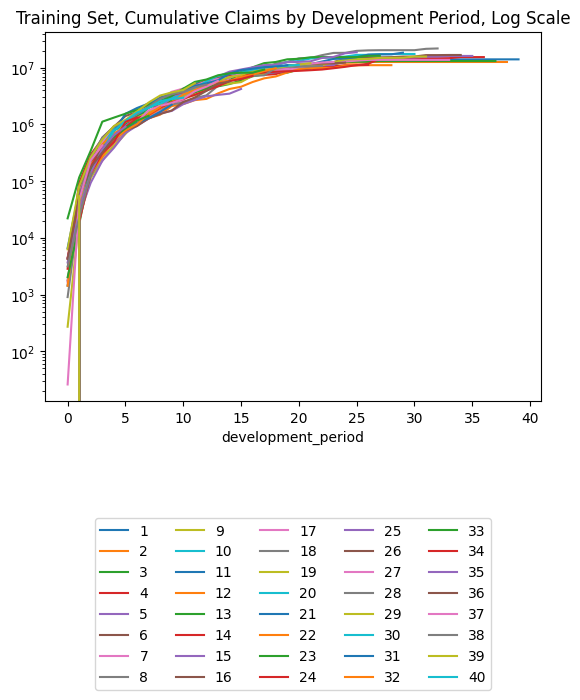

In [11]:
(triangle_train
    .pivot(index = "development_period", columns = "occurrence_period", values = "payment_size_cumulative")
    .plot(logy=True)
)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.8), ncol=5)
plt.title("Training Set, Cumulative Claims by Development Period, Log Scale")

In [12]:
### Get the diagonals in the cumulative IBNR triangle, which represents cumulative payments for a particular
### occurrence period
triangle_diagonal_interim = triangle['payment_size_cumulative'][triangle['payment_period'] == cutoff].reset_index(drop = True)
triangle_diagonal_interim = pd.DataFrame(triangle_diagonal_interim).rename(columns = {'payment_size_cumulative': 'diagonal'})
triangle_diagonal = triangle_diagonal_interim.iloc[::-1].reset_index(drop = True)

### Sum cumulative payments by development period - to be used to calculate CDFs later
development_period_sum_interim = triangle_train.groupby(by = 'development_period').sum()
development_period_sum = development_period_sum_interim['payment_size_cumulative'].reset_index(drop = True)
development_period_sum = pd.DataFrame(development_period_sum).rename(columns = {'payment_size_cumulative': 'dev_period_sum'})

# Merge two dataframes
df_cdf = pd.concat([triangle_diagonal, development_period_sum], axis = 1)

## dev_period_sum_alt column is to ensure the claims for two consecutive periods have the same number
## of levels/elements (and division of these two claims columns give the CDF)
df_cdf['dev_period_sum_alt'] = df_cdf['dev_period_sum'] - df_cdf['diagonal']

### Calculate Development Factors
df_cdf['dev_period_sum_shift'] = df_cdf['dev_period_sum'].shift(-1)
df_cdf['development_factor'] = df_cdf['dev_period_sum_shift'] / df_cdf['dev_period_sum_alt']
df_cdf['factor_to_ultimate'] = df_cdf.sort_index(ascending=False).fillna(1.0).development_factor.cumprod()
df_cdf['percentage_of_ultimate'] = 1 / df_cdf['factor_to_ultimate']
df_cdf['incr_perc_of_ultimate'] = df_cdf['percentage_of_ultimate'].diff()
df_cdf

diagonal  dev_period_sum  dev_period_sum_alt  dev_period_sum_shift  \
0           0.00       71,673.71           71,673.71          1,723,129.50   
1      54,288.11    1,723,129.50        1,668,841.38          6,764,935.50   
2     138,052.53    6,764,935.50        6,626,883.00         14,464,577.00   
3     428,300.34   14,464,577.00       14,036,277.00         23,819,670.00   
4     565,794.56   23,819,670.00       23,253,876.00         34,407,764.00   
5     915,831.50   34,407,764.00       33,491,932.00         44,664,292.00   
6   1,330,647.38   44,664,292.00       43,333,644.00         56,743,300.00   
7   1,422,284.12   56,743,300.00       55,321,016.00         71,207,632.00   
8   2,034,890.25   71,207,632.00       69,172,744.00         86,170,000.00   
9   2,224,966.25   86,170,000.00       83,945,032.00         99,936,432.00   
10  2,968,359.25   99,936,432.00       96,968,072.00        120,106,016.00   
11  5,342,904.50  120,106,016.00      114,763,112.00        133,241,704.00   
12  5,044,077.50  133,241,704.00      128,197,624.00        152,995,200.00   
13  5,870,508.00  152,995,200.00      147,124,688.00        167,955,488.00   
14  5,694,808.00  167,955,488.00      162,260,672.00        180,414,112.00   
15  4,232,141.00  180,414,112.00      176,181,968.00        197,007,632.00   
16  7,189,719.50  197,007,632.00      189,817,920.00        205,982,064.00   
17  9,292,167.00  205,982,064.00      196,689,904.00        211,580,320.00   
18  9,832,828.00  211,580,320.00      201,747,488.00        216,548,768.00   
19 11,075,803.00  216,548,768.00      205,472,960.00        222,438,176.00   
20 11,239,494.00  222,438,176.00      211,198,688.00        221,148,304.00   
21 12,006,082.00  221,148,304.00      209,142,224.00        219,658,880.00   
22 10,785,951.00  219,658,880.00      208,872,928.00        217,950,272.00   
23 12,645,260.00  217,950,272.00      205,305,008.00        220,402,400.00   
24 12,333,192.00  220,402,400.00      208,069,216.00        215,736,640.00   
25 18,792,042.00  215,736,640.00      196,944,592.00        201,781,440.00   
26 11,227,860.00  201,781,440.00      190,553,584.00        195,769,904.00   
27 16,288,247.00  195,769,904.00      179,481,664.00        180,133,584.00   
28 11,115,072.00  180,133,584.00      169,018,512.00        170,868,144.00   
29 18,459,022.00  170,868,144.00      152,409,120.00        153,153,632.00   
30 17,522,820.00  153,153,632.00      135,630,816.00        138,259,296.00   
31 15,770,283.00  138,259,296.00      122,489,016.00        122,846,168.00   
32 21,912,546.00  122,846,168.00      100,933,624.00        101,399,752.00   
33 13,773,029.00  101,399,752.00       87,626,720.00         88,307,152.00   
34 16,819,210.00   88,307,152.00       71,487,944.00         71,487,944.00   
35 16,169,320.00   71,487,944.00       55,318,624.00         55,318,624.00   
36 15,438,633.00   55,318,624.00       39,879,992.00         39,879,992.00   
37 13,146,049.00   39,879,992.00       26,733,944.00         26,733,940.00   
38 12,657,557.00   26,733,940.00       14,076,383.00         14,076,384.00   
39 14,076,384.00   14,076,384.00                0.00                   NaN   

    development_factor  factor_to_ultimate  percentage_of_ultimate  \
0                24.04            8,347.24                    0.00   
1                 4.05              347.20                    0.00   
2                 2.18               85.65                    0.01   
3                 1.70               39.24                    0.03   
4                 1.48               23.12                    0.04   
5                 1.33               15.63                    0.06   
6                 1.31               11.72                    0.09   
7                 1.29                8.95                    0.11   
8                 1.25                6.95                    0.14   
9                 1.19                5.58                    0.18   
10                1.24                4

Apply dev factors with a loop for simplicity. This can also be done with joins but coding it gets complicated.

In [13]:
triangle_cl = triangle.sort_values(["occurrence_period", "development_period"]).copy()
for i in range(0, triangle_cl.shape[0]):
    if triangle_cl.loc[i, "payment_period"] > cutoff:
        d = triangle_cl.loc[i, "development_period"]
        if d <= df_cdf.index.max():
            dev_factor = df_cdf.loc[d-1, "development_factor"]
        else:
            dev_factor = 1
            
        triangle_cl.loc[i, "payment_size_cumulative"] = (
            triangle_cl.loc[i - 1, "payment_size_cumulative"] * 
            dev_factor
        )

In [14]:
triangle_cl.pivot(index = "occurrence_period", columns = "development_period", values = "payment_size_cumulative")

development_period        0          1          2            3            4   \
occurrence_period                                                              
1                   1,439.79  33,964.12 178,514.47   343,170.28   630,618.06   
2                       0.00  39,101.35 116,772.10   239,416.23   472,654.28   
3                       0.00  27,682.06 196,798.86   396,755.97   522,254.56   
4                   4,340.67  36,499.27 161,562.59   293,577.41   547,973.75   
5                       0.00  35,032.82 146,433.42   290,105.00   486,530.09   
6                   1,773.62  40,529.51 163,240.39   376,696.69   612,710.69   
7                   1,677.26  39,523.20 129,868.84   227,166.45   540,881.31   
8                     904.43  30,041.22 171,799.48   419,135.62   773,168.94   
9                     271.28  20,946.97 115,077.40   268,745.34   416,010.34   
10                      0.00  30,596.70 196,910.97   443,027.31   782,419.31   
11                  6,632.53  66,972.10 207,548.14   462,256.03   793,185.62   
12                  1,431.22  67,051.78 156,599.80   270,577.44   649,722.75   
13                  2,029.26  17,454.87 180,379.50   341,824.38   595,547.50   
14                  2,853.19  93,844.98 295,558.84   556,663.06   910,465.19   
15                  3,685.83  28,948.63 146,381.06   321,382.22   521,733.19   
16                      0.00  81,474.84 228,731.06   588,765.94   910,906.94   
17                      0.00  66,420.51 197,170.69   484,344.44   838,551.19   
18                      0.00  53,138.43 123,639.84   298,696.44   535,833.19   
19                      0.00  34,086.87 204,900.75   400,163.12   600,445.25   
20                      0.00  42,283.17 175,072.05   414,349.50   840,670.56   
21                      0.00  25,207.58 169,402.56   347,866.72   743,656.50   
22                      0.00  36,790.93 181,476.38   445,429.81   700,554.06   
23                 22,106.89 116,623.65 345,401.34 1,121,187.00 1,320,994.88   
24                  4,465.26  55,838.54 181,278.97   386,256.72   606,791.31   
25                  4,367.87  25,870.57  94,031.31   228,997.44   386,928.69   
26                      0.00  79,592.89 226,306.89   360,370.25   561,948.44   
27                      0.00  20,480.35 134,592.89   339,774.44   515,044.47   
28                      0.00  54,087.19 269,660.25   583,219.50   907,550.56   
29                  6,292.51  82,104.09 263,787.59   541,113.62   939,427.50   
30                      0.00  33,078.70 151,494.28   346,339.56   770,497.19   
31                      0.00  22,283.46 130,078.08   301,486.53   563,131.88   
32                      0.00  32,882.53 134,910.67   278,651.28   529,224.88   
33                      0.00  24,749.48 164,366.52   319,528.59   590,100.50   
34                      0.00  19,428.75 138,058.89   310,083.97   488,873.59   
35                      0.00  31,437.90 139,078.39   369,741.56   646,867.75   
36                  4,233.76  52,775.73 176,901.16   319,410.47   565,794.56   
37                     26.03  46,980.28 233,096.56   428,300.34   726,828.94   
38                  3,142.33  23,035.35 138,052.53   301,328.94   511,357.50   
39                      0.00  54,288.11 220,066.17   480,341.09   815,142.50   
40                      0.00       0.00       0.00         0.00         0.00   

development_period           5            6            7            8   \
occurrence_period                                                        
1                  1,018,364.31 1,352,422.88 1,635,850.25 1,882,757.25   
2                    729,413.31   979,287.81 1,272,592.00 1,606,688.50   
3                    875,562.62 1,314,355.62 1,966,982.88 2,339,964.25   
4                    863,551.50 1,134,608.12 1,360,245.00 2,322,095.75   
5                    769,324.75 1,033,624.06 1,469,111.75 2,022,809.38   
6                    925,434.62 1,361,709.38 1,597,676.38 2,122,347.25   
7                    729,756.94 1,051,510.38 1,

Text(0.5, 1.0, 'Chain Ladder Prediction of Training Set, Cumulative Claims by Development Period, Log Scale')

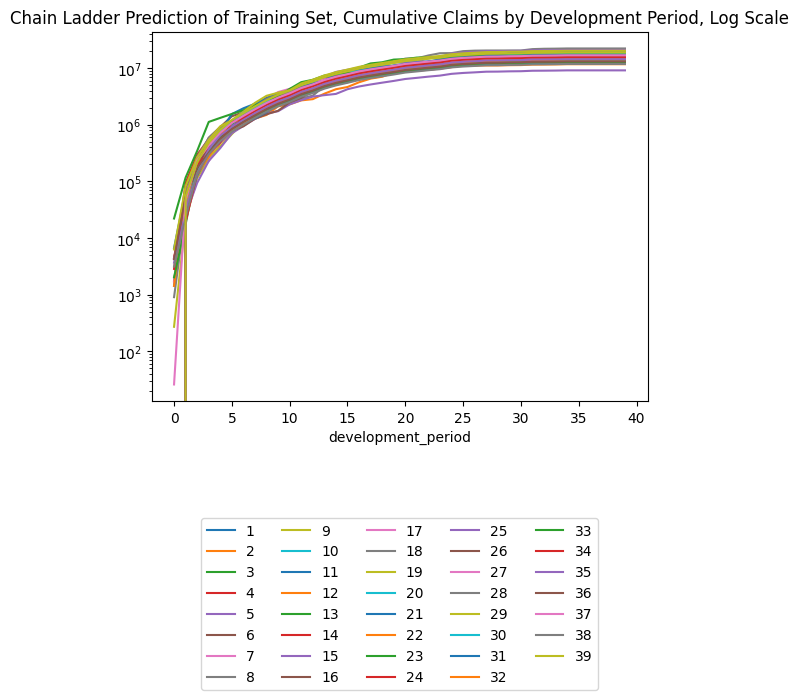

In [15]:
(triangle_cl
    .loc[lambda df: df.occurrence_period != cutoff]  # Exclude occurrence period == 40 since there's no data there at cutoff
    .pivot(index = "development_period", columns = "occurrence_period", values = "payment_size_cumulative")
    .plot(logy=True)
)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.8), ncol=5)
plt.title("Chain Ladder Prediction of Training Set, Cumulative Claims by Development Period, Log Scale")

In [16]:
# MSE / 10^12
# Exclude occurrence period == 40 since there's no data there at cutoff
np.sum((
    triangle_cl.loc[lambda df: df.occurrence_period != cutoff].payment_size_cumulative.values - 
    triangle.loc[lambda df: df.occurrence_period != cutoff].payment_size_cumulative.values
)**2)/10**12

np.float32(3150.4976)

## Chain Ladder, GLM, Aggregated Data
------
Chain ladders can be replicated with a GLM. 

In https://actuariesinstitute.github.io/cookbook/docs/MLRWP_R_GLMs.html, it used:
 * Quasipoisson distribution was used in the article (here just Poisson)
 * Log Link
 * Incremental ~ 0 + accident_period_factor + development_period_factor. I.e. No intercept. One factor per accident and development period.

Here we will use Torch, a package for neural networks, initially to do a GLM. Idea being that if it works, one could then test deep learning components to it. 
 * Poisson loss
 * Log Link 
 * Incremental ~ accident_period_factor + development_period_factor, but with intercept (seems to converge better this way)

Doing this at the claim level should give similar results just divided by number of claims.

In [17]:
class LogLinkGLM(nn.Module):
    # Define the parameters in __init__
    def __init__(
        self, 
        n_input,         # number of inputs
        n_output,        # number of outputs
        init_bias,       # init mean value to speed up convergence
        has_bias=True,   # use bias (intercept) or not       
        **kwargs,        # Ignored; Not used
    ):
        super(LogLinkGLM, self).__init__()
        
        self.linear = torch.nn.Linear(n_input, n_output, has_bias)  # Linear coefficients
        nn.init.zeros_(self.linear.weight)                          # Initialise to zero
        if has_bias:    
            self.linear.bias.data = torch.tensor(init_bias)


    # The forward functions defines how you get y from X.
    def forward(self, x):
        return torch.exp(self.linear(x))  # log(Y) = XB -> Y = exp(XB)

In [18]:
# Small dataset, so we can do a high number of iterations to converge to the mechanical chain ladder figures more precisely
GLM_CL_agg = Pipeline(
    steps=[
        ("keep", ColumnKeeper(["occurrence_period", "development_period"])), 
        ('one_hot', OneHotEncoder(sparse_output=False)),       # OneHot to get one factor per
        ("model", TabularNetRegressor(LogLinkGLM, has_bias=True, max_iter=10000, max_lr=0.10))
    ]
)
GLM_CL_agg.fit(
    triangle_train,
    triangle_train.loc[:, ["payment_size"]]
)

Train RMSE:  448176.59375  Train Loss:  -5389182.0
Train RMSE:  338983.78125  Train Loss:  -5504752.0
Train RMSE:  338971.21875  Train Loss:  -5505165.5
Train RMSE:  339789.59375  Train Loss:  -5504534.0
Train RMSE:  338971.03125  Train Loss:  -5505184.5
Train RMSE:  338970.96875  Train Loss:  -5505186.5
Train RMSE:  338970.96875  Train Loss:  -5505187.0
Train RMSE:  338970.96875  Train Loss:  -5505187.0
Train RMSE:  338970.96875  Train Loss:  -5505187.0
Train RMSE:  338970.96875  Train Loss:  -5505187.0


Pipeline(steps=[('keep',
                 ColumnKeeper(cols=['occurrence_period',
                                    'development_period'])),
                ('one_hot', OneHotEncoder(sparse_output=False)),
                ('model',
                 TabularNetRegressor(max_iter=10000, max_lr=0.1,
                                     module=<class '__main__.LogLinkGLM'>))])

In [19]:
triangle_train

occurrence_period  development_period  payment_period  \
0                     1                   0               1   
1                     1                   1               2   
2                     1                   2               3   
3                     1                   3               4   
4                     1                   4               5   
...                 ...                 ...             ...   
1481                 38                   1              39   
1482                 38                   2              40   
1520                 39                   0              39   
1521                 39                   1              40   
1560                 40                   0              40   

      payment_size_cumulative  payment_size  
0                    1,439.79      1,439.79  
1                   33,964.12     32,524.33  
2                  178,514.47    144,550.34  
3                  343,170.28    164,655.83  
4                  630,618.06    287,447.78  
...                       ...           ...  
1481                23,035.35     19,893.02  
1482               138,052.53    115,017.19  
1520                     0.00          0.00  
1521                54,288.11     54,288.11  
1560                     0.00          0.00  

[820 rows x 5 columns]

In [20]:
triangle_glm_agg = pd.concat(
    [
        triangle_train,
        triangle_test.assign(payment_size = GLM_CL_agg.predict(triangle_test))
    ], 
    axis="rows"
).sort_values(by=["occurrence_period", "development_period"])

triangle_glm_agg["payment_size_cumulative"] = (
    triangle_glm_agg[["occurrence_period", "payment_size"]].groupby('occurrence_period').cumsum()
)
triangle_glm_agg.pivot(index = "occurrence_period", columns = "development_period", values = "payment_size_cumulative")

development_period        0          1          2            3            4   \
occurrence_period                                                              
1                   1,439.79  33,964.12 178,514.47   343,170.31   630,618.06   
2                       0.00  39,101.35 116,772.10   239,416.25   472,654.28   
3                       0.00  27,682.06 196,798.88   396,756.00   522,254.59   
4                   4,340.67  36,499.27 161,562.59   293,577.38   547,973.75   
5                       0.00  35,032.82 146,433.44   290,105.00   486,530.09   
6                   1,773.62  40,529.51 163,240.41   376,696.69   612,710.75   
7                   1,677.26  39,523.21 129,868.84   227,166.45   540,881.31   
8                     904.43  30,041.22 171,799.50   419,135.62   773,168.94   
9                     271.28  20,946.97 115,077.41   268,745.34   416,010.38   
10                      0.00  30,596.70 196,910.97   443,027.31   782,419.31   
11                  6,632.53  66,972.10 207,548.12   462,256.00   793,185.62   
12                  1,431.22  67,051.79 156,599.81   270,577.44   649,722.75   
13                  2,029.26  17,454.87 180,379.50   341,824.38   595,547.50   
14                  2,853.19  93,844.98 295,558.84   556,663.06   910,465.19   
15                  3,685.83  28,948.63 146,381.06   321,382.22   521,733.19   
16                      0.00  81,474.84 228,731.06   588,765.94   910,906.88   
17                      0.00  66,420.51 197,170.69   484,344.44   838,551.12   
18                      0.00  53,138.43 123,639.84   298,696.47   535,833.19   
19                      0.00  34,086.87 204,900.75   400,163.16   600,445.25   
20                      0.00  42,283.17 175,072.05   414,349.50   840,670.56   
21                      0.00  25,207.58 169,402.56   347,866.75   743,656.50   
22                      0.00  36,790.93 181,476.38   445,429.81   700,554.06   
23                 22,106.89 116,623.65 345,401.34 1,121,187.00 1,320,994.88   
24                  4,465.26  55,838.55 181,278.97   386,256.75   606,791.31   
25                  4,367.87  25,870.57  94,031.31   228,997.44   386,928.69   
26                      0.00  79,592.89 226,306.89   360,370.25   561,948.44   
27                      0.00  20,480.35 134,592.89   339,774.44   515,044.47   
28                      0.00  54,087.19 269,660.25   583,219.50   907,550.56   
29                  6,292.51  82,104.09 263,787.59   541,113.62   939,427.50   
30                      0.00  33,078.70 151,494.28   346,339.56   770,497.12   
31                      0.00  22,283.46 130,078.08   301,486.56   563,131.88   
32                      0.00  32,882.53 134,910.67   278,651.25   529,224.88   
33                      0.00  24,749.48 164,366.52   319,528.56   590,100.44   
34                      0.00  19,428.75 138,058.89   310,084.00   488,873.59   
35                      0.00  31,437.90 139,078.39   369,741.56   646,867.75   
36                  4,233.76  52,775.73 176,901.16   319,410.47   565,794.50   
37                     26.03  46,980.28 233,096.56   428,300.34   726,830.31   
38                  3,142.33  23,035.35 138,052.53   301,331.06   511,362.50   
39                      0.00  54,288.11 220,072.77   480,358.12   815,172.88   
40                      0.00     395.50   1,655.64     3,634.10     6,179.06   

development_period           5            6            7            8   \
occurrence_period                                                        
1                  1,018,364.31 1,352,423.00 1,635,850.25 1,882,757.38   
2                    729,413.31   979,287.81 1,272,592.00 1,606,688.50   
3                    875,562.62 1,314,355.75 1,966,983.00 2,339,964.25   
4                    863,551.50 1,134,608.12 1,360,245.00 2,322,095.50   
5                    769,324.75 1,033,624.06 1,469,111.75 2,022,809.25   
6                    925,434.62 1,361,709.38 1,597,676.38 2,122,347.25   
7                    729,756.88 1,051,510.38 1,

Check difference with chain ladder. These seem quite small, except for occurrence period 40 where our log link is unable to get the value to zero.

In [21]:
(triangle_glm_agg.pivot(index = "occurrence_period", columns = "development_period", values = "payment_size_cumulative") - 
triangle_cl.pivot(index = "occurrence_period", columns = "development_period", values = "payment_size_cumulative"))

development_period   0      1        2        3        4        5         6   \
occurrence_period                                                              
1                  0.00   0.00     0.00     0.03     0.00     0.00      0.12   
2                  0.00   0.00     0.00     0.02     0.00     0.00      0.00   
3                  0.00   0.00     0.02     0.03     0.03     0.00      0.12   
4                  0.00   0.00     0.00    -0.03     0.00     0.00      0.00   
5                  0.00   0.00     0.02     0.00     0.00     0.00      0.00   
6                  0.00   0.00     0.02     0.00     0.06     0.00      0.00   
7                  0.00   0.00     0.00     0.00     0.00    -0.06      0.00   
8                  0.00  -0.00     0.02     0.00     0.00     0.00      0.00   
9                  0.00   0.00     0.01     0.00     0.03     0.00      0.00   
10                 0.00   0.00     0.00     0.00     0.00     0.00      0.00   
11                 0.00   0.00    -0.02    -0.03     0.00    -0.06      0.00   
12                 0.00   0.01     0.02     0.00     0.00     0.00      0.00   
13                 0.00   0.00     0.00     0.00     0.00     0.00      0.00   
14                 0.00   0.00     0.00     0.00     0.00     0.00      0.00   
15                 0.00   0.00     0.00     0.00     0.00    -0.06      0.00   
16                 0.00   0.00     0.00     0.00    -0.06     0.00      0.00   
17                 0.00   0.00     0.00     0.00    -0.06     0.00      0.00   
18                 0.00   0.00     0.01     0.03     0.00     0.00      0.00   
19                 0.00   0.00     0.00     0.03     0.00     0.00      0.00   
20                 0.00   0.00     0.00     0.00     0.00     0.00     -0.12   
21                 0.00   0.00     0.00     0.03     0.00     0.00      0.00   
22                 0.00   0.00     0.00     0.00     0.00     0.00      0.00   
23                 0.00   0.00     0.00     0.00     0.00     0.00      0.00   
24                 0.00   0.00     0.00     0.03     0.00     0.00      0.00   
25                 0.00   0.00     0.00     0.00     0.00     0.00      0.00   
26                 0.00   0.00     0.00     0.00     0.00     0.00      0.00   
27                 0.00   0.00     0.00     0.00     0.00     0.00      0.00   
28                 0.00   0.00     0.00     0.00     0.00     0.00      0.00   
29                 0.00   0.00     0.00     0.00     0.00    -0.12      0.00   
30                 0.00   0.00     0.00     0.00    -0.06     0.00      0.00   
31                 0.00   0.00     0.00     0.03     0.00     0.00      0.00   
32                 0.00   0.00     0.00    -0.03     0.00     0.00     -0.06   
33                 0.00   0.00     0.00    -0.03    -0.06     0.00     -0.12   
34                 0.00   0.00     0.00     0.03     0.00     0.00      0.00   
35                 0.00   0.00     0.00     0.00     0.00     0.00      0.75   
36                 0.00   0.00     0.00     0.00    -0.06     0.81      1.62   
37                 0.00   0.00     0.00     0.00     1.38     3.00      5.00   
38                 0.00   0.00     0.00     2.12     5.00     8.38     11.81   
39                 0.00   0.00     6.59    17.03    30.38    45.88     62.25   
40                 0.00 395.50 1,655.64 3,634.10 6,179.06 9,151.12 12,209.52   

development_period        7         8         9   ...         30         31  \
occurrence_period                                 ...                         
1                       0.00      0.12      0.00  ...       0.00       0.00   
2                       0.00      0.00     -0.25  ...       0.00       0.00   
3                       0.12      0.00      0.00  ...       0.00       0.00   
4                       0.00     -0.25      0.00  ...       0.00       0.00   
5                       0.00     -0.12      0.00  ...       0.00       0.00   
6                       0.00      0.00      0.00  ...       0.00       0.00   
7      

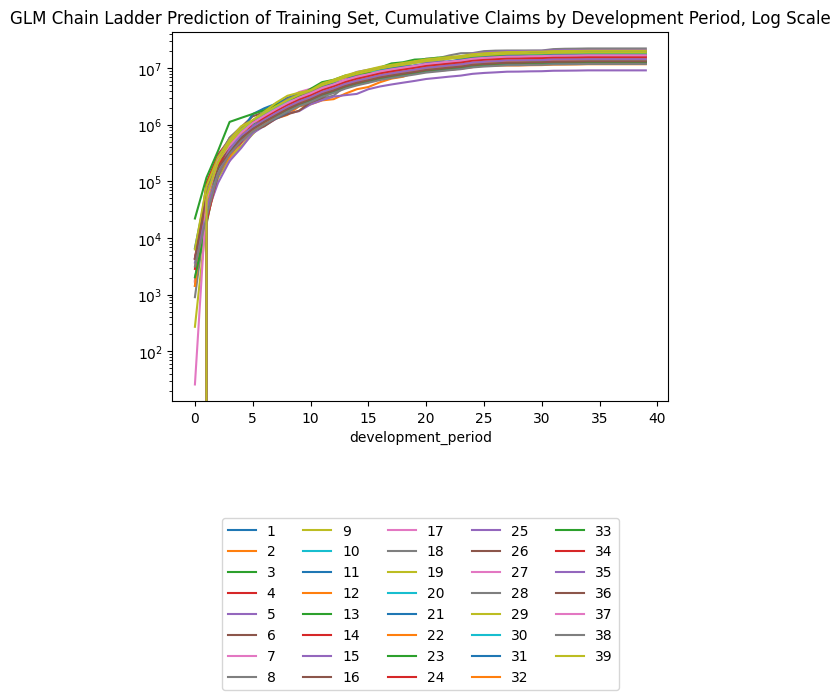

In [22]:
(triangle_glm_agg
    .loc[lambda df: df.occurrence_period != cutoff]  # Exclude occurrence period == 40 since there's no data there at cutoff
    .pivot(index = "development_period", columns = "occurrence_period", values = "payment_size_cumulative")
    .plot(logy=True)
)
plt.title("GLM Chain Ladder Prediction of Training Set, Cumulative Claims by Development Period, Log Scale")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.8), ncol=5)

In [23]:
# MSE / 10^12
# Exclude occurrence period == 40 since there's no data there at cutoff
np.sum((
    triangle_glm_agg.loc[lambda df: df.occurrence_period != cutoff].payment_size_cumulative.values - 
    triangle.loc[lambda df: df.occurrence_period != cutoff].payment_size_cumulative.values
)**2)/10**12

np.float32(3150.6155)

## GLM, Occurrence/Development Only, Individual Data
-----

What if we just fit the same "chain ladder" model on the individual data?

One limitation moving to individual data, is that we would be predicting ultimates including claims that we would not be normally aware of yet. This is, however, a limitation with most individual claims models. A method of overcoming this could be to start at the policy rather than at the claim (and following this same process of one record per period), however our dataset is at the claim level. 

In [24]:
GLM_CL_ind = Pipeline(
    steps=[
        ("keep", ColumnKeeper(["occurrence_period", "development_period"])), 
        ('one_hot', OneHotEncoder(sparse_output=False)),       # OneHot to get one factor per
        ("model", TabularNetRegressor(LogLinkGLM, has_bias=True, max_iter=glm_iter, max_lr=0.05))
    ]
)
GLM_CL_ind.fit(
    dat.loc[dat.train_ind == 1],
    dat.loc[dat.train_ind, ["payment_size"]]
)

Train RMSE:  39386.87109375  Train Loss:  -38060.55078125
Train RMSE:  39313.55859375  Train Loss:  -38638.18359375
Train RMSE:  39278.33203125  Train Loss:  -39008.34765625
Train RMSE:  39276.828125  Train Loss:  -39053.33203125
Train RMSE:  39276.6875  Train Loss:  -39061.9296875
Train RMSE:  39276.64453125  Train Loss:  -39064.9140625
Train RMSE:  39276.63671875  Train Loss:  -39066.29296875
Train RMSE:  39276.62890625  Train Loss:  -39066.99609375
Train RMSE:  39276.625  Train Loss:  -39067.3359375
Train RMSE:  39276.62109375  Train Loss:  -39067.46484375


Pipeline(steps=[('keep',
                 ColumnKeeper(cols=['occurrence_period',
                                    'development_period'])),
                ('one_hot', OneHotEncoder(sparse_output=False)),
                ('model',
                 TabularNetRegressor(max_iter=500, max_lr=0.05,
                                     module=<class '__main__.LogLinkGLM'>))])

In [25]:
# Function to make a dataset with train payments and test predictions, and resulting triangle
def make_pred_set_and_triangle(individual_model, train, test):
    dat_model_pred = pd.concat(
        [
            train,
            test.assign(payment_size = individual_model.predict(test))
        ], 
        axis="rows"
    )
    dat_model_pred["payment_size_cumulative"] = (
        dat_model_pred[["claim_no", "payment_size"]].groupby('claim_no').cumsum()
    )

    triangle_model_ind = (dat_model_pred
        .groupby(["occurrence_period", "development_period", "payment_period"], as_index=False)
        .agg({"payment_size_cumulative": "sum", "payment_size": "sum"})
        .sort_values(by=["occurrence_period", "development_period"])
    )

    (triangle_model_ind
        .loc[lambda df: (df.occurrence_period != cutoff) & (df.development_period < cutoff)]
        .pivot(index = "development_period", columns = "occurrence_period", values = "payment_size_cumulative")
        .plot(logy=True)
    )
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.8), ncol=5)
    plt.title("Cumulative Claims by Development - Predictions Lower Half Triangle")

    return dat_model_pred, triangle_model_ind

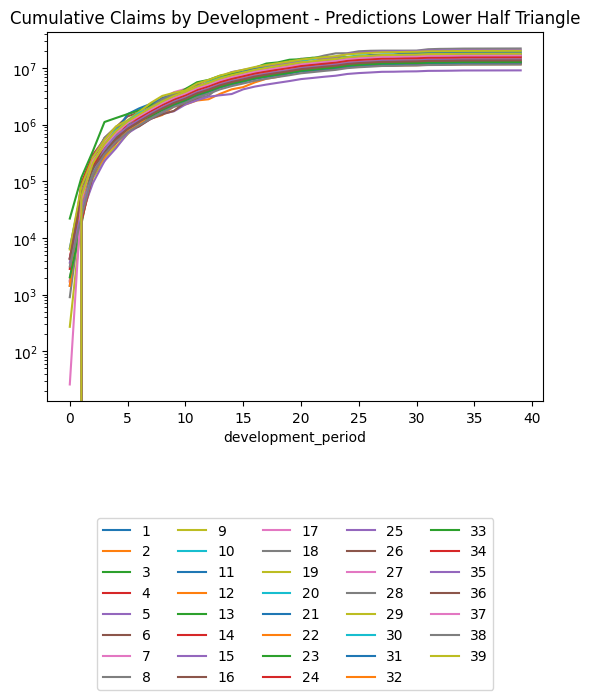

In [26]:
dat_glm_pred, triangle_glm_ind = make_pred_set_and_triangle(GLM_CL_ind, dat.loc[dat.train_ind == 1], dat.loc[dat.train_ind == 0])

Looks to be giving a reasonable curve. 


### Differences with Chain Ladder


Differences in GLM coefficients with aggregated data:

In [27]:
start = cutoff
end = cutoff + num_dev_periods + 1
start, end

(40, 80)

In [28]:
GLM_CL_agg["model"].module_.linear.weight.data[: ,start:end].cpu().numpy().ravel()

array([-4.276209  , -1.1383885 ,  0.02045104,  0.47153997,  0.7233392 ,
        0.8784809 ,  0.90711343,  1.1198902 ,  1.3147773 ,  1.4113451 ,
        1.376504  ,  1.776079  ,  1.5967234 ,  1.9294479 ,  1.7942605 ,
        1.6911825 ,  1.8522465 ,  1.6360332 ,  1.6001166 ,  1.6417    ,
        1.8306528 ,  1.3488718 ,  1.4601185 ,  1.3632869 ,  1.9317981 ,
        1.3118441 ,  0.94226056,  1.0750425 , -0.91770446,  0.18879272,
       -0.6069001 ,  0.77604496, -1.0988672 , -0.63608164, -0.11182759,
       -8.627261  , -8.624586  , -8.613742  , -8.619699  , -8.651528  ],
      dtype=float32)

In [29]:
GLM_CL_ind["model"].module_.linear.weight.data[: ,start:end].cpu().numpy().ravel()

array([-2.6953292 , -1.5995921 , -0.64212954, -0.22906823,  0.01851771,
        0.17462565,  0.20282625,  0.41608196,  0.61120886,  0.7075952 ,
        0.67280203,  1.0717171 ,  0.8925516 ,  1.2247266 ,  1.0898155 ,
        0.9868974 ,  1.1476692 ,  0.93185186,  0.8960151 ,  0.93756056,
        1.1262082 ,  0.6452524 ,  0.7563339 ,  0.65967613,  1.2271914 ,
        0.6083249 ,  0.23831072,  0.37146965, -1.6348568 , -0.5185623 ,
       -1.3258325 ,  0.07199424, -1.8027934 , -1.3546002 , -0.8210336 ,
       -2.8964188 , -2.882737  , -2.8465805 , -2.840551  , -2.805035  ],
      dtype=float32)

/mnt/nfs_clientshare/home/f20122/git/99_MLR_NN/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/nfs_clientshare/home/f20122/git/99_MLR_NN/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

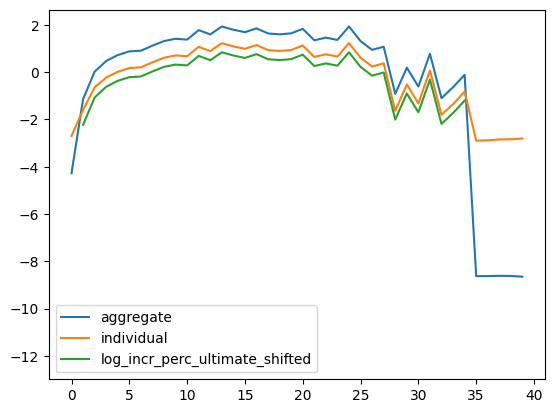

In [30]:
pd.DataFrame.from_dict({
    "aggregate": GLM_CL_agg["model"].module_.linear.weight.data[: ,start:end].cpu().numpy().ravel(),
    "individual": GLM_CL_ind["model"].module_.linear.weight.data[: ,start:end].cpu().numpy().ravel(),
    "log_incr_perc_ultimate_shifted": np.log(df_cdf.incr_perc_of_ultimate * num_dev_periods)
}).plot()


Difference in predictions in direct calculation:

In [31]:
(triangle_glm_ind.pivot(index = "occurrence_period", columns = "development_period", values = "payment_size_cumulative") - 
triangle_cl.pivot(index = "occurrence_period", columns = "development_period", values = "payment_size_cumulative"))

development_period   0        1         2          3          4          5   \
occurrence_period                                                             
1                  0.00     0.00      0.00       0.00       0.00       0.00   
2                  0.00     0.00      0.00       0.02       0.00       0.00   
3                  0.00     0.00      0.00       0.03       0.00       0.00   
4                  0.00     0.00      0.00      -0.03       0.00       0.00   
5                  0.00     0.00      0.00       0.00       0.00       0.00   
6                  0.00     0.00      0.00       0.00       0.00       0.00   
7                  0.00     0.00      0.00       0.00       0.00       0.00   
8                  0.00     0.00      0.00       0.00       0.00       0.00   
9                  0.00     0.00      0.00       0.00       0.00       0.00   
10                 0.00     0.00      0.00       0.00       0.00       0.00   
11                 0.00     0.00      0.00       0.00       0.00       0.00   
12                 0.00     0.00      0.00       0.00       0.00       0.00   
13                 0.00     0.00      0.00       0.00       0.00       0.00   
14                 0.00     0.00      0.00       0.00       0.00       0.00   
15                 0.00     0.00      0.00       0.00       0.00      -0.06   
16                 0.00     0.00      0.00       0.00       0.00       0.00   
17                 0.00     0.00      0.00       0.00       0.00       0.00   
18                 0.00     0.00      0.00       0.03       0.00       0.00   
19                 0.00     0.00      0.00       0.00       0.00       0.00   
20                 0.00     0.00      0.00       0.00       0.00       0.00   
21                 0.00     0.00      0.00       0.00       0.00       0.00   
22                 0.00     0.00      0.00       0.00       0.00       0.00   
23                 0.00     0.00      0.00       0.00       0.00       0.00   
24                 0.00     0.00      0.00       0.03       0.00       0.00   
25                 0.00     0.00      0.00       0.00       0.00       0.00   
26                 0.00     0.00      0.00       0.00       0.00       0.00   
27                 0.00     0.00      0.00       0.00       0.00       0.00   
28                 0.00     0.00      0.00       0.00       0.00       0.00   
29                 0.00     0.00      0.00       0.00       0.00       0.00   
30                 0.00     0.00      0.00       0.00       0.00       0.00   
31                 0.00     0.00      0.00       0.03      -0.06       0.00   
32                 0.00     0.00      0.00       0.00       0.00       0.00   
33                 0.00     0.00      0.00       0.00       0.00       0.00   
34                 0.00     0.00      0.00       0.00       0.00       0.00   
35                 0.00     0.00      0.00       0.00       0.00       0.00   
36                 0.00     0.00      0.00       0.03       0.00  12,513.81   
37                 0.00     0.00      0.00       0.00    -178.25     -49.50   
38                 0.00     0.00      0.00  -3,380.69  -8,594.19 -14,451.31   
39                 0.00     0.00 -7,792.33 -21,322.06 -36,661.81 -54,215.38   
40                 0.00 7,494.16 32,873.88  73,200.94 124,857.04 185,240.56   

development_period         6          7           8           9   ...  \
occurrence_period                                                 ...   
1                        0.00       0.00        0.12       -0.25  ...   
2                        0.00       0.00        0.00        0.00  ...   
3                        0.00       0.00        0.00        0.00  ...   
4                        0.00       0.00        0.00        0.00  ...   
5                        0.00       0.00        0.00        0.00  ...   
6                        0.00       0.00        0.00        0.00  ...   
7                        0.00       0.00        0.00        0.00  ...   
8                       

In [32]:
# MSE / 10^12
# Exclude occurrence period == 40 since there's no data there at cutoff
np.sum((
    triangle_glm_ind.loc[lambda df: df.occurrence_period != cutoff].payment_size_cumulative.values - 
    triangle.loc[lambda df: df.occurrence_period != cutoff].payment_size_cumulative.values
)**2)/10**12

np.float32(2940.2283)

## GLM with Splines, Occur/Dev, Individual Data
-------
In Grainne McGuire's article she uses splines in the GLM model to model a parabolic trend in occurrence period. In this example data, there is also a curve with development periods. 
Can we do something similar?


In [33]:
GLM_CL_spline = Pipeline(
    steps=[
        ("keep", ColumnKeeper(["occurrence_period", "development_period"])), 
        ('one_hot', SplineTransformer()),       # Spline transform
        ("model", TabularNetRegressor(LogLinkGLM, has_bias=True, max_iter=glm_iter, max_lr=0.05))
    ]
)
GLM_CL_spline.fit(
    dat.loc[dat.train_ind == 1],
    dat.loc[dat.train_ind, ["payment_size"]]
)

Train RMSE:  39387.21875  Train Loss:  -38060.55078125
Train RMSE:  39338.234375  Train Loss:  -38455.37109375
Train RMSE:  39300.02734375  Train Loss:  -38834.58984375
Train RMSE:  39298.1953125  Train Loss:  -38875.8203125
Train RMSE:  39297.171875  Train Loss:  -38889.6484375
Train RMSE:  39296.64453125  Train Loss:  -38897.1796875
Train RMSE:  39296.35546875  Train Loss:  -38901.33984375
Train RMSE:  39296.19921875  Train Loss:  -38903.58203125
Train RMSE:  39296.125  Train Loss:  -38904.6953125
Train RMSE:  39296.09765625  Train Loss:  -38905.109375


Pipeline(steps=[('keep',
                 ColumnKeeper(cols=['occurrence_period',
                                    'development_period'])),
                ('one_hot', SplineTransformer()),
                ('model',
                 TabularNetRegressor(max_iter=500, max_lr=0.05,
                                     module=<class '__main__.LogLinkGLM'>))])

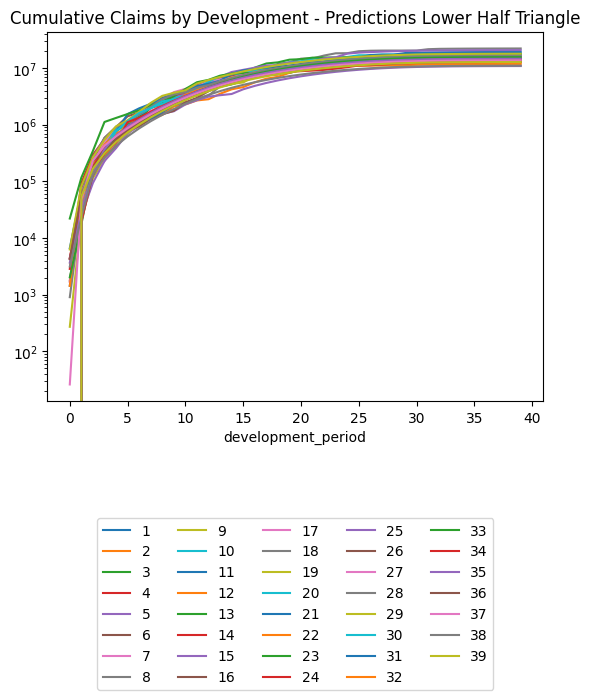

In [34]:
dat_spline_pred, triangle_spline_ind = make_pred_set_and_triangle(GLM_CL_spline, dat.loc[dat.train_ind == 1], dat.loc[dat.train_ind == 0])

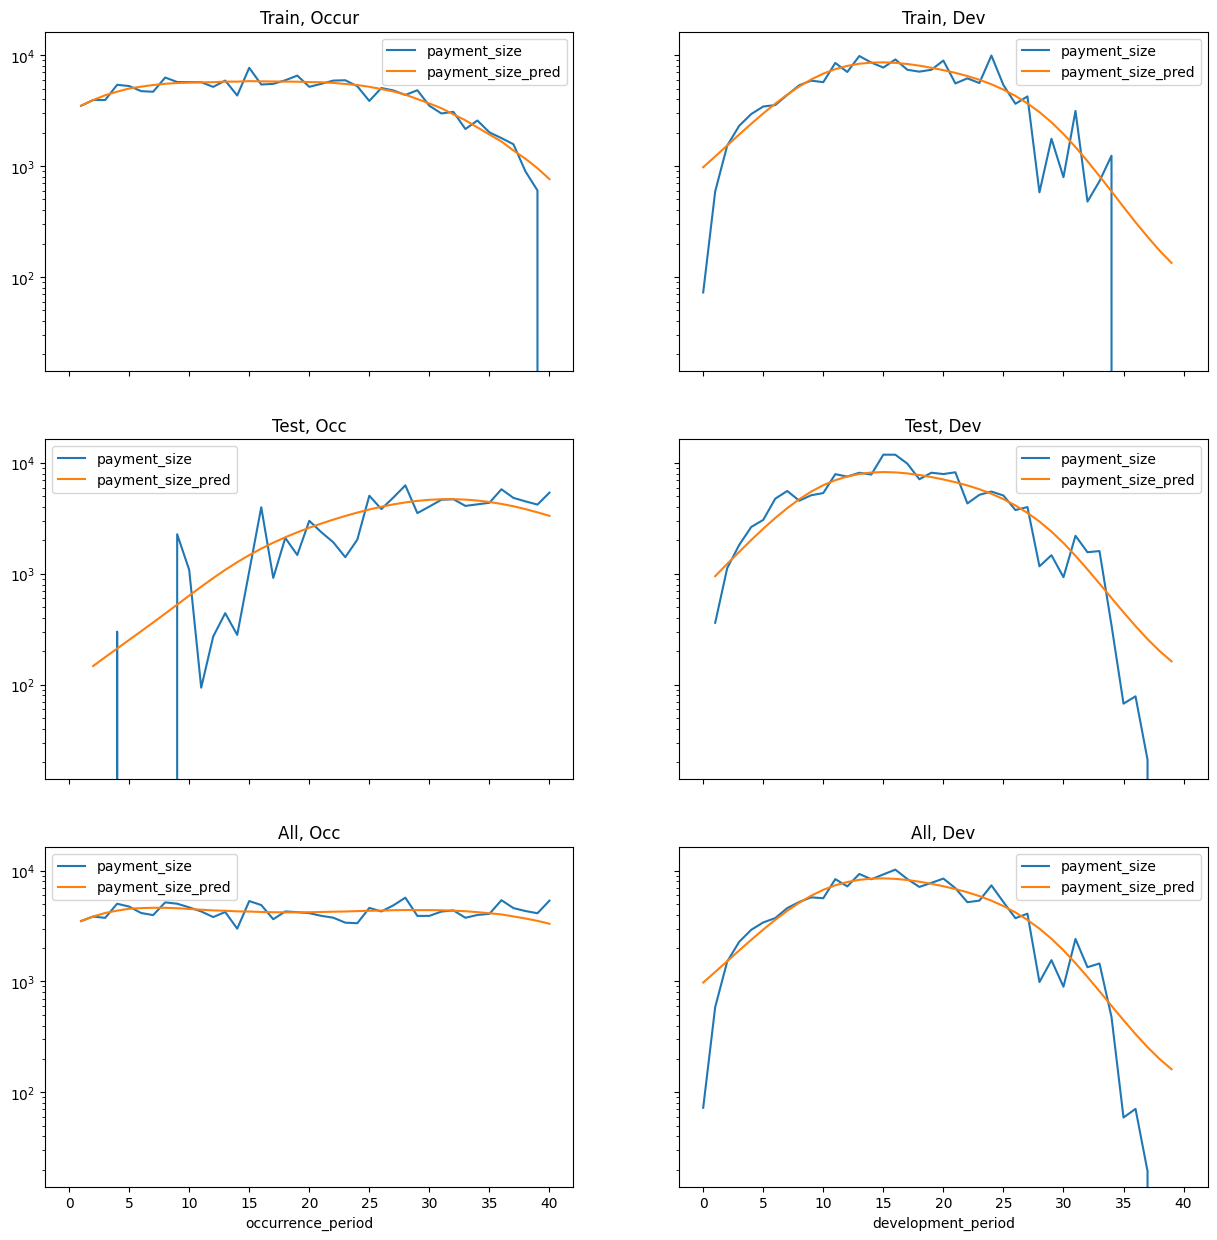

In [35]:
# Diagnostic model subplots
# We will be repeating this logic across multiple models, so put logic into function for repeatability

def make_model_subplots(model, dat):
    fig, axes = plt.subplots(3, 2, sharex='all', sharey='all', figsize=(15, 15))

    (dat
        .assign(payment_size_pred = model.predict(dat))
        .loc[lambda df: df.train_ind]
        .groupby(["occurrence_period"])
        .agg({"payment_size": "mean", "payment_size_pred": "mean"})
    ).plot(ax=axes[0,0], logy=True)
    axes[0,0].title.set_text("Train, Occur")

    (dat
        .assign(payment_size_pred = model.predict(dat))
        .loc[lambda df: df.train_ind]
        .groupby(["development_period"])
        .agg({"payment_size": "mean", "payment_size_pred": "mean"})
    ).plot(ax=axes[0,1], logy=True)
    axes[0,1].title.set_text("Train, Dev")

    (dat
        .assign(payment_size_pred = model.predict(dat))
        .loc[lambda df: ~df.train_ind]
        .groupby(["occurrence_period"])
        .agg({"payment_size": "mean", "payment_size_pred": "mean"})
    ).plot(ax=axes[1,0], logy=True)
    axes[1,0].title.set_text("Test, Occ")

    (dat
        .assign(payment_size_pred = model.predict(dat))
        .loc[lambda df: ~df.train_ind]
        .groupby(["development_period"])
        .agg({"payment_size": "mean", "payment_size_pred": "mean"})
    ).plot(ax=axes[1,1], logy=True)
    axes[1,1].title.set_text("Test, Dev")

    (dat
        .assign(payment_size_pred = model.predict(dat))
        .groupby(["occurrence_period"])
        .agg({"payment_size": "mean", "payment_size_pred": "mean"})
    ).plot(ax=axes[2,0], logy=True)
    axes[2,0].title.set_text("All, Occ")

    (dat
        .assign(payment_size_pred = model.predict(dat))
        .groupby(["development_period"])
        .agg({"payment_size": "mean", "payment_size_pred": "mean"})
    ).plot(ax=axes[2,1], logy=True)
    axes[2,1].title.set_text("All, Dev")

make_model_subplots(GLM_CL_spline, dat)

This should look reasonable.

## Neural Network, Occurence/Development Only 
----

Can we have deep learning just figure out this curve by using the periods as numeric inputs, rather than the one-hot encoding?

Here we have a ResNet pretty similar to the ones previously used in the other notebooks. There is more functionality built-in than a base ResNet - some observations on the architecture:

 * This is the concatenation variant rather than addition variant of the ResNet, but for a single hidden layer it does not make much difference. 
 * **Batch Normalisation**:  We use a variant of FixUp initialisation so the batch normalisation is not needed for numerical stability. Our experience is that including this leads to a higher degree of overfitting.
 * **L1 and L2 normalisation** are built into the sci-kit learn wrapper. L1 enforces sparsity but also leads to some underfitting of effects.
 * **Dropout** layer is available for optimisation. 
 * **One Cycle learning schedule with Adam** is used as the optimiser in the sci-kit learn wrapper above. It seems to work in getting a working model quickly. 
 * **ELU** is used as activation. Sigmoid does not appear to work well. Occasionally ReLU has dead neurons which impact model results due to low neuron count.


In [36]:
class LogLinkResNet(nn.Module):
    # Define the parameters in __init__
    def __init__(
        self,      
        n_input,                                           # number of inputs
        n_output,                                          # number of outputs
        init_bias,                                         # init mean value to speed up convergence 
        n_hidden,                                          # hidden layer size
        batch_norm,                                        # whether to do batch norm (boolean)
        dropout,                                           # dropout percentage,
        **kwargs, 
    ): 

        super(LogLinkResNet, self).__init__()

        self.hidden = nn.Linear(n_input, n_hidden)   # Hidden layer

        # Batchnorm layer    
        self.batch_norm = batch_norm
        if batch_norm:
            self.batchn = nn.BatchNorm1d(n_hidden)       
        self.dropout = nn.Dropout(dropout)
        self.linear = torch.nn.Linear(n_input, n_output)   # Linear coefficients

        # Neural net coefficients - no bias - glm has a bias already
        self.neural = torch.nn.Linear(n_hidden, n_output, bias=False)  

        nn.init.zeros_(self.linear.weight)                 # Initialise to zero
        nn.init.zeros_(self.neural.weight)                 # n.b. do not initialise hidden layers to zero
        self.linear.bias.data = torch.tensor(init_bias)


    # The forward function defines how you get y from X.
    def forward(self, x):
        h = F.elu(self.hidden(x))                   # Apply hidden layer
        if self.batch_norm:
            h = self.batchn(h)                       # Apply batchnorm   
        h = self.dropout(h)
        return torch.exp(self.linear(x) + self.neural(h))  # Add GLM to NN

### Development Period Only Model
So here we min-max scale the data rather than one-hot encode it. The ResNet to figure out the effect. 

First, we test with a model with only one feature - ``development_period``. 

In [37]:
model_NN = Pipeline(
    steps=[
        ("keep", ColumnKeeper(["development_period"])),   # Just development period!
        ('zero_to_one', MinMaxScaler()),       # Important! Standardize deep learning inputs.
        ("model", TabularNetRegressor(LogLinkResNet, n_hidden=20, max_iter=nn_iter, max_lr=0.05))
    ]
)

model_NN.fit(
    dat.loc[dat.train_ind == 1],
    dat.loc[dat.train_ind == 1, ["payment_size"]]
)

Train RMSE:  39387.50390625  Train Loss:  -38060.55078125
Train RMSE:  39381.640625  Train Loss:  -38118.3125
Train RMSE:  39300.203125  Train Loss:  -38874.71875
Train RMSE:  39299.9296875  Train Loss:  -38873.55078125
Train RMSE:  39298.5  Train Loss:  -38880.53515625
Train RMSE:  39298.390625  Train Loss:  -38882.7421875
Train RMSE:  39298.265625  Train Loss:  -38885.03125
Train RMSE:  39298.265625  Train Loss:  -38886.44140625
Train RMSE:  39298.26953125  Train Loss:  -38887.1171875
Train RMSE:  39298.2734375  Train Loss:  -38887.390625


Pipeline(steps=[('keep', ColumnKeeper(cols=['development_period'])),
                ('zero_to_one', MinMaxScaler()),
                ('model',
                 TabularNetRegressor(max_iter=500, max_lr=0.05,
                                     module=<class '__main__.LogLinkResNet'>))])

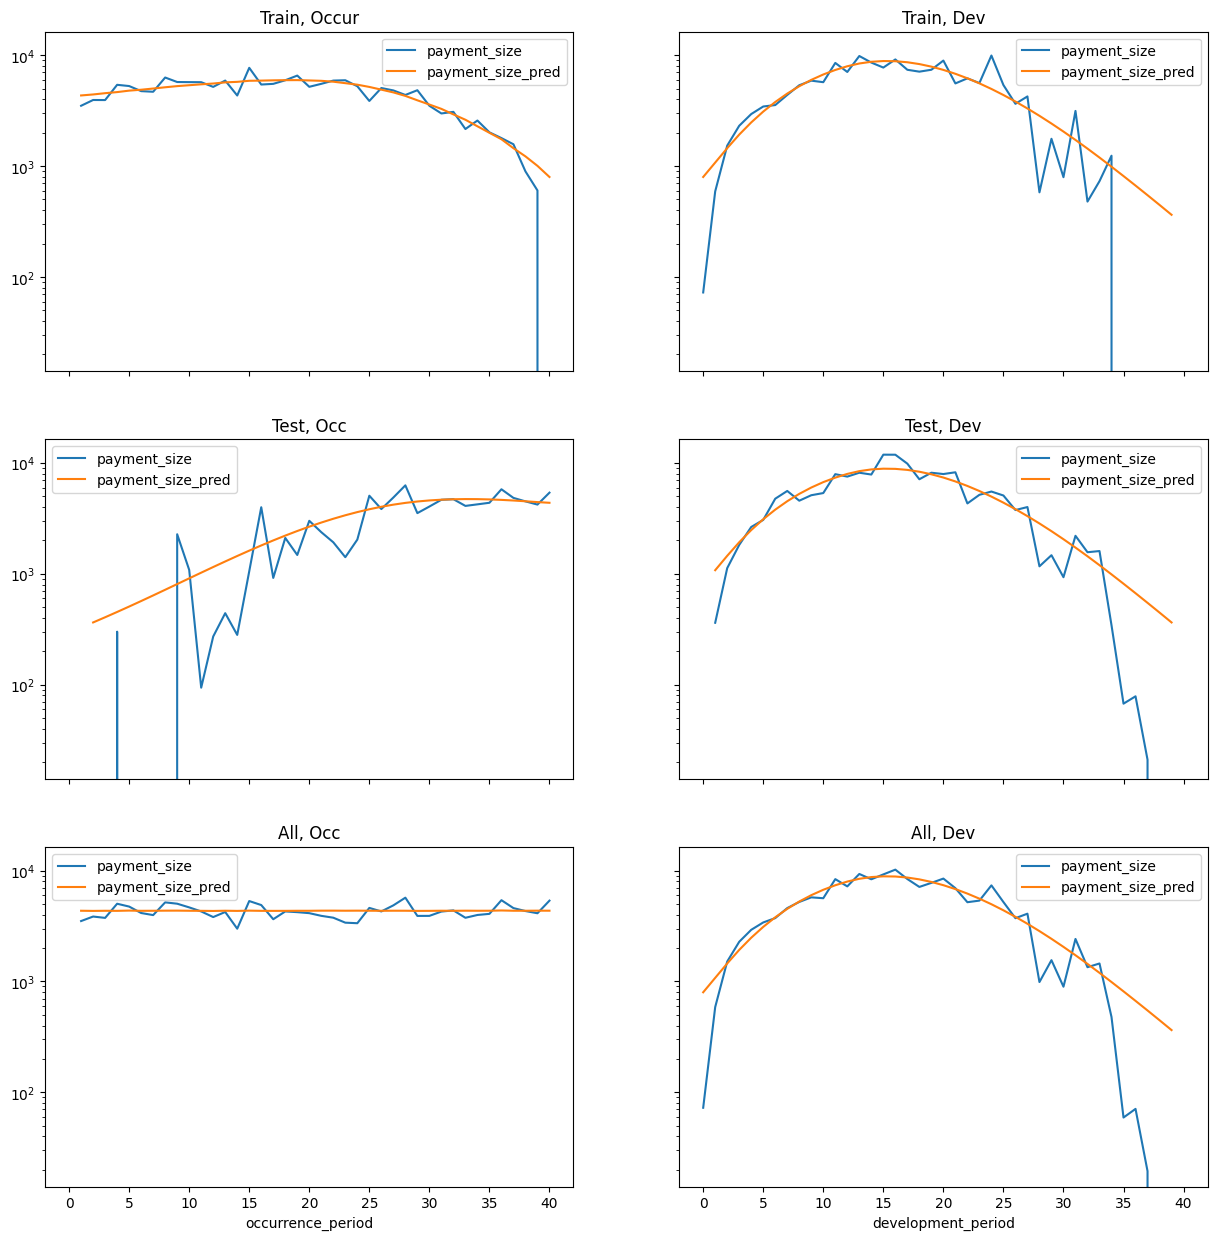

In [38]:
make_model_subplots(model_NN, dat)

So far, this approach does fine. It seems to reflect the development pattern for the training and holdout datasets.
But to replicate chain ladder, we need occurrence too.

### Development and Occurrence Model

Now we use both development and occurrence.

In [39]:
model_NN = Pipeline(
    steps=[
        ("keep", ColumnKeeper(["occurrence_period", "development_period"])),   # both
        ('zero_to_one', MinMaxScaler()),       # Important! Standardize deep learning inputs.
        ("model", TabularNetRegressor(LogLinkResNet, n_hidden=20, max_iter=nn_iter, max_lr=0.05))
    ]
)

model_NN.fit(
    dat.loc[dat.train_ind == 1],
    dat.loc[dat.train_ind == 1, ["payment_size"]]
)


Train RMSE:  39387.5703125  Train Loss:  -38060.55078125
Train RMSE:  39376.06640625  Train Loss:  -38150.53515625
Train RMSE:  39312.47265625  Train Loss:  -38768.22265625
Train RMSE:  39299.88671875  Train Loss:  -38872.5234375
Train RMSE:  39301.796875  Train Loss:  -38872.8984375
Train RMSE:  39298.07421875  Train Loss:  -38889.68359375
Train RMSE:  39298.09375  Train Loss:  -38891.03515625
Train RMSE:  39298.12109375  Train Loss:  -38891.88671875
Train RMSE:  39298.13671875  Train Loss:  -38892.375
Train RMSE:  39298.14453125  Train Loss:  -38892.57421875


Pipeline(steps=[('keep',
                 ColumnKeeper(cols=['occurrence_period',
                                    'development_period'])),
                ('zero_to_one', MinMaxScaler()),
                ('model',
                 TabularNetRegressor(max_iter=500, max_lr=0.05,
                                     module=<class '__main__.LogLinkResNet'>))])

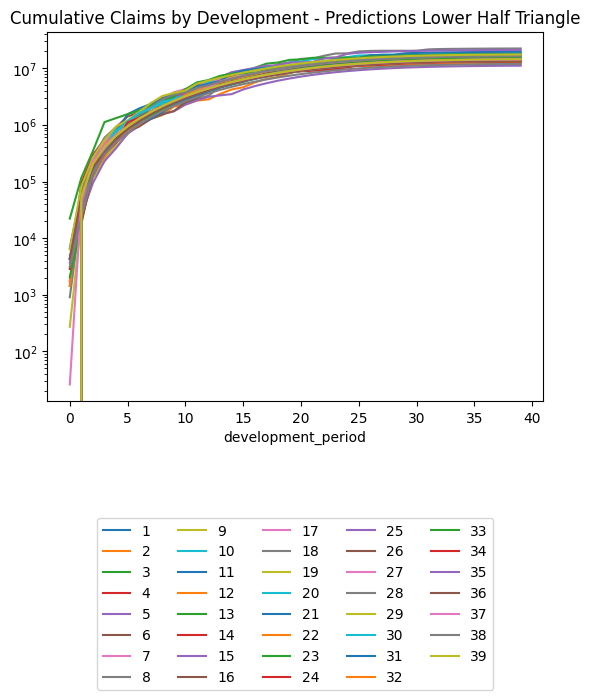

In [40]:
dat_nn_pred, triangle_resnet_do = make_pred_set_and_triangle(model_NN, dat.loc[dat.train_ind == 1], dat.loc[dat.train_ind == 0])

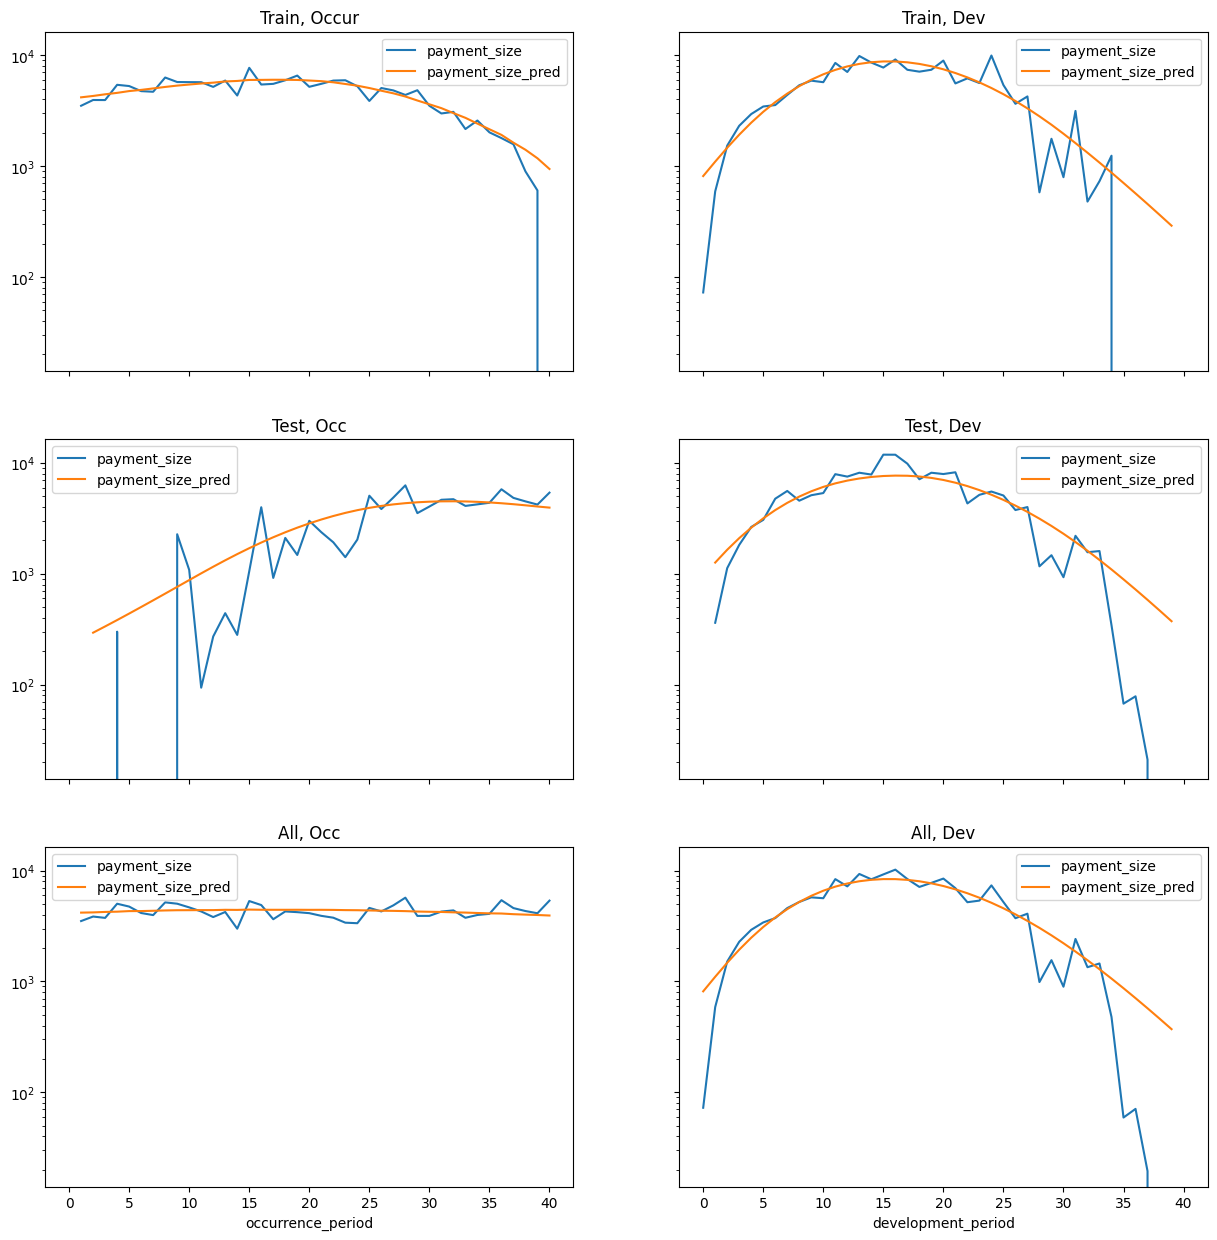

In [41]:
make_model_subplots(model_NN, dat)

The model does fit well for training data, but the model sometimes appears overfits, particularly on the occurrence period trend for dataset 1, which leads to a deterioration of performance in test data. Performance appears to be better when batch normalisation is not used. 

## "SplineNet" Architecture, Occurrence/Development Only
----

An observation with the above model compared to the spline GLM is that all the hidden layer components are naturally interactions rather than the one-way splines in the GLM. If only we could fit the model as a linear combination of one-way effects. 

We re-introduce ideas from our earlier paper [1]. This model architecture includes:
 * a log-link, through the exponential transformation at the end,
 * one-way neural network splines, linearly combined, to ensure single-variable effects are well-captured, similar to the spline-GLM earlier,
 * a neural interaction component to which l1, weight decay, dropout regularization and penalties are applied to put a cost to multi-way effects and discourage overfitting. 
 * an interaction parameter, which can be set at between 0.0 and 1.0, to governs the impact of this interaction. This is set as a trainable parameter with a sigmoid gate based on Residual Gates and Highway Networks [3] so that the model can identify to what extent interactions are required.

In [42]:
class SplineNet(nn.Module):
    # Define the parameters in __init__
    def __init__(
        self,      
        n_input,                                           # number of inputs
        n_output,                                          # number of outputs
        init_bias,                                         # init mean value to speed up convergence 
        n_hidden,                                          # hidden layer size
        dropout,                                           # dropout percentage 
        interactions=0.0,                                  # 0.0 - 1.0 initial weight to apply interactions
        interactions_trainable=True,                       # Whether the model can adapt the interactions weight over time.
        inverse_of_link_fn=torch.exp,
        **kwargs
    ): 
        # Initialise
        super(SplineNet, self).__init__()
        self.interactions=nn.Parameter(
            torch.logit(torch.tensor(interactions), eps=1e-5), 
            requires_grad=interactions_trainable)

        self.n_input = n_input
        self.inverse_of_link_fn = inverse_of_link_fn

        # One-way layers
        self.oneways = nn.ModuleList([nn.Linear(1, n_hidden) for i in range(0, n_input)])
        self.oneway_linear = nn.Linear(n_hidden * n_input, n_output)
        self.oneway_linear.bias.data = torch.tensor(init_bias)    # Initialise bias to speed up convergence
        nn.init.zeros_(self.oneway_linear.weight)                 # n.b. do not initialise hidden layers to zero

        # Optional Interactions Layer
        self.hidden = nn.Linear(n_input, n_hidden)              # Hidden layer - interactions
        self.linear = nn.Linear(n_hidden, n_output, bias=False) # Neural net coefficients
        nn.init.zeros_(self.linear.weight)                 # n.b. do not initialise hidden layers to zero
        
        # Dropout
        self.dropout = nn.Dropout(dropout)   

    # The forward function defines how you get y from X.
    def forward(self, x):
        # Apply one-ways
        chunks = torch.split(x, [1 for i in range(0, self.n_input)], dim=1) 
        splines = torch.cat([self.oneways[i](chunks[i]) for i in range(0, self.n_input)], dim=1)

        # Sigmoid gate
        interact_gate = torch.sigmoid(self.interactions)

        splines_out = self.oneway_linear(F.elu(splines)) * (1 - interact_gate)
        interact_out = self.linear(F.elu(self.hidden(self.dropout(x)))) * (interact_gate)
        
        # Add ResNet style
        return self.inverse_of_link_fn(splines_out + interact_out) 

In [43]:
model_spline_net = Pipeline(
    steps=[
        ("keep", ColumnKeeper(["occurrence_period", "development_period"])),   # both
        ('zero_to_one', MinMaxScaler()),       # Important! Standardize deep learning inputs.
        ("model", TabularNetRegressor(SplineNet, n_hidden=20, max_iter=nn_iter, max_lr=0.05))
    ]
)

model_spline_net.fit(
    dat.loc[dat.train_ind == 1],
    dat.loc[dat.train_ind == 1, ["payment_size"]]
)


Train RMSE:  39387.4921875  Train Loss:  -38060.546875
Train RMSE:  39376.55859375  Train Loss:  -38148.05859375
Train RMSE:  39300.7109375  Train Loss:  -38859.08203125
Train RMSE:  39299.76953125  Train Loss:  -38865.828125
Train RMSE:  39298.3828125  Train Loss:  -38880.55859375
Train RMSE:  39297.9765625  Train Loss:  -38885.80859375
Train RMSE:  39297.91796875  Train Loss:  -38887.23046875
Train RMSE:  39297.86328125  Train Loss:  -38888.13671875
Train RMSE:  39297.83203125  Train Loss:  -38888.6875
Train RMSE:  39297.8203125  Train Loss:  -38888.90625


Pipeline(steps=[('keep',
                 ColumnKeeper(cols=['occurrence_period',
                                    'development_period'])),
                ('zero_to_one', MinMaxScaler()),
                ('model',
                 TabularNetRegressor(max_iter=500, max_lr=0.05,
                                     module=<class '__main__.SplineNet'>))])

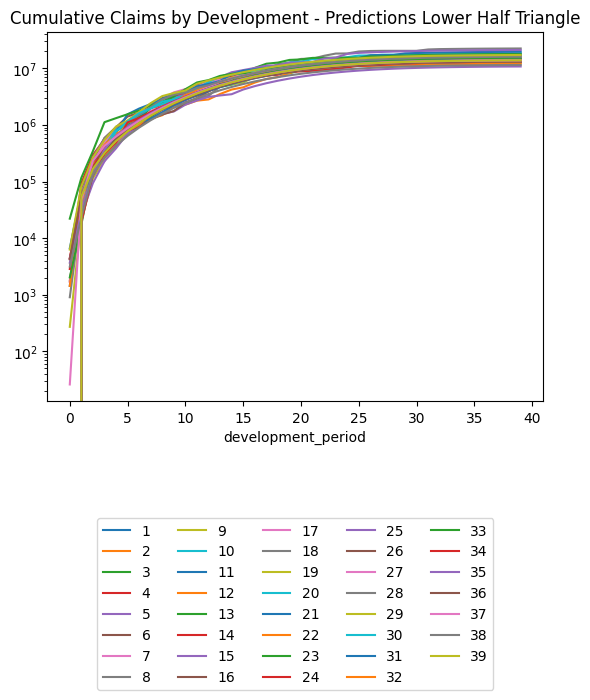

In [44]:
dat_nn_pred, triangle_nn_spline = make_pred_set_and_triangle(model_spline_net, dat.loc[dat.train_ind == 1], dat.loc[dat.train_ind == 0])

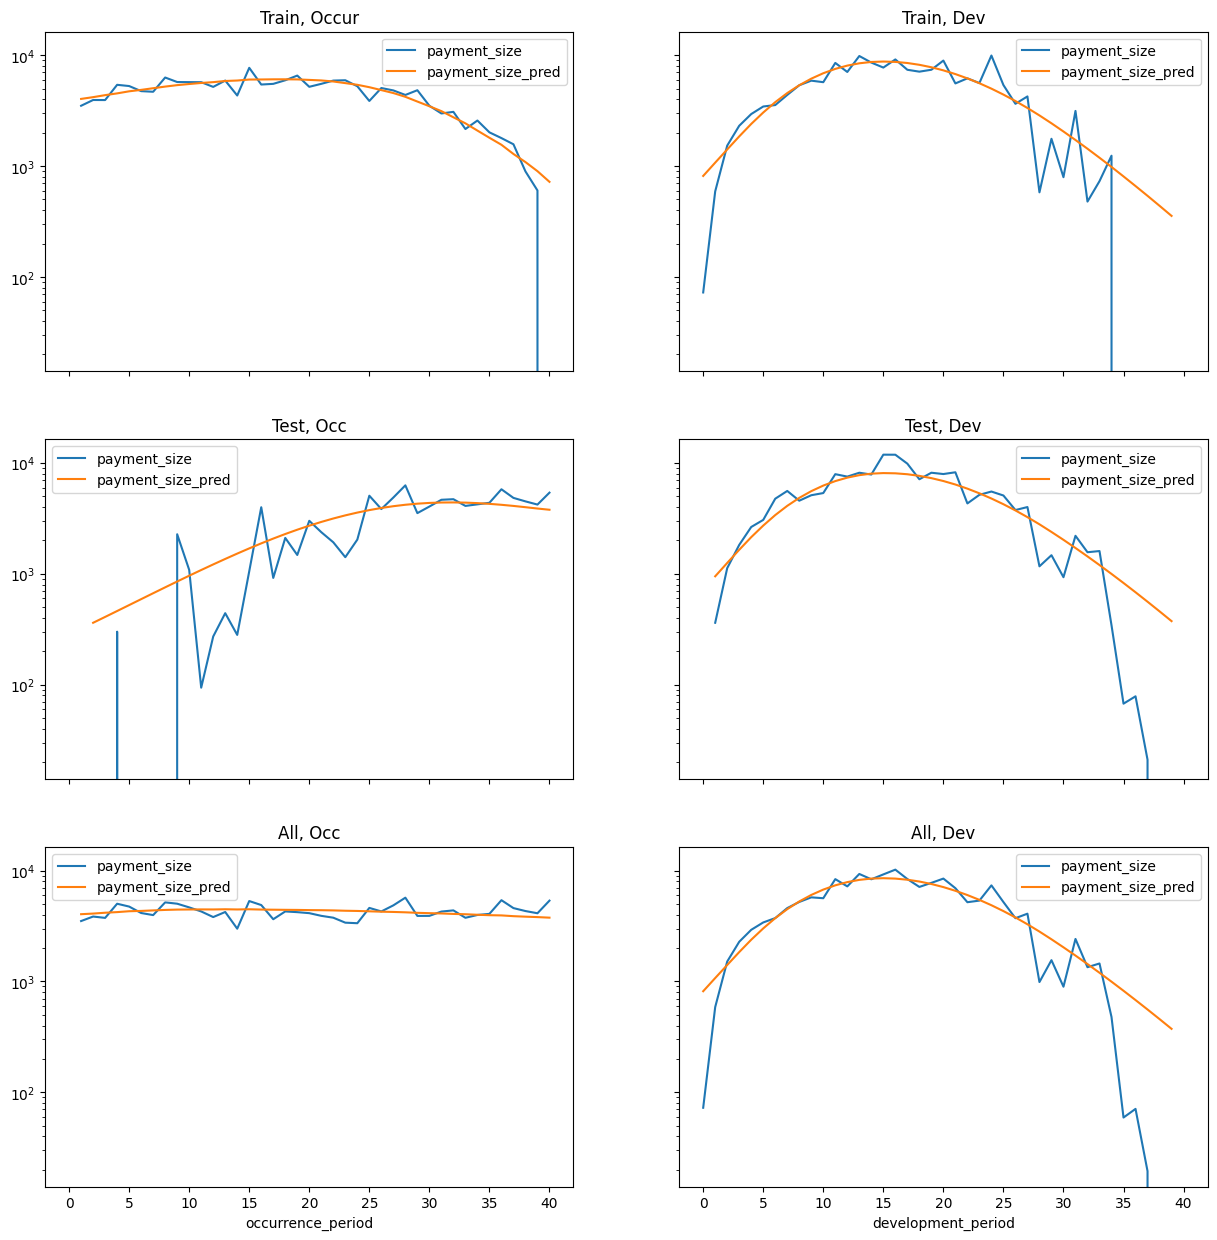

In [45]:
make_model_subplots(model_spline_net, dat)

## Mixture Density Network
-----

In *Probabilistic Forecasting with Neural Networks Applied to Loss Reserving* [2], Muhammed Al-Mudafer introduced the idea of a "ResMDN" model which produces results similar to a more advanced stochastic chain ladder that has a deep learning component. The ResMDN extends the one-hot GLM into a ResNet, then predicts a full probability distribution using [Mixture Density Networks](https://towardsdatascience.com/a-hitchhikers-guide-to-mixture-density-networks-76b435826cca). 

We note that our "SplineNet" architecture appears to compare well to the one-hot GLM, since it fits curves to the features rather than one-hot encoding each occurrence and development period. So we will add MDN output and loss build on the "SplineNet" model instead of the GLM. 

### Distribution Assumption

The Mixture Density Network models the output as being a mixture of normal distributions. However, it becomes quickly apparent the normal distribution is not a good fit for individual claims data. The SPLICE claim payments, like typical insurance claims data, is heavily skewed:

(array([1.3897e+04, 1.7400e+02, 4.3000e+01, 2.1000e+01, 4.0000e+00,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.54747553e+01, 2.79050656e+05, 5.58085875e+05, 8.37121062e+05,
        1.11615625e+06, 1.39519150e+06, 1.67422662e+06, 1.95326175e+06,
        2.23229700e+06, 2.51133225e+06, 2.79036750e+06]),
 <BarContainer object of 10 artists>)

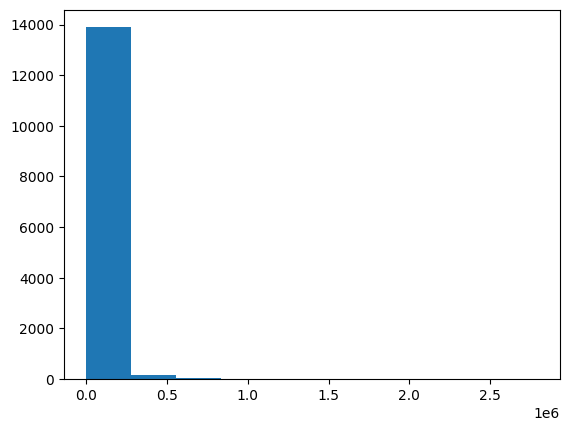

In [46]:
plt.hist((dat.loc[(dat.train_ind == 1) & (dat.payment_size > 0), ["payment_size"]]))

Given the skew, plot log-transformed histogram:

(array([  25.,   29.,   71., 1224., 6426., 4021., 1333.,  731.,  253.,
          32.]),
 array([ 2.73921013,  3.94945765,  5.15970516,  6.3699522 ,  7.58019972,
         8.79044724, 10.00069427, 11.21094227, 12.42118931, 13.63143635,
        14.84168434]),
 <BarContainer object of 10 artists>)

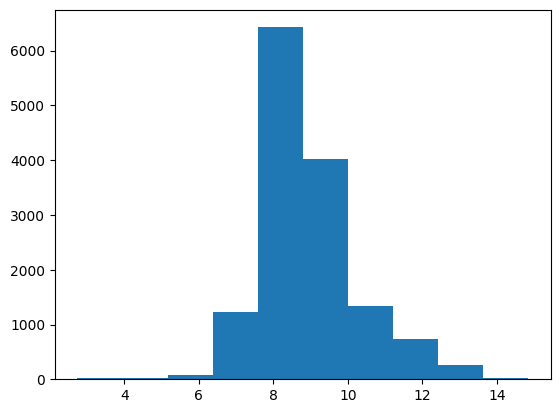

In [47]:
plt.hist(np.log(dat.loc[(dat.train_ind == 1) & (dat.payment_size > 0), ["payment_size"]]))

It is clear from the plot that the log-normal distribution should be more appropriate than the normal for the distribution of payments in individual claims data. 

Consequently, we propose an adjusted log-normal MDN approach, which also takes into account the observations with zero payments:
 1. Calculate point estimates as $exp(\mu + \sigma^2/2)$, being mean of a log-normal,
 2. Apply loss to $log(y + \epsilon)$ rather than $y$ (with $\epsilon$ being some small value),
 3. Use $\sqrt ReLU$ + $\epsilon$ as the activation for $\sigma$ rather than $exp$.
 
This design, which appears to be novel, addresses two numerical stability challenges from having observations with zero payment:
 * Mean of the zero records is zero. This means typically, with a log-link $log(0), \rightarrow -\infty$. Adding the $\epsilon$ value avoids this.
 * $\sigma$ of the zero records is also zero. Typically, MDNs use an exponential or ELU activation for $sigma$, so again $log(0) \rightarrow -\infty$. Use of ReLU allows $sigma$ to be extremely small without numerical instability. 
 * Apply square root $\sigma$ to avoid any unintended quadratic effects to $exp(\mu + \sigma^2/2)$

### Loss function

Our adjusted Mixture Density Networks loss function is as follows. This utilises the `torch.logsumexp` function for the best numerical stability.

In [48]:
SMALL = 1e-7

def log_mdn_loss_fn(y_dists, y):
    y = torch.log(y + SMALL)        # log(y) ~ Normal
    alpha, mu, sigma = y_dists
    m = torch.distributions.Normal(loc=mu, scale=sigma) # Normal
    loss = -torch.logsumexp(m.log_prob(y) + torch.log(alpha + 1e-15), dim=-1)
    return torch.mean(loss) # Average over dataset

Meanwhile it is possible to get similar result as the point estimate MDN model using this loss function, which calculates the Poisson NLL loss:

In [49]:
def point_poisson_nll_loss(y_dists, y):
    alpha, mu, sigma = y_dists
    yhat = torch.sum(alpha * torch.exp(mu + 0.5 * sigma * sigma), dim=1).unsqueeze(1)
    assert yhat.size() == y.size()
    return F.poisson_nll_loss(yhat, y, log_input=False, full=False, eps=1e-8, reduction='mean')

It is possible to train for both losses by summing both losses as per below. This seems to provide a more reliably stable result for the point estimates than relying on solely the MDN loss, however we found the variational predictions became less accurate so we abandoned this approach.

In [50]:
two_loss = lambda y_dists, y: log_mdn_loss_fn(y_dists, y) + point_poisson_nll_loss(y_dists, y)

### Architecture

We take the "SplineNet" architecture presented earlier and use one to provide the point estimates, exactly as before, then apply a second SplineNet module to predict the distributional assumptions. The $\alpha$, $\mu$, and $\sigma$ outputs are calculated in a way such that: 
 * $\mu$ is calculated with scaling factors to ensure the mean, being $\Sigma^n_1 (\alpha \times exp(\mu + 0.5 \sigma^2))$, is always equal to the point estimate output,
 * $\sigma$ is calculated using ReLU and square root transformation as described above.

We found that whilst optimising for the MDN loss function was often effective, there were training runs when the MSE and point estimates would behave oddly during the training process. Since the estimate for the mean comes directly from a SplineNet sub-module, it is possible to use the previously trained model and weights. This would avoid another source of instability. An interesting observation with this is that a similar approach could be used to add distributional predictions to any point estimate model. 

In [51]:
class LognormalSplineMDN(nn.Module):  # V3
    # Define the parameters in __init__
    def __init__(
        self,      
        n_input,                                           # number of inputs
        n_output,                                          # number of outputs
        init_bias,                                         # init mean value to speed up convergence
        init_extra,                                        # init mean value to speed up convergence
        n_hidden,                                          # hidden layer size
        dropout,                                           # dropout percentage 
        n_gaussians,                                       # number of gaussians
        interactions=0.0,                                      # 0.0 - 1.0 whether to apply interactions
        point_estimates=False,
        **kwargs
    ): 
        assert n_output==1, "Not implemented for n_output > 1"

        # Initialise
        super(LognormalSplineMDN, self).__init__()
        self.n_gaussians = n_gaussians
        self.point_estimates = point_estimates
        self.point_estimator = SplineNet(
            n_output=1, init_bias=init_bias, inverse_of_link_fn=lambda x: x,
            # the other parameters are passed straight through:
            n_input=n_input, n_hidden=n_hidden, dropout=dropout, interactions=interactions, 
        )
        self.point_estimator.load_state_dict(init_extra[0])
        self.point_estimator.requires_grad_(False)

        self.distribution_estimator = SplineNet(
            n_output=3 * n_gaussians, init_bias=init_extra[1], inverse_of_link_fn=lambda x: x,
            # the other parameters are passed straight through:
            n_input=n_input, n_hidden=n_hidden, dropout=dropout, interactions=interactions, 
        )        

    # The forward function defines how you get y from X.
    def forward(self, x):
        predictor = self.point_estimator(x)

        if self.point_estimates:        
            return torch.exp(predictor)
        else:
                alpha0, median0, sigma0 = torch.split(
                    self.distribution_estimator(x), 
                    [self.n_gaussians, self.n_gaussians, self.n_gaussians], 
                    dim=1
                )

                # Alpha: Softmax so it sums to 100%
                alpha = F.softmax(alpha0, dim=-1)
                log_mix_prob = torch.log(alpha + 1e-15)

                # Sigma: ReLU with minimum of SMALL
                s2 = F.relu(sigma0) + SMALL
                sigma = torch.sqrt(s2)

                # Linear predictors. sum of alpha * exp(mdn_lin_preds) = exp(lin_pred)
                # Adjust to make sure they equate.
                log_scaling_factor = torch.logsumexp(log_mix_prob + median0, dim=-1).unsqueeze(1) - predictor

                # Mean is exp(mu + 0.5 * sigma^2)
                mu = median0 - log_scaling_factor - 0.5 * s2                                               

                return alpha, mu, sigma
                

### Number of distributions

We will make a generic assumption for three distributions being:
 1. Zeroes (most records are zero payment at this granular claim/period level),
 2. Minor payments, and
 3. Major payments

More distributions can be used e.g. when there are several peril categories, but assuming the presence of these three seems generally reasonable.

### Initialisation

We will need to initialise our model intelligently for numerical stability and faster convergence.

For the initial values, we will assume large claims are 5% of the claims and 10x larger than the average, the model will train this to the right levels.

In [52]:
percent_zeroes = (dat.loc[(dat.train_ind == 1) & (dat.payment_size < 0.001)].claim_no.count()) / (dat.loc[(dat.train_ind == 1)].claim_no.count())
mean_log_payment = np.log(dat.loc[(dat.train_ind == 1) & (dat.payment_size > 0), ["payment_size"]].values).mean()

mean_payment_encl_zeroes = dat.loc[(dat.train_ind == 1) & (dat.payment_size > 0), ["payment_size"]].values.mean()
mean_payment_incl_zeroes = dat.loc[(dat.train_ind == 1), ["payment_size"]].values.mean()

sigma_payment = np.sqrt((np.log(mean_payment_encl_zeroes) - mean_log_payment) * 2)

mdn_init_bias = np.array([
    # Alpha
    np.log(percent_zeroes),
    np.log((1-percent_zeroes) * 0.95),
    np.log((1-percent_zeroes) * 0.05),
    # Mu
    np.log(SMALL),
    mean_log_payment + np.log(0.526),
    mean_log_payment + np.log(10),
    # Sigma
    -1.0,
    sigma_payment,
    sigma_payment,
], dtype=np.float32)

{
    "Percent of records zeroes": percent_zeroes, 
    "Alpha bias after softmax": F.softmax(torch.tensor(mdn_init_bias[0:3]),dim=-1),  # This should return the correct zero percentage
    "Mean log payment": mean_log_payment, 
    "Sigma (non-zero claims)": sigma_payment,
    "Mean payment (excl zeroes)": mean_payment_encl_zeroes,
    "Mean Payment (incl zeroes)": mean_payment_incl_zeroes
}

{'Percent of records zeroes': np.float64(0.8055857168382423),
 'Alpha bias after softmax': tensor([0.8056, 0.1847, 0.0097]),
 'Mean log payment': np.float32(8.914234),
 'Sigma (non-zero claims)': np.float32(1.582276),
 'Mean payment (excl zeroes)': np.float32(26004.695),
 'Mean Payment (incl zeroes)': np.float32(5055.684)}

### Model fitting
Fit the MDN below, with some validation checks that the module and initialisation has been performed correctly. 

In [53]:
model_spline_mdn = Pipeline(
    steps=[
        ("keep", ColumnKeeper(["occurrence_period", "development_period"])),   # both
        ('zero_to_one', MinMaxScaler()),       # Important! Standardize deep learning inputs.
        ("model", TabularNetRegressor(
                LognormalSplineMDN, 
                n_hidden=20, 
                max_iter=mdn_iter, 
                max_lr=0.025, 
                n_gaussians=3,
                criterion=log_mdn_loss_fn,
                init_extra=[model_spline_net["model"].module_.state_dict(), mdn_init_bias],
                # clip_value=3.0,
                keep_best_model=True  # Noting numerical stability, keep the best model instead
            )
        )
    ]
)



In [54]:
# Fit model
model_spline_mdn.fit(
    dat.loc[dat.train_ind == 1],
    dat.loc[dat.train_ind == 1, ["payment_size"]]
)

Train RMSE:  39297.81640625  Train Loss:  157.18670654296875
Train RMSE:  39297.81640625  Train Loss:  42.03156661987305
Train RMSE:  39297.81640625  Train Loss:  4.981094837188721
Train RMSE:  39297.81640625  Train Loss:  2.6419308185577393
Train RMSE:  39297.81640625  Train Loss:  2.5941169261932373
Train RMSE:  39297.81640625  Train Loss:  2.581418752670288
Train RMSE:  39297.81640625  Train Loss:  2.570692300796509
Train RMSE:  39297.81640625  Train Loss:  2.5627174377441406
Train RMSE:  39297.81640625  Train Loss:  2.5578832626342773
Train RMSE:  39297.81640625  Train Loss:  2.555860996246338


Pipeline(steps=[('keep',
                 ColumnKeeper(cols=['occurrence_period',
                                    'development_period'])),
                ('zero_to_one', MinMaxScaler()),
                ('model',
                 TabularNetRegressor(criterion=<function log_mdn_loss_fn at 0x7f01954c9800>,
                                     init_extra=[OrderedDict([('interactions',
                                                               tensor(-11.0718)),
                                                              ('oneways.0.weight',
                                                               tensor([[-0.1602],
        [-0.7674],
        [ 1.5544],
        [ 1.4252],
        [ 1.4798],
        [ 0.6202],
        [-1.0910...
                                                               tensor([[-2.0555, -0.7871, -1.3509,  0.1674, -1.6335,  0.0742, -0.2958, -1.1064,
         -0.5438, -0.4183, -0.0430, -1.2207, -0.6123, -0.5721, -1.3430, -1.9283,
         -1.0335,  0.5729, -0.5370, -0.9197]]))]),
                                                 array([ -0.21618567,  -1.6890572 ,  -4.6334963 , -16.118095  ,
         8.27178   ,  11.216819  ,  -1.        ,   1.582276  ,
         1.582276  ], dtype=float32)],
                                     keep_best_model=True, max_iter=500,
                                     max_lr=0.025,
                                     module=<class '__main__.LognormalSplineMDN'>))])

### Check point estimates:

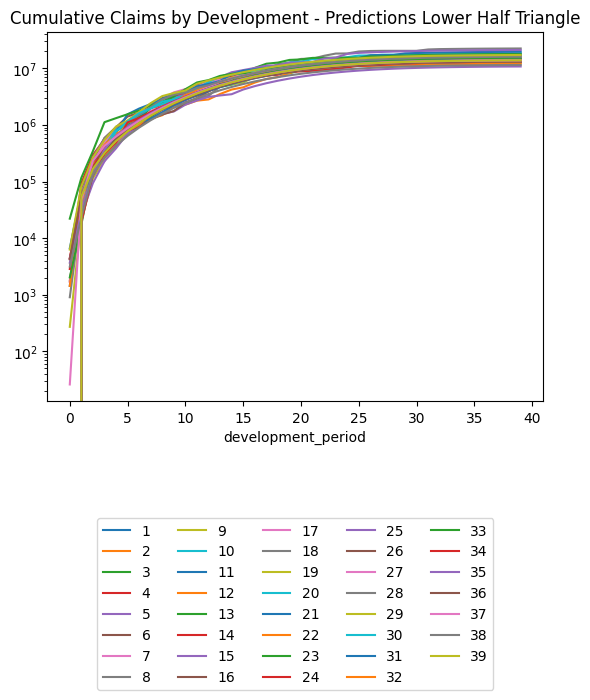

In [55]:
# Lower half triangle predictions
dat_mdn_pred, triangle_mdn_spline = make_pred_set_and_triangle(model_spline_mdn, dat.loc[dat.train_ind == 1], dat.loc[dat.train_ind == 0])

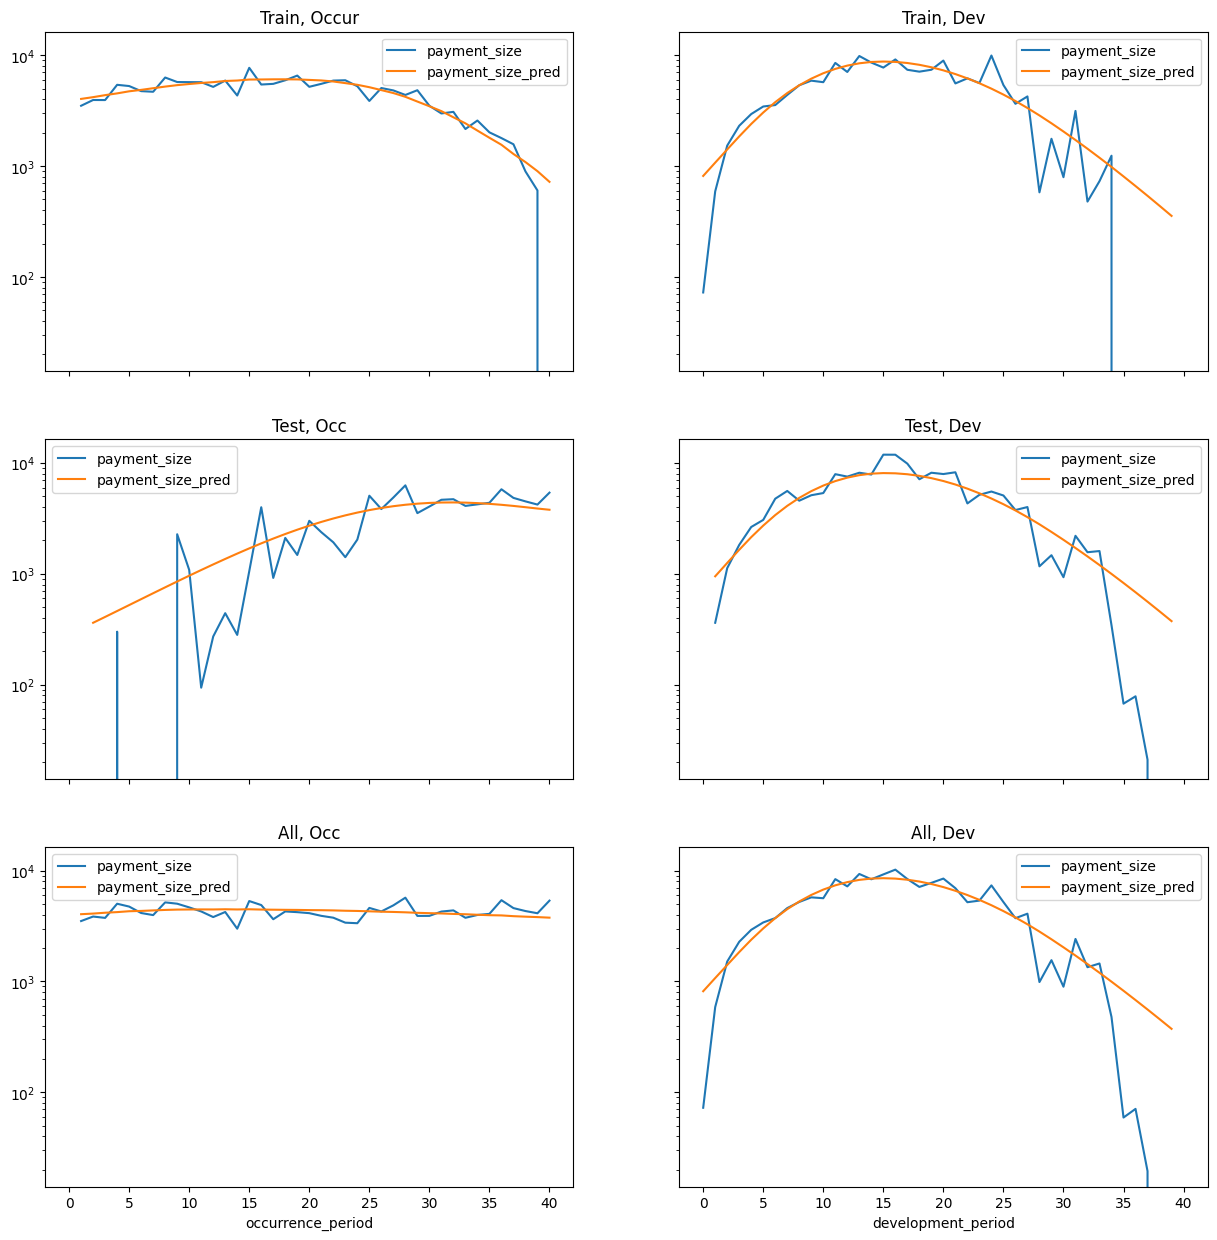

In [56]:
make_model_subplots(model_spline_mdn, dat)

### Check probabilistic predictions

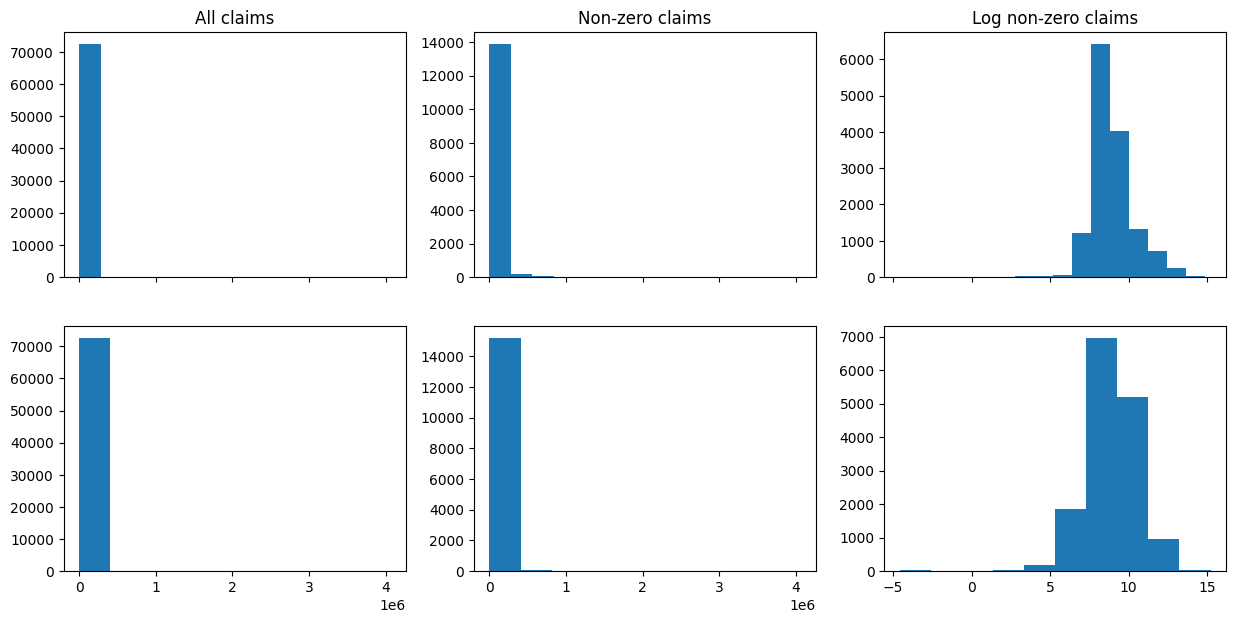

In [57]:
def make_distribution_subplots(model):
    fig, axes = plt.subplots(2, 3, sharex='col', sharey=False, figsize=(15, 7))

    axes[0,0].title.set_text("All claims")
    axes[0,1].title.set_text("Non-zero claims")
    axes[0,2].title.set_text("Log non-zero claims")

    axes[0,0].hist((dat.loc[(dat.train_ind == 1), ["payment_size"]]))
    axes[0,1].hist((dat.loc[(dat.train_ind == 1) & (dat.payment_size > 0), ["payment_size"]]))
    axes[0,2].hist(np.log(dat.loc[(dat.train_ind == 1) & (dat.payment_size > 0), ["payment_size"]]))

    alpha, mu, sigma = model.predict(dat.loc[(dat.train_ind == 1)], point_estimates=False)

    categorical = torch.distributions.Categorical(alpha)
    alpha_sample = categorical.sample().unsqueeze(1)
    n_01 = Variable(sigma.data.new(sigma.size(0), 1).normal_())
    sample = mu.gather(1, alpha_sample) + n_01 * sigma.gather(1, alpha_sample) 
    sample = np.exp(sample.cpu().detach().numpy())

    axes[1,0].hist(sample)
    axes[1,1].hist(sample[sample > 0.01])
    axes[1,2].hist(np.log(sample[sample > 0.01]))

make_distribution_subplots(model_spline_mdn)

We should hopefully see a resemblance between the distributions. 

## Cross Validation and Hyperparameter Search
-----

### Rolling Origin Validation

The problem with using a random split for cross validation is that records may pertain to the same time period, but we are predicting records that are completely out of the time period.

It's fairly simple to implement a payment period based cross validation using ``PredefinedSplit``:

``ps = PredefinedSplit(nn_train.cv_ind)``

However, this did not lead to good quality results in our testing, so we will implement the rolling origin validation.

In [58]:
class RollingOriginSplit:
    def __init__(self, start_cut, n_splits):
        self.start_cut = start_cut
        self.n_splits = n_splits

    def split(self, X=None, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Payment period for splits
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        quantiles = pd.qcut(groups, self.start_cut + self.n_splits + 1, labels=False)

        for split_value in range(self.start_cut, self.start_cut + self.n_splits):
            yield np.where(quantiles <= split_value)[0], np.where(quantiles == split_value + 1)[0]

ps = RollingOriginSplit(5, 5).split(groups=dat.loc[dat.train_ind == 1].payment_period)
for tr, te in ps:
    print(len(tr), len(te), len(tr)+ len(te) )

40933 5685 46618
46618 9142 55760
55760 6543 62303
62303 6883 69186
69186 3571 72757


In [59]:
len(dat.loc[dat.train_ind == 1].index)

72757

### Random Search:

 Use Random Search - noting comments in https://github.com/google-research/tuning_playbook#a-scientific-approach-to-improving-model-performance about the limited benefits of Bayesian Search. 

 * l1 penalty, weight decay: Cap at 0.1 to avoid underfitting problems.
 * dropout: try higher percentages. 
 * number of neurons in hidden layer: keep relatively small, the data is not that complex
 * interactions: test with and without.
 * max iter, max lr: - keep at these values or similar to get something close to convergence in a short number of iterations

In [60]:
parameters_nn = {
    "l1_penalty": [0.0, 0.001, 0.01, 0.1],
    "weight_decay": [0.0, 0.001, 0.01, 0.1],
    "n_hidden": [5, 10, 20],
    # "interactions": [0.0, 0.25, 0.5, 0.75, 1.0],
    "dropout": [0, 0.25, 0.5],
    "max_iter": [nn_cv_iter],
    "max_lr": [0.05],
    "verbose": [0],
    "clip_value": [None, 3.0],
    "keep_best_model": [True] 
}

model_NN_CV = Pipeline(
    steps=[
        ("keep", ColumnKeeper(["occurrence_period", "development_period"])),  
        ('zero_to_one', MinMaxScaler()),       # Important! Standardize deep learning inputs.
        ("model", RandomizedSearchCV(
            TabularNetRegressor(SplineNet),
            parameters_nn,
            n_jobs=4,  # Run in parallel (small model)
            n_iter=cv_runs, # Models train slowly, so try only a few models
            cv=RollingOriginSplit(5,5).split(groups=dat.payment_period.loc[dat.train_ind == 1]),
            random_state=42,
            refit=False
        )),
    ]
)

model_NN_CV.fit(
    dat.loc[dat.train_ind == 1],
    dat.loc[dat.train_ind == 1, ["payment_size"]]
)


bst_nn = model_NN_CV["model"].best_params_
print("best parameters:", bst_nn)

cv_results = pd.DataFrame(model_NN_CV["model"].cv_results_)

# Refit best model for longer iters
model_NN_CV = Pipeline(
    steps=[
        ("keep", ColumnKeeper(["occurrence_period", "development_period"])),  
        ('zero_to_one', MinMaxScaler()),       # Important! Standardize deep learning inputs.
        ("model", TabularNetRegressor(
                SplineNet, 
                l1_penalty=bst_nn["l1_penalty"],
                weight_decay=bst_nn["weight_decay"],  
                n_hidden=bst_nn["n_hidden"],   
                # interactions=bst_nn["interactions"],
                dropout=bst_nn["dropout"],                             
                max_iter=nn_iter, 
                max_lr=bst_nn["max_lr"], 
            )
        )
    ]
)
model_NN_CV.fit(
    dat.loc[dat.train_ind == 1],
    dat.loc[dat.train_ind == 1, ["payment_size"]]
)

best parameters: {'weight_decay': 0.01, 'verbose': 0, 'n_hidden': 10, 'max_lr': 0.05, 'max_iter': 100, 'l1_penalty': 0.0, 'keep_best_model': True, 'dropout': 0.5, 'clip_value': None}
Train RMSE:  39387.58203125  Train Loss:  -38060.546875
Train RMSE:  39381.64453125  Train Loss:  -38122.15234375
Train RMSE:  39302.921875  Train Loss:  -38796.5078125
Train RMSE:  39298.74609375  Train Loss:  -38856.1015625
Train RMSE:  39298.60546875  Train Loss:  -38875.6171875
Train RMSE:  39298.5  Train Loss:  -38877.0546875
Train RMSE:  39298.39453125  Train Loss:  -38878.55859375
Train RMSE:  39298.26171875  Train Loss:  -38880.26171875
Train RMSE:  39298.15625  Train Loss:  -38881.73046875
Train RMSE:  39298.109375  Train Loss:  -38882.39453125


Pipeline(steps=[('keep',
                 ColumnKeeper(cols=['occurrence_period',
                                    'development_period'])),
                ('zero_to_one', MinMaxScaler()),
                ('model',
                 TabularNetRegressor(dropout=0.5, max_iter=500, max_lr=0.05,
                                     module=<class '__main__.SplineNet'>,
                                     n_hidden=10, weight_decay=0.01))])

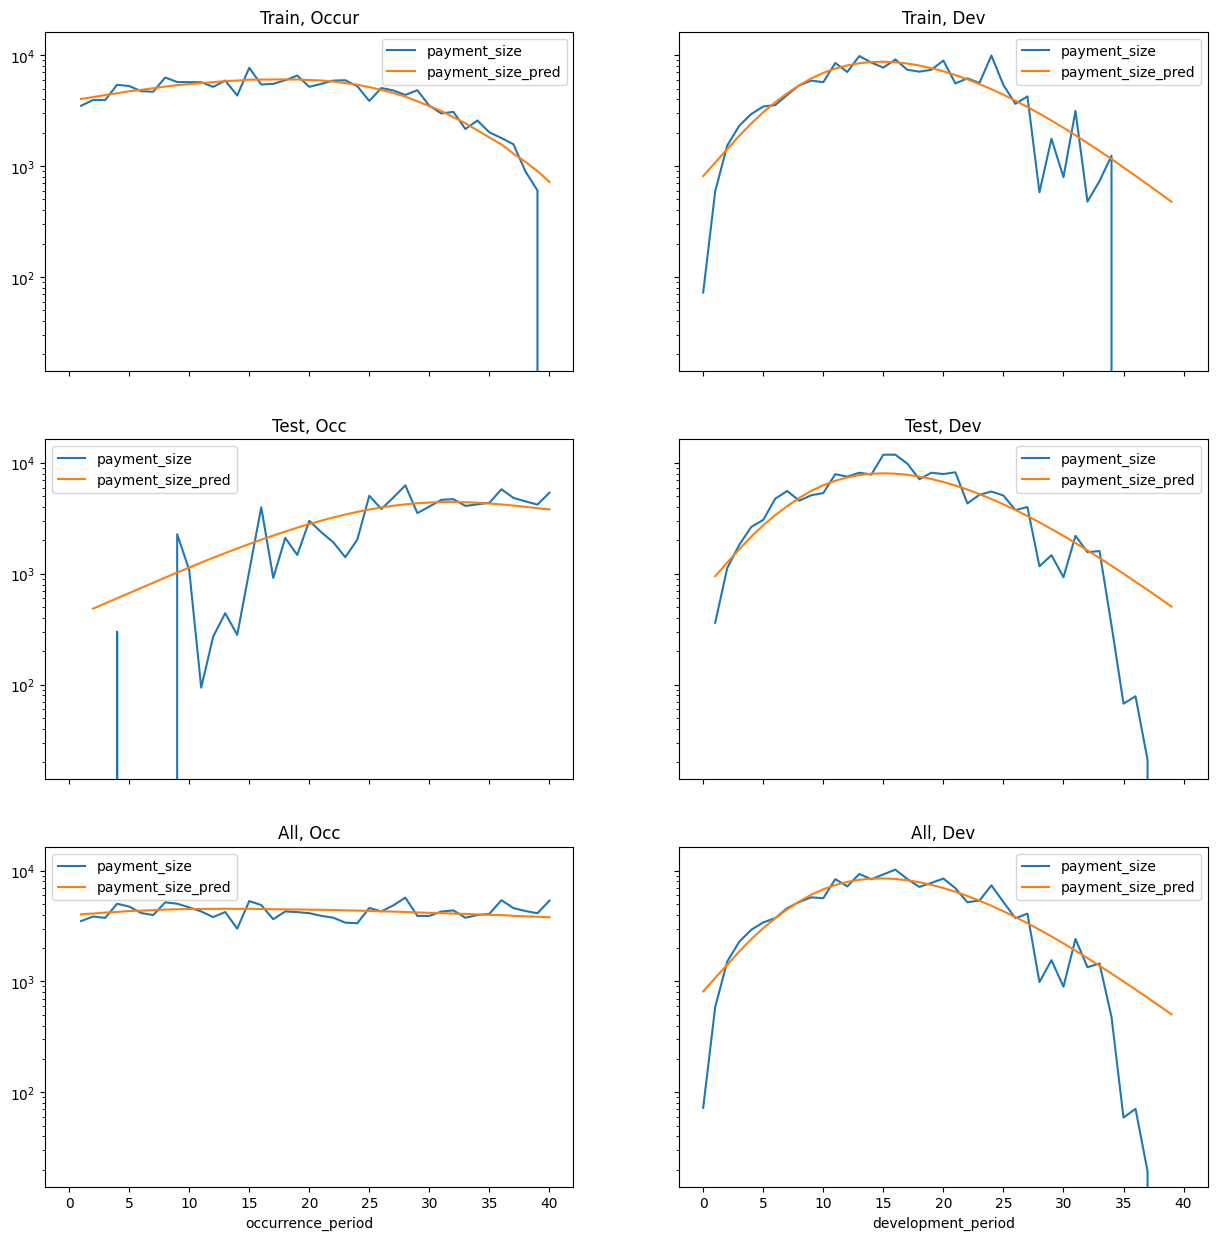

In [61]:
make_model_subplots(model_NN_CV, dat)

More predictions and diagnostics

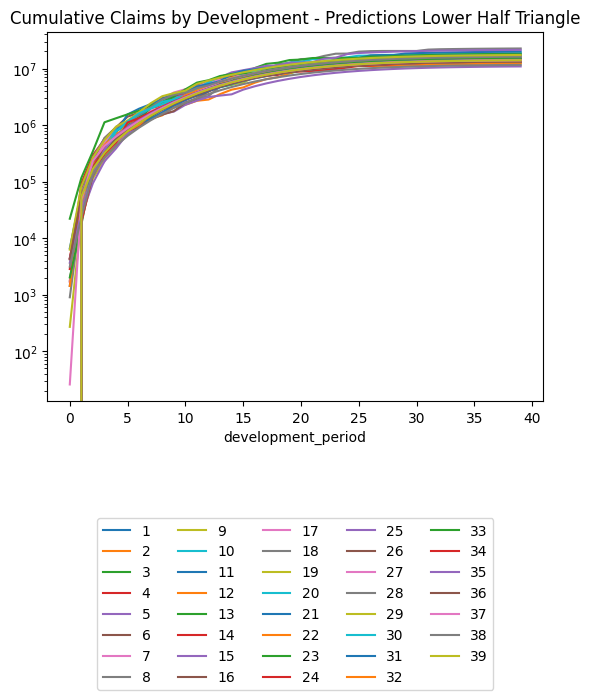

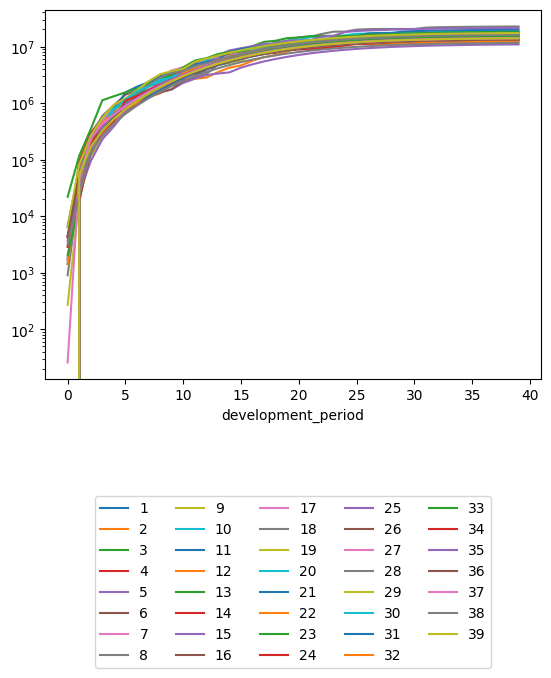

In [62]:
dat_nn_pred, triangle_nn_cv = make_pred_set_and_triangle(model_NN_CV, dat.loc[dat.train_ind == 1], dat.loc[dat.train_ind == 0])

(triangle_nn_cv
    .loc[lambda df: df.occurrence_period != cutoff]
    .pivot(index = "development_period", columns = "occurrence_period", values = "payment_size_cumulative")
    .plot(logy=True)
)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.8), ncol=5)

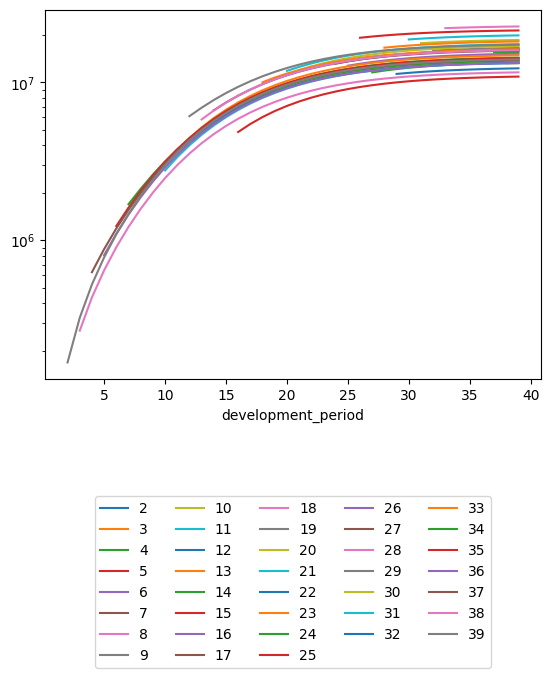

In [63]:
(dat_nn_pred.loc[lambda df: ~df.train_ind]
    .groupby(["occurrence_period", "development_period", "payment_period"], as_index=False)
    .agg({"payment_size_cumulative": "sum", "payment_size": "sum"})
    .sort_values(by=["occurrence_period", "development_period"])
    .loc[lambda df: df.occurrence_period != cutoff]
    .pivot(index = "development_period", columns = "occurrence_period", values = "payment_size_cumulative")
    .plot(logy=True)
)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.8), ncol=5)

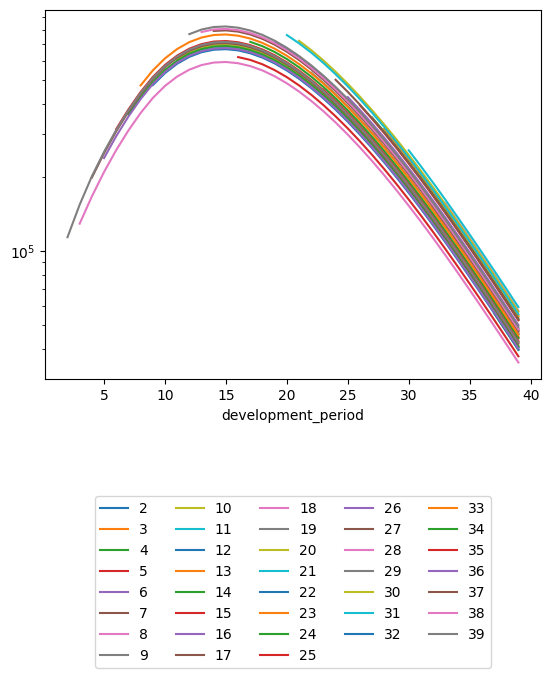

In [64]:
(dat_nn_pred.loc[lambda df: ~df.train_ind]
    .groupby(["occurrence_period", "development_period", "payment_period"], as_index=False)
    .agg({"payment_size_cumulative": "sum", "payment_size": "sum"})
    .sort_values(by=["occurrence_period", "development_period"])
    .loc[lambda df: df.occurrence_period != cutoff]
    .pivot(index = "development_period", columns = "occurrence_period", values = "payment_size")
    .plot(logy=True)
)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.8), ncol=5)

In [65]:
(triangle_nn_cv.pivot(index = "occurrence_period", columns = "development_period", values = "payment_size_cumulative") - 
triangle_cl.pivot(index = "occurrence_period", columns = "development_period", values = "payment_size_cumulative"))

development_period   0         1          2           3           4   \
occurrence_period                                                      
1                  0.00      0.00       0.00        0.00        0.00   
2                  0.00      0.00       0.00        0.02        0.00   
3                  0.00      0.00       0.00        0.03        0.00   
4                  0.00      0.00       0.00       -0.03        0.00   
5                  0.00      0.00       0.00        0.00        0.00   
6                  0.00      0.00       0.00        0.00        0.00   
7                  0.00      0.00       0.00        0.00        0.00   
8                  0.00      0.00       0.00        0.00        0.00   
9                  0.00      0.00       0.00        0.00        0.00   
10                 0.00      0.00       0.00        0.00        0.00   
11                 0.00      0.00       0.00        0.00        0.00   
12                 0.00      0.00       0.00        0.00        0.00   
13                 0.00      0.00       0.00        0.00        0.00   
14                 0.00      0.00       0.00        0.00        0.00   
15                 0.00      0.00       0.00        0.00        0.00   
16                 0.00      0.00       0.00        0.00        0.00   
17                 0.00      0.00       0.00        0.00        0.00   
18                 0.00      0.00       0.00        0.03        0.00   
19                 0.00      0.00       0.00        0.00        0.00   
20                 0.00      0.00       0.00        0.00        0.00   
21                 0.00      0.00       0.00        0.00        0.00   
22                 0.00      0.00       0.00        0.00        0.00   
23                 0.00      0.00       0.00        0.00        0.00   
24                 0.00      0.00       0.00        0.03        0.00   
25                 0.00      0.00       0.00        0.00        0.00   
26                 0.00      0.00       0.00        0.00        0.00   
27                 0.00      0.00       0.00        0.00        0.00   
28                 0.00      0.00       0.00        0.00        0.00   
29                 0.00      0.00       0.00        0.00        0.00   
30                 0.00      0.00       0.00        0.00        0.00   
31                 0.00      0.00       0.00        0.03       -0.06   
32                 0.00      0.00       0.00        0.00        0.00   
33                 0.00      0.00       0.00        0.00        0.00   
34                 0.00      0.00       0.00        0.00        0.00   
35                 0.00      0.00       0.00        0.00        0.00   
36                 0.00      0.00       0.00        0.03        0.00   
37                 0.00      0.00       0.00        0.00  -98,767.69   
38                 0.00      0.00       0.00  -33,705.97  -76,433.12   
39                 0.00      0.00 -51,703.62 -157,120.88 -289,819.94   
40                 0.00 57,015.52 154,823.38  289,905.03  464,322.72   

development_period          5           6            7            8   \
occurrence_period                                                      
1                         0.00        0.00         0.00         0.12   
2                         0.00        0.00         0.00         0.00   
3                         0.00        0.00         0.00         0.00   
4                         0.00        0.00         0.00         0.00   
5                         0.00        0.00         0.00         0.00   
6                         0.00        0.00         0.00         0.00   
7                         0.00        0.00         0.00         0.00   
8                         0.00        0.00         0.00         0.00   
9                         0.00        0.00         0.00         0.00   
10                        0.00        0.00         0.00         0.00   
11                        0.00        0.00         0.00         0.00   
12                        0.00        0

In [66]:
# MSE / 10^12
# Exclude occurrence period == 40 since there's no data there at cutoff
np.sum((
    triangle_nn_cv.loc[lambda df: df.occurrence_period != cutoff].payment_size_cumulative.values - 
    triangle.loc[lambda df: df.occurrence_period != cutoff].payment_size_cumulative.values
)**2)/10**12

np.float32(2358.4197)

## Leveraging individual data
-----

So far we have only used Occurrence Period and Development Period, not any individual claim features. Does the dataset enable us to improve predictions by using claims level information?

First let us look at the features.

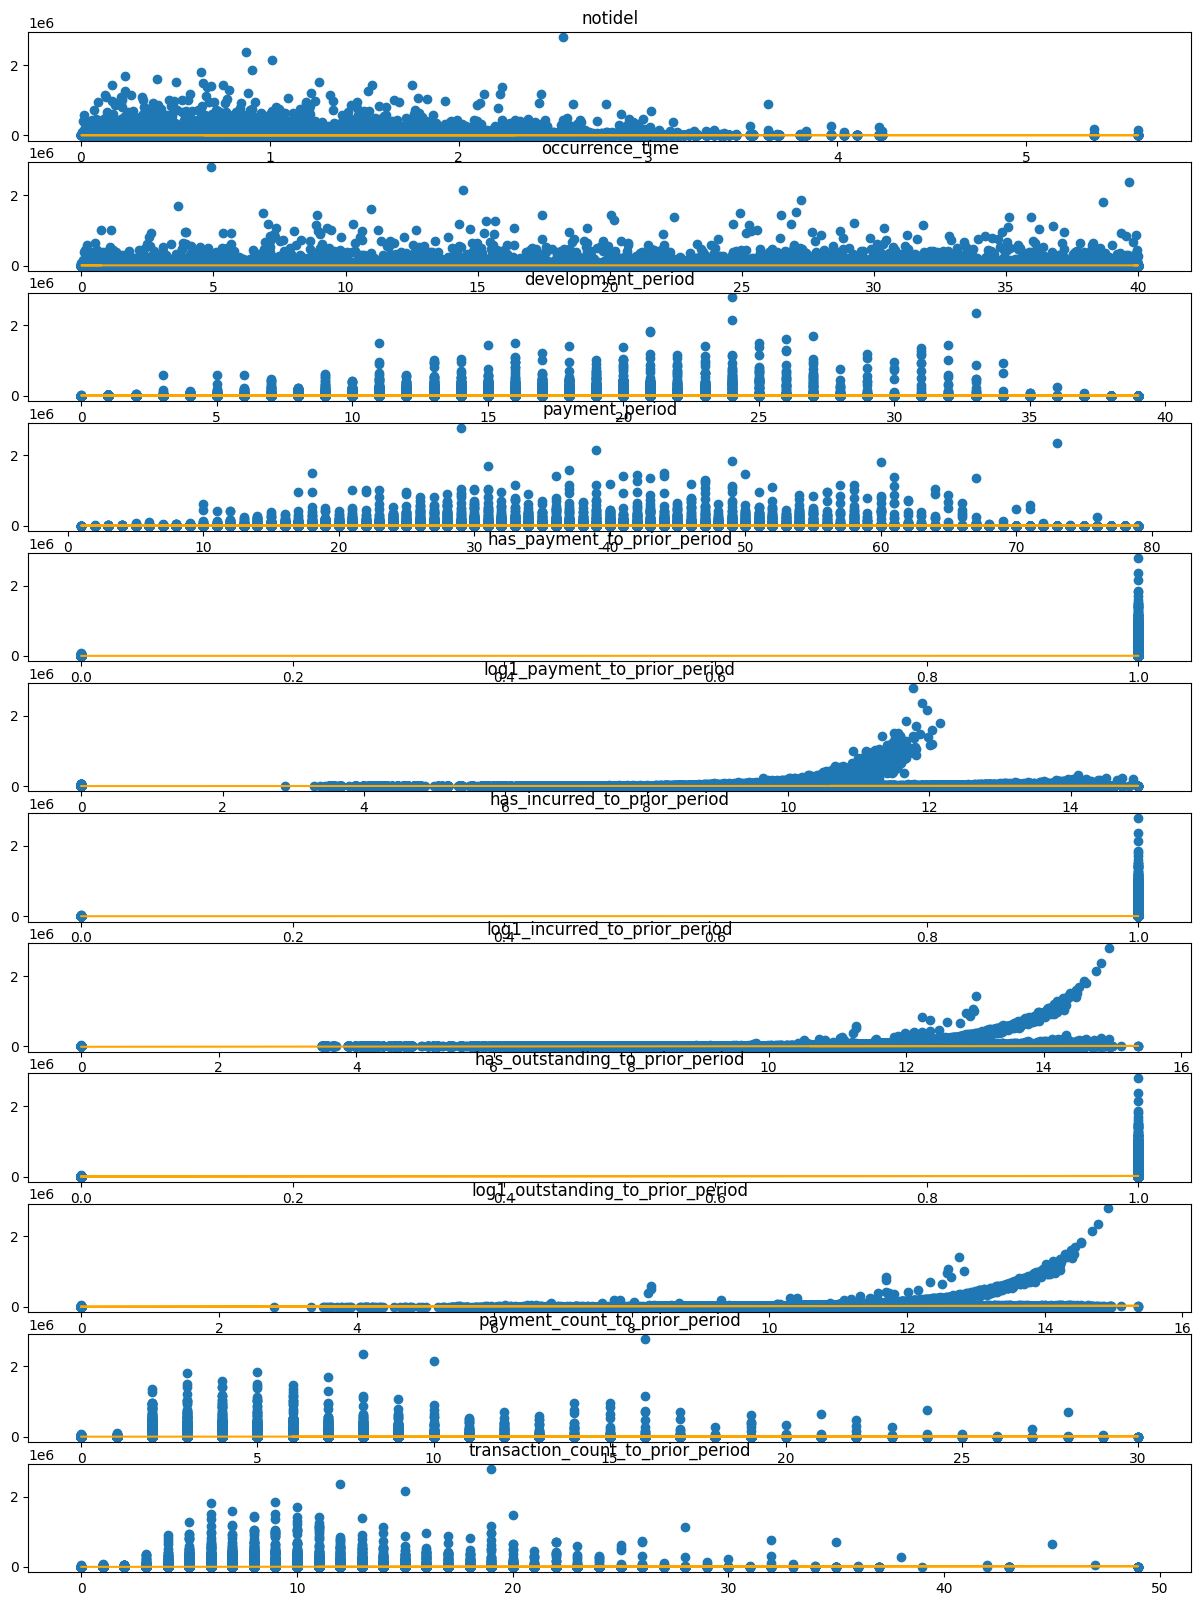

In [67]:

fig, axs = plt.subplots(len(data_cols), sharex=False, sharey=True, figsize=(15, 20))

for i, f in enumerate(data_cols):
    axs[i].scatter(dat[f], dat["payment_size"])
    m, b = np.polyfit(dat[f], dat["payment_size"], 1)
    axs[i].plot(dat[f], m*dat[f]+b,color='orange')
    axs[i].set_title(f)

Results are very noisy, so look at data with features in a decile format:

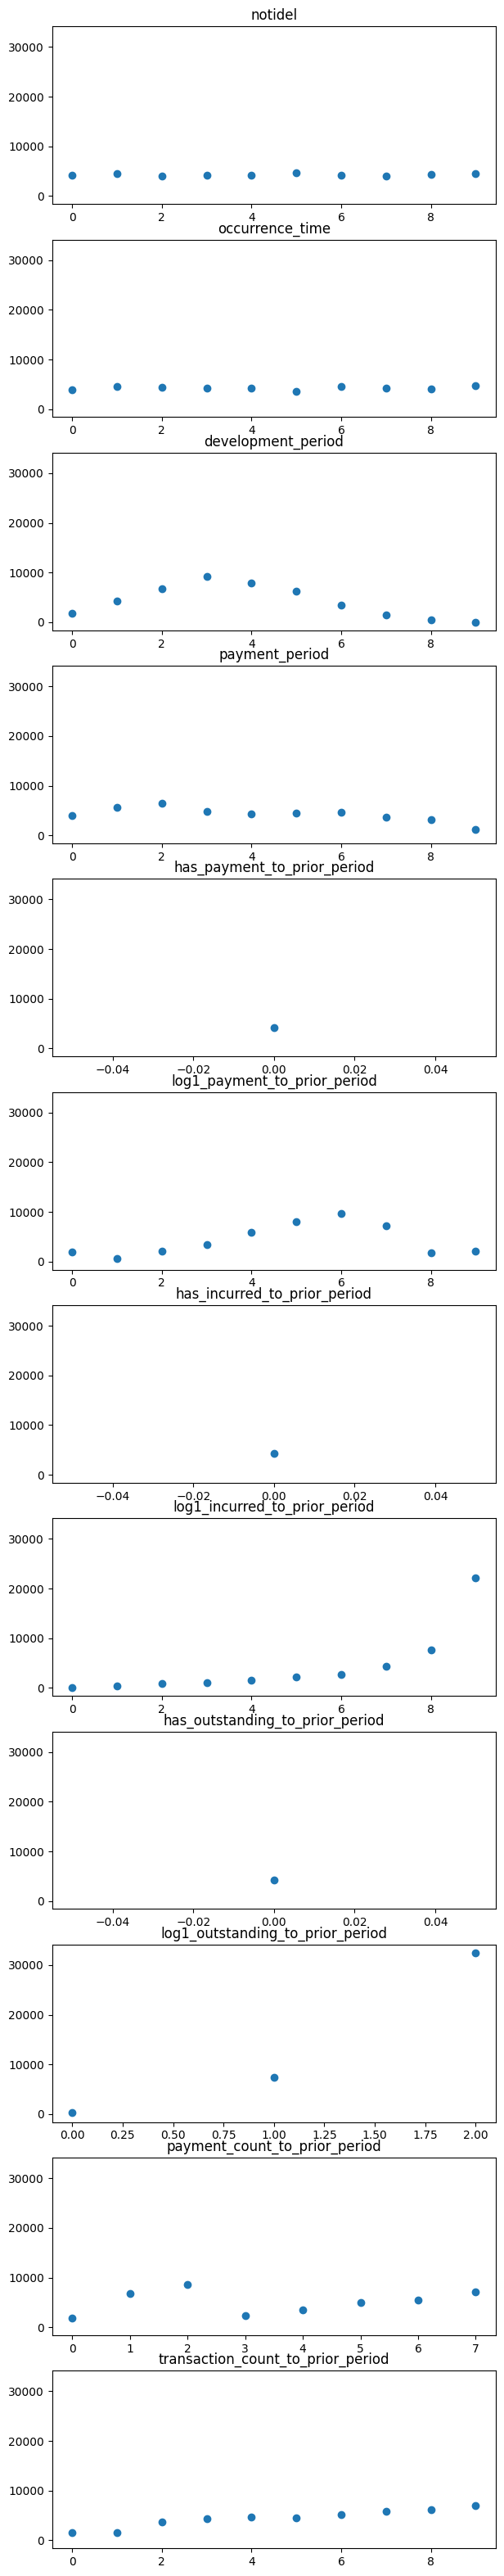

In [68]:
fig, axs = plt.subplots(len(data_cols), sharex=False, sharey=True, figsize=(7, 40))

for i, f in enumerate(data_cols):
    dat_copy = dat.copy()
    dat_copy["decile"] = pd.qcut(dat[f], 10, labels=False, duplicates='drop')
    X_sum = dat_copy.groupby("decile").agg("mean").reset_index()
    
    axs[i].scatter(X_sum.index, X_sum.payment_size)
    axs[i].set_title(f)

## Data Augmentation 
-----

### Idea: Claim information as at every balance date
Consider claim number 2000 (as an example):

In [69]:
sample_df = dat.loc[dat.claim_no==2000, ["claim_no", "occurrence_period", "train_ind", "payment_size"] + data_cols]
sample_df

claim_no  occurrence_period  train_ind  payment_size  notidel  \
79961      2000                 22       True          0.00     1.15   
79962      2000                 22       True          0.00     1.15   
79963      2000                 22       True     11,429.22     1.15   
79964      2000                 22       True          0.00     1.15   
79965      2000                 22       True          0.00     1.15   
79966      2000                 22       True          0.00     1.15   
79967      2000                 22       True     12,777.97     1.15   
79968      2000                 22       True          0.00     1.15   
79969      2000                 22       True          0.00     1.15   
79970      2000                 22       True     11,978.44     1.15   
79971      2000                 22       True          0.00     1.15   
79972      2000                 22       True          0.00     1.15   
79973      2000                 22       True          0.00     1.15   
79974      2000                 22       True     12,500.18     1.15   
79975      2000                 22       True          0.00     1.15   
79976      2000                 22       True          0.00     1.15   
79977      2000                 22       True     12,789.19     1.15   
79978      2000                 22       True          0.00     1.15   
79979      2000                 22      False          0.00     1.15   
79980      2000                 22      False          0.00     1.15   
79981      2000                 22      False    375,889.12     1.15   
79982      2000                 22      False     46,526.38     1.15   
79983      2000                 22      False          0.00     1.15   
79984      2000                 22      False          0.00     1.15   
79985      2000                 22      False          0.00     1.15   
79986      2000                 22      False          0.00     1.15   
79987      2000                 22      False          0.00     1.15   
79988      2000                 22      False          0.00     1.15   
79989      2000                 22      False          0.00     1.15   
79990      2000                 22      False          0.00     1.15   
79991      2000                 22      False          0.00     1.15   
79992      2000                 22      False          0.00     1.15   
79993      2000                 22      False          0.00     1.15   
79994      2000                 22      False          0.00     1.15   
79995      2000                 22      False          0.00     1.15   
79996      2000                 22      False          0.00     1.15   
79997      2000                 22      False          0.00     1.15   
79998      2000                 22      False          0.00     1.15   
79999      2000                 22      False          0.00     1.15   

       occurrence_time  development_period  payment_period  \
79961            21.23                   1              23   
79962            21.23                   2              24   
79963            21.23                   3              25   
79964            21.23                   4              26   
79965            21.23                   5              27   
79966            21.23                   6              28   
79967            21.23                   7              29   
79968            21.23                   8              30   
79969            21.23                   9              31   
79970            21.23                  10              32   
79971            21.23                  11              33   
79972            21.23                  12              34   
79973            21.23                  13              35   
79974            21.23                  14              36   
79975            21.23                  15              37   
79976            21.23                  16              38   
79977            21.23                  17              39   
79978     

Each record represents one development period. The features are based on the history up to the development period, so at every point, we are predicting the next payment without using any future information.

However, this is any future information relative to the period. The challenge is that actuarial models are often used to predict ultimate claims, not just for the following period. Consequently, we need to predict the future payments based on information up to some date.

In [70]:
def backdate(df, backdate_periods, keep_cols):
    dedupe = [*set(["claim_no", "occurrence_period", "development_period", "payment_period"] + keep_cols)]
    bd = df.loc[:, dedupe].copy()
    bd["development_period"]= bd.development_period + backdate_periods
    bd.rename(columns={"payment_period": "payment_period_as_at"}, inplace=True)
    df= df[["claim_no", "occurrence_period", "development_period", "train_ind", "payment_size", "payment_period", "occurrence_time", "notidel"]].assign(
        data_as_at_development_period = lambda df: df.development_period - backdate_periods, 
        backdate_periods = backdate_periods
    ).merge(
        bd,
        how='left',
        on=["claim_no", "occurrence_period", "development_period"],
        suffixes=[None, "_backdatedrop"]
    )
    return df.drop(df.filter(regex='_backdatedrop').columns, axis=1)

backdate(sample_df, backdate_periods=1, keep_cols=data_cols)

claim_no  occurrence_period  development_period  train_ind  payment_size  \
0       2000                 22                   1       True          0.00   
1       2000                 22                   2       True          0.00   
2       2000                 22                   3       True     11,429.22   
3       2000                 22                   4       True          0.00   
4       2000                 22                   5       True          0.00   
5       2000                 22                   6       True          0.00   
6       2000                 22                   7       True     12,777.97   
7       2000                 22                   8       True          0.00   
8       2000                 22                   9       True          0.00   
9       2000                 22                  10       True     11,978.44   
10      2000                 22                  11       True          0.00   
11      2000                 22                  12       True          0.00   
12      2000                 22                  13       True          0.00   
13      2000                 22                  14       True     12,500.18   
14      2000                 22                  15       True          0.00   
15      2000                 22                  16       True          0.00   
16      2000                 22                  17       True     12,789.19   
17      2000                 22                  18       True          0.00   
18      2000                 22                  19      False          0.00   
19      2000                 22                  20      False          0.00   
20      2000                 22                  21      False    375,889.12   
21      2000                 22                  22      False     46,526.38   
22      2000                 22                  23      False          0.00   
23      2000                 22                  24      False          0.00   
24      2000                 22                  25      False          0.00   
25      2000                 22                  26      False          0.00   
26      2000                 22                  27      False          0.00   
27      2000                 22                  28      False          0.00   
28      2000                 22                  29      False          0.00   
29      2000                 22                  30      False          0.00   
30      2000                 22                  31      False          0.00   
31      2000                 22                  32      False          0.00   
32      2000                 22                  33      False          0.00   
33      2000                 22                  34      False          0.00   
34      2000                 22                  35      False          0.00   
35      2000                 22                  36      False          0.00   
36      2000                 22                  37      False          0.00   
37      2000                 22                  38      False          0.00   
38      2000                 22                  39      False          0.00   

    payment_period  occurrence_time  notidel  data_as_at_development_period  \
0               23            21.23     1.15                              0   
1               24            21.23     1.15                              1   
2               25            21.23     1.15                              2   
3               26            21.23     1.15                              3   
4               27            21.23     1.15                              4   
5               28            21.23     1.15                              5   
6               29            21.23     1.15                              6   
7               30            21.23     1.15                              7   
8               31            21.23     1.15                              8   
9            


### Idea: Pinning the Tail

So one challenge with the deep learning models is the tail.

We would have an assumption that claims will generally tail off to zero in later development periods and eventually all be settled. 

The training data see claims tailing off to zero, but only for the early occurrence months. With the payment period cut-off, we have no tail data for more recent occurrence months.

This is not a problem for the GLM which is parametrized to have the development period effect across all occurrence periods, but for more complex models like the neural networks it's possible for the model to extrapolate the tail wildly.

The proposed solution below is to augment the data with tail development periods with zero payments.

In [71]:
extra_data = (
    dat.loc[dat.train_ind == 1, [*set(["claim_no", "occurrence_period", "development_period", "payment_period", "train_ind"] + data_cols)]]  # Training data
        .groupby("claim_no").last()  # Last training record per claim
        .rename(columns={"payment_period": "payment_period_as_at", "development_period": "data_as_at_development_period"})
        .assign(
            development_period = num_dev_periods + 1,  # set dev period to be tail
            payment_period = lambda df: df.occurrence_period + num_dev_periods + 1,
            backdate_periods = lambda df: num_dev_periods + 1 - df.payment_period,
            payment_size = 0
        )
        .reset_index()
)
extra_data.head()

claim_no  payment_count_to_prior_period  transaction_count_to_prior_period  \
0         1                           5.00                               9.00   
1         2                           5.00                               9.00   
2         3                           6.00                              11.00   
3         4                           5.00                               8.00   
4         5                           5.00                               8.00   

   data_as_at_development_period  has_incurred_to_prior_period  notidel  \
0                             39                             1     0.66   
1                             39                             1     0.74   
2                             39                             1     0.90   
3                             39                             1     0.42   
4                             39                             1     1.64   

   occurrence_time  has_payment_to_prior_period  log1_payment_to_prior_period  \
0             0.73                            1                         12.36   
1             0.33                            1                         12.38   
2             0.52                            1                         11.33   
3             0.74                            1                         12.34   
4             0.62                            1                         11.69   

   occurrence_period  log1_outstanding_to_prior_period  train_ind  \
0                  1                              0.00       True   
1                  1                              0.00       True   
2                  1                              0.00       True   
3                  1                              0.00       True   
4                  1                              0.00       True   

   log1_incurred_to_prior_period  has_outstanding_to_prior_period  \
0                          12.36                                0   
1                          12.38                                0   
2                          11.33                                0   
3                          12.34                                0   
4                          11.69                                0   

   payment_period_as_at  development_period  payment_period  backdate_periods  \
0                    40                  40              41                -1   
1                    40                  40              41                -1   
2                    40                  40              41                -1   
3                    40                  40              41                -1   
4                    40                  40              41                -1   

   payment_size  
0             0  
1             0  
2             0  
3             0  
4             0

The dataset gets quite large with the backdating, as we repeat each claim `development_period` squared times. 

We will create a ``nn_train`` that samples one record from each claim_no, development_period. 

In [72]:
backdated_data = [backdate(dat, backdate_periods=i, keep_cols=data_cols) for i in range(0, num_dev_periods)]
all_data = pd.concat(backdated_data + [extra_data], axis="rows")

a = set(all_data.columns.to_list())
b = set(extra_data.columns.to_list())

assert list(b - a) == []
assert list(a - b) == []

nn_train_full = all_data.loc[all_data.train_ind == 1].loc[lambda df: ~np.isnan(df.payment_period_as_at)]        # Filter out invalid payment period as at
nn_test = all_data.loc[all_data.train_ind == 0].loc[lambda df: df.payment_period_as_at==(cutoff + 1)].fillna(0)       # As at balance date
features = data_cols + ["backdate_periods"]

nn_train = nn_train_full.groupby(["claim_no", "development_period"]).sample(n=1, random_state=42)
nn_train.index.size == dat[dat.train_ind==1].index.size

nn_dat = pd.concat([nn_train.assign(train_ind=True), nn_test.assign(train_ind=False)])
# Run below instead to not use these ideas for now:
# nn_train = dat.loc[dat.train_ind == 1]
# nn_test = dat.loc[dat.train_ind == 0]

In [73]:
features = data_cols + ["backdate_periods"]

A more sophisticated approach could be to sample different records per epoch. We create a batch sampling function to use in our training loop.

In [74]:
def claim_sampler(X, y):
    indices = torch.tensor(
        nn_train_full[["claim_no", "development_period", "data_as_at_development_period"]]
        .reset_index()
        .groupby(["claim_no", "development_period"])
        .sample(n=1)
        .index
    )
    return torch.index_select(X, 0, indices), torch.index_select(y, 0, indices)

use_batching_logic=True  # Set to False to omit this logic.

In [75]:
nn_train_full.loc[lambda df: df.claim_no == 2000].sort_values(["development_period", "data_as_at_development_period"])

claim_no  occurrence_period  development_period  train_ind  \
77998      2000                 22                   1       True   
77999      2000                 22                   2       True   
77999      2000                 22                   2       True   
78000      2000                 22                   3       True   
78000      2000                 22                   3       True   
...         ...                ...                 ...        ...   
78015      2000                 22                  18       True   
78015      2000                 22                  18       True   
78015      2000                 22                  18       True   
78015      2000                 22                  18       True   
1999       2000                 22                  40       True   

       payment_size  payment_period  occurrence_time  notidel  \
77998          0.00              23            21.23     1.15   
77999          0.00              24            21.23     1.15   
77999          0.00              24            21.23     1.15   
78000     11,429.22              25            21.23     1.15   
78000     11,429.22              25            21.23     1.15   
...             ...             ...              ...      ...   
78015          0.00              40            21.23     1.15   
78015          0.00              40            21.23     1.15   
78015          0.00              40            21.23     1.15   
78015          0.00              40            21.23     1.15   
1999           0.00              62            21.23     1.15   

       data_as_at_development_period  backdate_periods  \
77998                              1                 0   
77999                              1                 1   
77999                              2                 0   
78000                              1                 2   
78000                              2                 1   
...                              ...               ...   
78015                             15                 3   
78015                             16                 2   
78015                             17                 1   
78015                             18                 0   
1999                              18               -22   

       payment_count_to_prior_period  transaction_count_to_prior_period  \
77998                           0.00                               0.00   
77999                           0.00                               0.00   
77999                           0.00                               1.00   
78000                           0.00                               0.00   
78000                           0.00                               1.00   
...                              ...                                ...   
78015                           4.00                               8.00   
78015                           4.00                               9.00   
78015                           4.00                               9.00   
78015                           5.00                              10.00   
1999                            5.00                              10.00   

       has_incurred_to_prior_period  has_payment_to_prior_period  \
77998                          0.00                         0.00   
77999                          0.00                         0.00   
77999                          1.00                         0.00   
78000                          0.00                         0.00   
78000                          1.00                         0.00   
...                             ...                          ...   
78015                          1.00                         1.00   
78015                          1.00                         1.00   
78015                          1.00                         1.00   
78015                          1.00                         1.00   
1999                           1.00                

In [76]:
nn_test.loc[lambda df: df.claim_no == 2000]

claim_no  occurrence_period  development_period  train_ind  \
78016      2000                 22                  19      False   
78017      2000                 22                  20      False   
78018      2000                 22                  21      False   
78019      2000                 22                  22      False   
78020      2000                 22                  23      False   
78021      2000                 22                  24      False   
78022      2000                 22                  25      False   
78023      2000                 22                  26      False   
78024      2000                 22                  27      False   
78025      2000                 22                  28      False   
78026      2000                 22                  29      False   
78027      2000                 22                  30      False   
78028      2000                 22                  31      False   
78029      2000                 22                  32      False   
78030      2000                 22                  33      False   
78031      2000                 22                  34      False   
78032      2000                 22                  35      False   
78033      2000                 22                  36      False   
78034      2000                 22                  37      False   
78035      2000                 22                  38      False   
78036      2000                 22                  39      False   

       payment_size  payment_period  occurrence_time  notidel  \
78016          0.00              41            21.23     1.15   
78017          0.00              42            21.23     1.15   
78018    375,889.12              43            21.23     1.15   
78019     46,526.38              44            21.23     1.15   
78020          0.00              45            21.23     1.15   
78021          0.00              46            21.23     1.15   
78022          0.00              47            21.23     1.15   
78023          0.00              48            21.23     1.15   
78024          0.00              49            21.23     1.15   
78025          0.00              50            21.23     1.15   
78026          0.00              51            21.23     1.15   
78027          0.00              52            21.23     1.15   
78028          0.00              53            21.23     1.15   
78029          0.00              54            21.23     1.15   
78030          0.00              55            21.23     1.15   
78031          0.00              56            21.23     1.15   
78032          0.00              57            21.23     1.15   
78033          0.00              58            21.23     1.15   
78034          0.00              59            21.23     1.15   
78035          0.00              60            21.23     1.15   
78036          0.00              61            21.23     1.15   

       data_as_at_development_period  backdate_periods  \
78016                             19                 0   
78017                             19                 1   
78018                             19                 2   
78019                             19                 3   
78020                             19                 4   
78021                             19                 5   
78022                             19                 6   
78023                             19                 7   
78024                             19                 8   
78025                             19                 9   
78026                             19                10   
78027                             19                11   
78028                             19                12   
78029                             19                13   
78030                             19                14   
78031                             19                15   
78032                             19                16   
78033        

In [77]:
nn_test.loc[nn_test.occurrence_period==40]

claim_no  occurrence_period  development_period  train_ind  \
139648      3582                 40                   1      False   
139687      3583                 40                   1      False   
139727      3584                 40                   1      False   
139766      3585                 40                   1      False   
139805      3586                 40                   1      False   
...          ...                ...                 ...        ...   
142606      3657                 40                  39      False   
142645      3658                 40                  39      False   
142685      3659                 40                  39      False   
142725      3660                 40                  39      False   
142765      3661                 40                  39      False   

        payment_size  payment_period  occurrence_time  notidel  \
139648          0.00              41            39.26     0.13   
139687          0.00              41            39.92     0.90   
139727          0.00              41            39.29     0.69   
139766          0.00              41            39.94     0.67   
139805      4,302.08              41            39.95     0.15   
...              ...             ...              ...      ...   
142606          0.00              79            39.22     0.66   
142645          0.00              79            39.32     1.51   
142685          0.00              79            39.54     0.06   
142725          0.00              79            39.43     0.22   
142765          0.00              79            39.36     0.38   

        data_as_at_development_period  backdate_periods  \
139648                              1                 0   
139687                              1                 0   
139727                              1                 0   
139766                              1                 0   
139805                              1                 0   
...                               ...               ...   
142606                              1                38   
142645                              1                38   
142685                              1                38   
142725                              1                38   
142765                              1                38   

        payment_count_to_prior_period  transaction_count_to_prior_period  \
139648                           0.00                               1.00   
139687                           0.00                               0.00   
139727                           0.00                               1.00   
139766                           0.00                               0.00   
139805                           0.00                               0.00   
...                               ...                                ...   
142606                           0.00                               1.00   
142645                           0.00                               0.00   
142685                           0.00                               1.00   
142725                           0.00                               1.00   
142765                           0.00                               1.00   

        has_incurred_to_prior_period  has_payment_to_prior_period  \
139648                          1.00                         0.00   
139687                          0.00                         0.00   
139727                          1.00                         0.00   
139766                          0.00                         0.00   
139805                          0.00                         0.00   
...                              ...                          ...   
142606                          1.00                         0.00   
142645                          0.00                         0.00   
142685                          1.00                         0.00   
142725                          1.00                         0

In [78]:
dat.loc[dat.occurrence_period==40, nn_test.columns]

claim_no  occurrence_period  development_period  train_ind  \
143240      3582                 40                   0       True   
143241      3582                 40                   1      False   
143242      3582                 40                   2      False   
143243      3582                 40                   3      False   
143244      3582                 40                   4      False   
...          ...                ...                 ...        ...   
146515      3663                 40                  35      False   
146516      3663                 40                  36      False   
146517      3663                 40                  37      False   
146518      3663                 40                  38      False   
146519      3663                 40                  39      False   

        payment_size  payment_period  occurrence_time  notidel  \
143240          0.00              40            39.26     0.13   
143241          0.00              41            39.26     0.13   
143242     12,417.74              42            39.26     0.13   
143243          0.00              43            39.26     0.13   
143244          0.00              44            39.26     0.13   
...              ...             ...              ...      ...   
146515          0.00              75            39.87     2.29   
146516          0.00              76            39.87     2.29   
146517          0.00              77            39.87     2.29   
146518          0.00              78            39.87     2.29   
146519          0.00              79            39.87     2.29   

        data_as_at_development_period  backdate_periods  \
143240                              0                 0   
143241                              1                 0   
143242                              2                 0   
143243                              3                 0   
143244                              4                 0   
...                               ...               ...   
146515                             35                 0   
146516                             36                 0   
146517                             37                 0   
146518                             38                 0   
146519                             39                 0   

        payment_count_to_prior_period  transaction_count_to_prior_period  \
143240                           0.00                               0.00   
143241                           0.00                               1.00   
143242                           0.00                               1.00   
143243                           1.00                               2.00   
143244                           1.00                               2.00   
...                               ...                                ...   
146515                           6.00                              11.00   
146516                           6.00                              11.00   
146517                           6.00                              11.00   
146518                           6.00                              11.00   
146519                           6.00                              11.00   

        has_incurred_to_prior_period  has_payment_to_prior_period  \
143240                             0                            0   
143241                             1                            0   
143242                             1                            0   
143243                             1                            1   
143244                             1                            1   
...                              ...                          ...   
146515                             1                            1   
146516                             1                            1   
146517                             1                            1   
146518                             1                          

## Detailed Neural Network
----

This logic follows a similar pipeline to the basic neural network but including the features.

### SplineNet:

In [79]:
model_resnet_detailed = Pipeline(
    steps=[
        ("keep", ColumnKeeper(features)),  
        ('zero_to_one', MinMaxScaler()),       # Important! Standardize deep learning inputs.
        ("model", RandomizedSearchCV(
            TabularNetRegressor(LogLinkResNet),
            parameters_nn,
            n_jobs=4,  # Run in parallel (small model)
            n_iter=cv_runs, # Models train slowly, so try only a few models
            cv=RollingOriginSplit(5,5).split(groups=nn_train.payment_period),
            random_state=42
        )),
    ]
)

model_resnet_detailed.fit(
    nn_train,
    nn_train.loc[:, ["payment_size"]]
)

bst_res_det = model_resnet_detailed["model"].best_params_
print("best parameters:", bst_res_det)

cv_results_res_detailed = pd.DataFrame(model_resnet_detailed["model"].cv_results_)


# Refit best model for longer iters
model_resnet_detailed = Pipeline(
    steps=[
        ("keep", ColumnKeeper(features)),  
        ('zero_to_one', MinMaxScaler()),       # Important! Standardize deep learning inputs.
        ("model", TabularNetRegressor(
                SplineNet, 
                l1_penalty=bst_res_det["l1_penalty"],
                weight_decay=bst_res_det["weight_decay"],  
                n_hidden=bst_res_det["n_hidden"],   
                dropout=bst_res_det["dropout"],                             
                max_iter=nn_iter, 
                max_lr=bst_res_det["max_lr"],                
                batch_function=claim_sampler if use_batching_logic else None,                
                rebatch_every_iter=mdn_iter/10,  # takes over 1s to resample so iterate a few epochs per resample                
            )
        )
    ]
)

if use_batching_logic:
    model_resnet_detailed.fit(
        nn_train_full,
        nn_train_full.loc[:, ["payment_size"]]
    )
else: 
    model_resnet_detailed.fit(
        nn_train,
        nn_train.loc[:, ["payment_size"]]
    )


best parameters: {'weight_decay': 0.01, 'verbose': 0, 'n_hidden': 10, 'max_lr': 0.05, 'max_iter': 100, 'l1_penalty': 0.0, 'keep_best_model': True, 'dropout': 0.5, 'clip_value': None}
Train RMSE:  46008.9921875  Train Loss:  -36029.12109375
refreshing batch on epoch 0
Train RMSE:  45630.8203125  Train Loss:  -38134.15234375
refreshing batch on epoch 50
Train RMSE:  45750.328125  Train Loss:  -37945.16796875
refreshing batch on epoch 100
Train RMSE:  45312.26171875  Train Loss:  -39429.93359375
refreshing batch on epoch 150
Train RMSE:  45199.8203125  Train Loss:  -39843.296875
refreshing batch on epoch 200
Train RMSE:  45211.44921875  Train Loss:  -39859.25
refreshing batch on epoch 250
Train RMSE:  45206.98046875  Train Loss:  -39758.52734375
refreshing batch on epoch 300
Train RMSE:  45201.84375  Train Loss:  -39932.15625
refreshing batch on epoch 350
Train RMSE:  45190.82421875  Train Loss:  -39897.37890625
refreshing batch on epoch 400
Train RMSE:  45182.5078125  Train Loss:  -40025

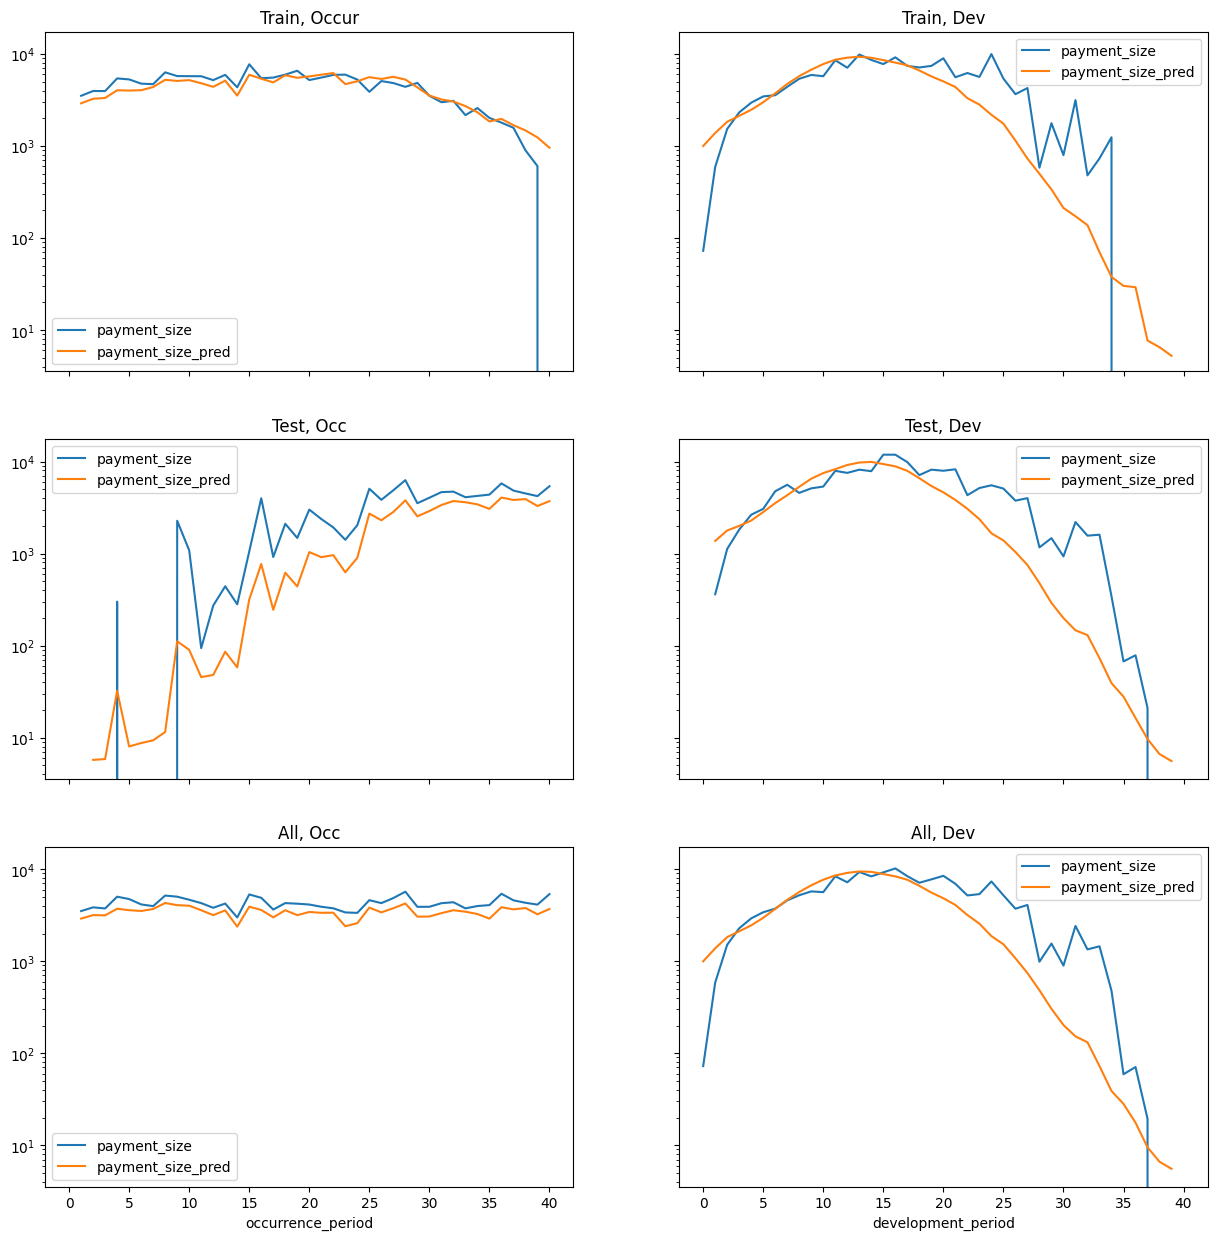

In [80]:
make_model_subplots(model_resnet_detailed, dat)

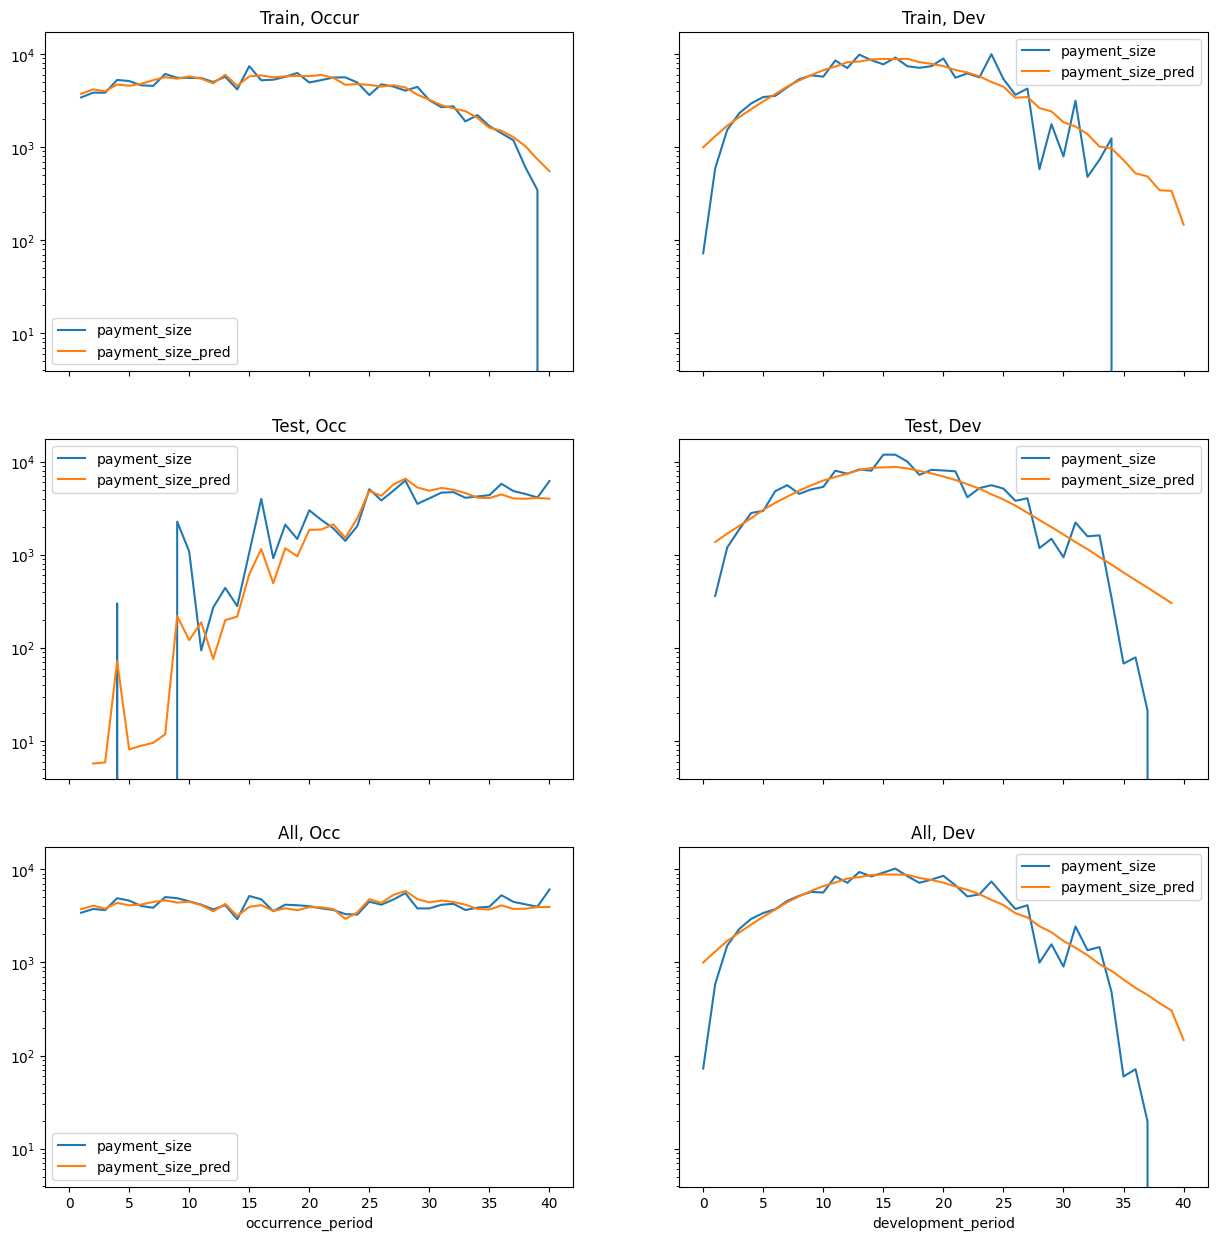

In [81]:
make_model_subplots(model_resnet_detailed, nn_dat)

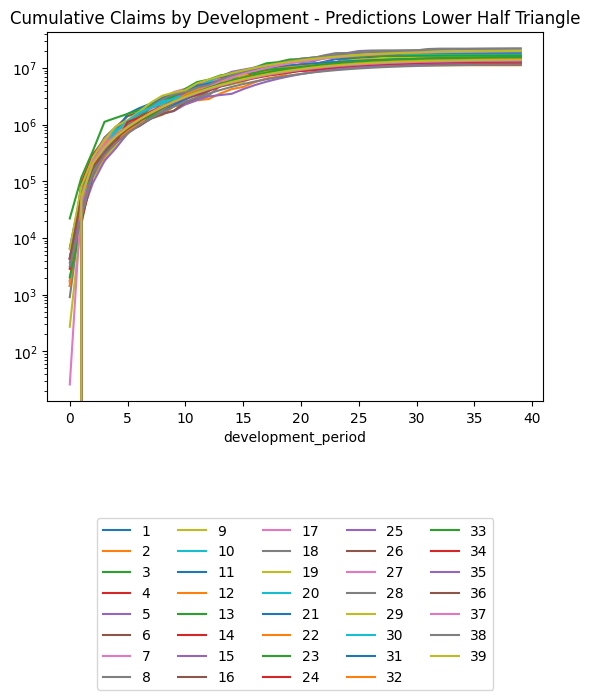

In [82]:
dat_resnet_det_pred, triangle_resnet_detailed = make_pred_set_and_triangle(model_resnet_detailed, nn_train, nn_test)

In [83]:
dat["pred_resnet_claims"] = model_resnet_detailed.predict(dat)
dat["pred_resnet_claims_decile"] = pd.qcut(dat["pred_resnet_claims"], 10, labels=False, duplicates='drop')

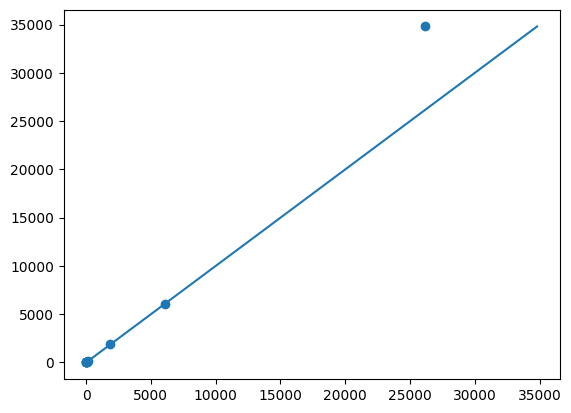

In [84]:
# Train only
X_sum = dat.loc[dat.train_ind == 1].groupby("pred_resnet_claims_decile").agg("mean").reset_index()

X_sum = dat.groupby("pred_resnet_claims_decile").agg("mean").reset_index()

plt.scatter(X_sum.pred_resnet_claims, X_sum.payment_size)
m = max(X_sum.pred_resnet_claims.max(), X_sum.payment_size.max())
plt.plot([0, m],[0, m])

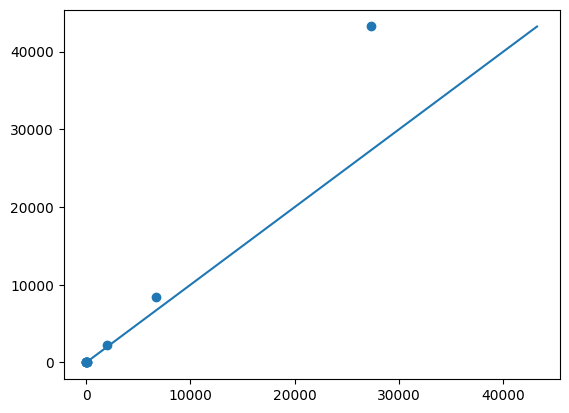

In [85]:
# Test only
X_sum = dat.loc[dat.train_ind == 0].groupby("pred_resnet_claims_decile").agg("mean").reset_index()

plt.scatter(X_sum.pred_resnet_claims, X_sum.payment_size)
m = max(X_sum.pred_resnet_claims.max(), X_sum.payment_size.max())

plt.plot([0, m],[0, m])

### SplineNet:

In [86]:
model_splinenet_detailed = Pipeline(
    steps=[
        ("keep", ColumnKeeper(features)),  
        ('zero_to_one', MinMaxScaler()),       # Important! Standardize deep learning inputs.
        ("model", RandomizedSearchCV(
            TabularNetRegressor(SplineNet),
            parameters_nn,
            n_jobs=4,  # Run in parallel (small model)
            n_iter=cv_runs, # Models train slowly, so try only a few models
            cv=RollingOriginSplit(5,5).split(groups=nn_train.payment_period),
            random_state=42
        )),
    ]
)

model_splinenet_detailed.fit(
    nn_train,
    nn_train.loc[:, ["payment_size"]]
)

bst_det = model_splinenet_detailed["model"].best_params_
print("best parameters:", bst_det)

cv_results_detailed = pd.DataFrame(model_splinenet_detailed["model"].cv_results_)


# Refit best model for longer iters
model_splinenet_detailed = Pipeline(
    steps=[
        ("keep", ColumnKeeper(features)),  
        ('zero_to_one', MinMaxScaler()),       # Important! Standardize deep learning inputs.
        ("model", TabularNetRegressor(
                SplineNet, 
                l1_penalty=bst_det["l1_penalty"],
                weight_decay=bst_det["weight_decay"],  
                n_hidden=bst_det["n_hidden"],   
                dropout=bst_det["dropout"],                             
                max_iter=nn_iter, 
                max_lr=bst_det["max_lr"],                
                batch_function=claim_sampler if use_batching_logic else None,                
                rebatch_every_iter=mdn_iter/10,  # takes over 1s to resample so iterate a few epochs per resample                
            )
        )
    ]
)

if use_batching_logic:
    model_splinenet_detailed.fit(
        nn_train_full,
        nn_train_full.loc[:, ["payment_size"]]
    )
else: 
    model_splinenet_detailed.fit(
        nn_train,
        nn_train.loc[:, ["payment_size"]]
    )


best parameters: {'weight_decay': 0.01, 'verbose': 0, 'n_hidden': 10, 'max_lr': 0.05, 'max_iter': 100, 'l1_penalty': 0.0, 'keep_best_model': True, 'dropout': 0.5, 'clip_value': None}
Train RMSE:  46009.08984375  Train Loss:  -36029.12109375
refreshing batch on epoch 0
Train RMSE:  45646.05859375  Train Loss:  -38057.578125
refreshing batch on epoch 50
Train RMSE:  45421.47265625  Train Loss:  -39166.27734375
refreshing batch on epoch 100
Train RMSE:  45348.2578125  Train Loss:  -39327.62109375
refreshing batch on epoch 150
Train RMSE:  45236.7421875  Train Loss:  -39727.35546875
refreshing batch on epoch 200
Train RMSE:  45213.76953125  Train Loss:  -39800.5
refreshing batch on epoch 250
Train RMSE:  45186.70703125  Train Loss:  -39912.3515625
refreshing batch on epoch 300
Train RMSE:  45185.62109375  Train Loss:  -39928.80859375
refreshing batch on epoch 350
Train RMSE:  45197.921875  Train Loss:  -39764.29296875
refreshing batch on epoch 400
Train RMSE:  45192.8203125  Train Loss:  -

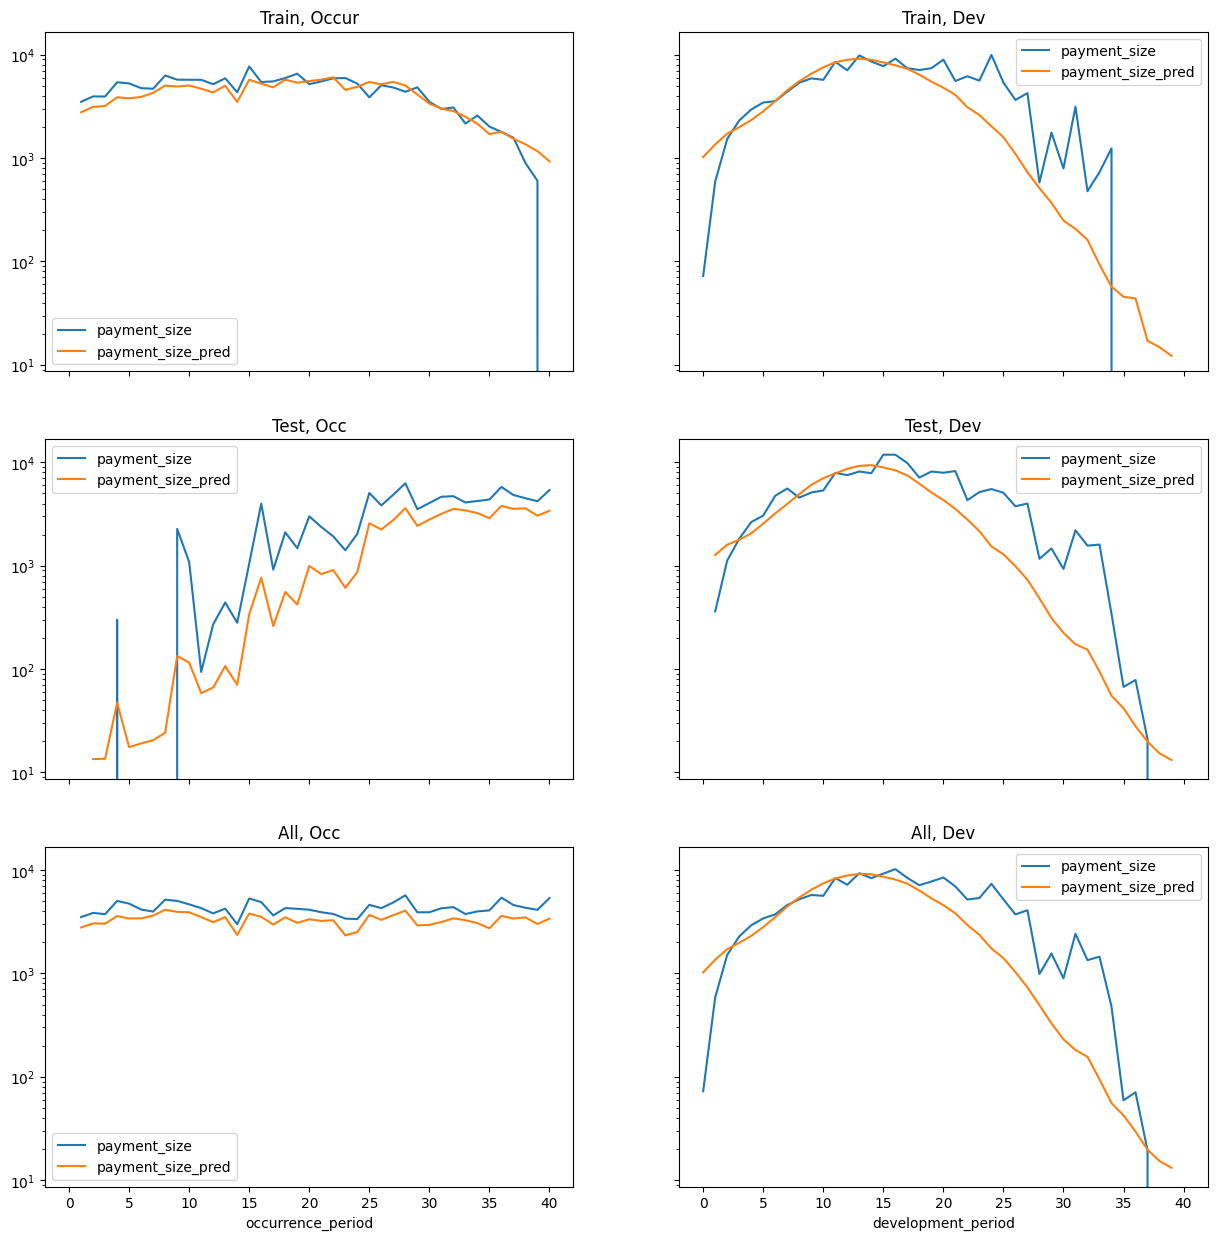

In [87]:
make_model_subplots(model_splinenet_detailed, dat)

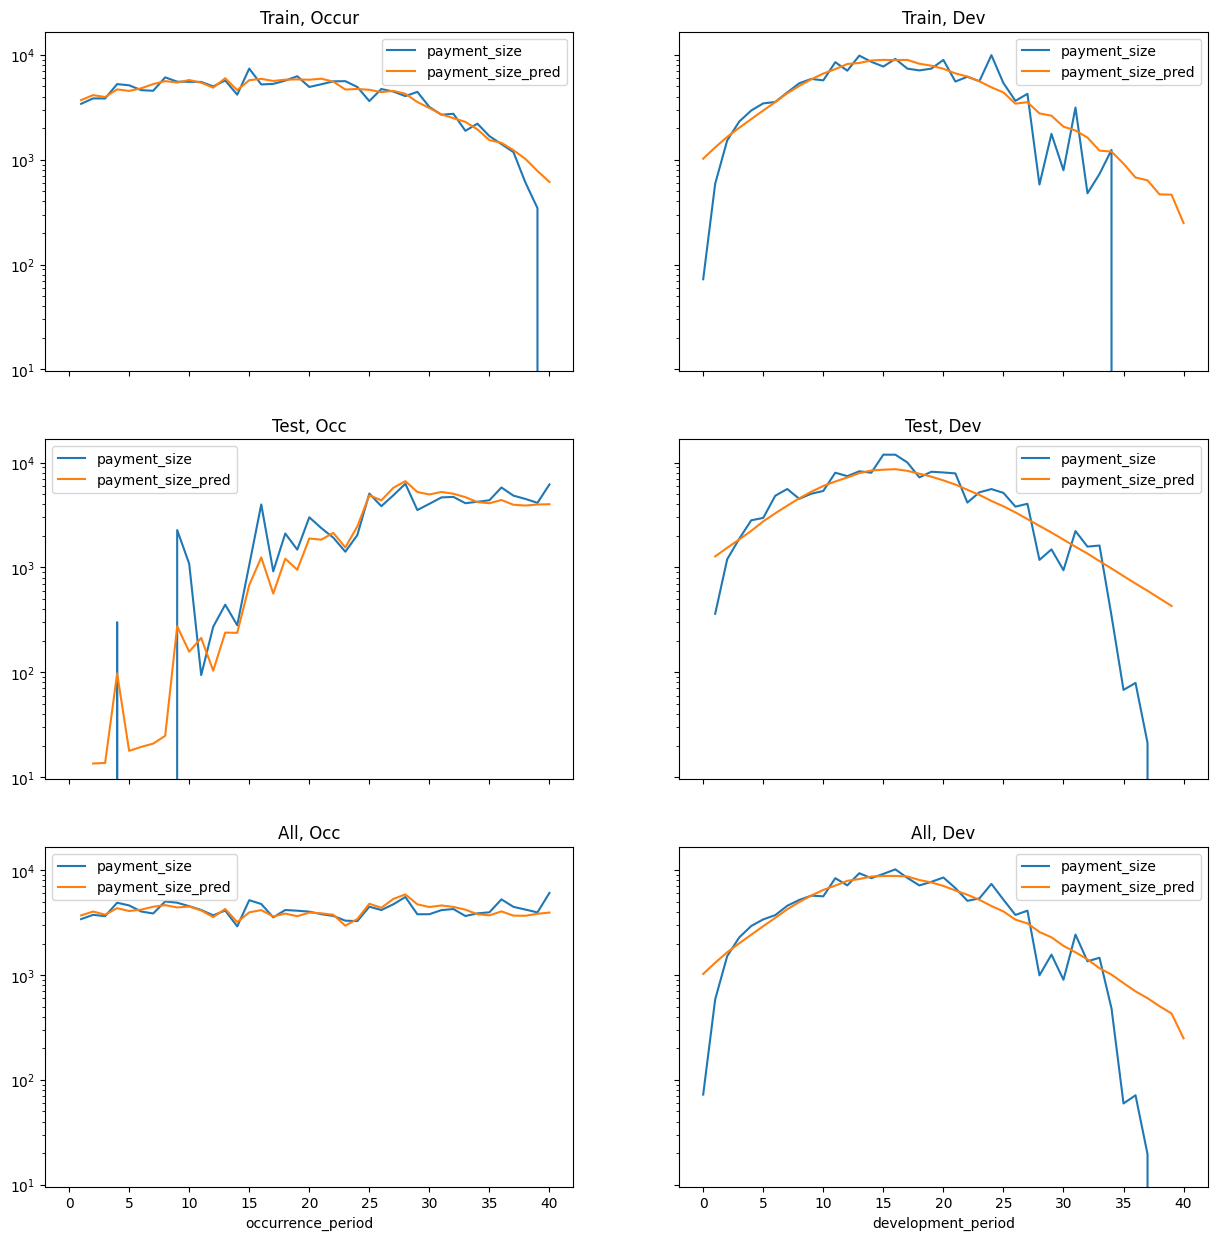

In [88]:
make_model_subplots(model_splinenet_detailed, nn_dat)

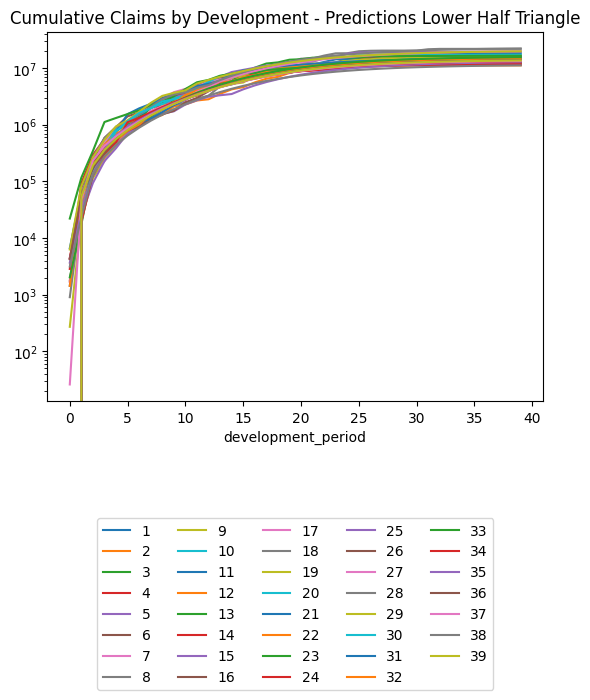

In [89]:
dat_spline_det_pred, triangle_spline_detailed = make_pred_set_and_triangle(model_splinenet_detailed, nn_train, nn_test)

In [90]:
dat["pred_nn_claims"] = model_splinenet_detailed.predict(dat)
dat["pred_nn_claims_decile"] = pd.qcut(dat["pred_nn_claims"], 10, labels=False, duplicates='drop')

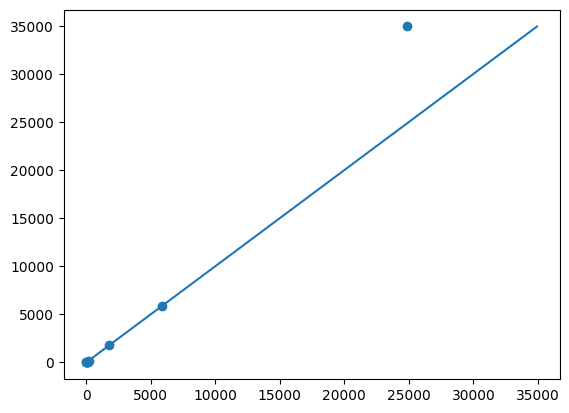

In [91]:
# Train only
X_sum = dat.loc[dat.train_ind == 1].groupby("pred_nn_claims_decile").agg("mean").reset_index()

X_sum = dat.groupby("pred_nn_claims_decile").agg("mean").reset_index()

plt.scatter(X_sum.pred_nn_claims, X_sum.payment_size)
m = max(X_sum.pred_nn_claims.max(), X_sum.payment_size.max())
plt.plot([0, m],[0, m])

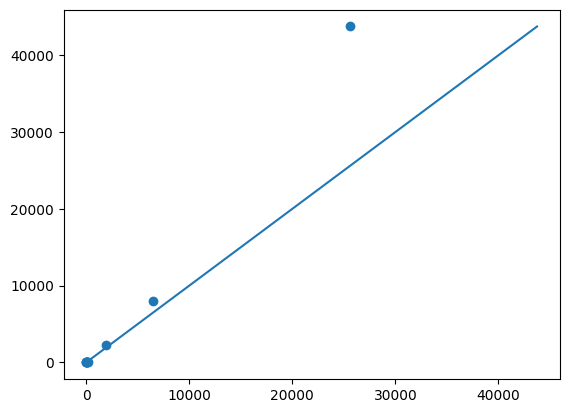

In [92]:
# Test only
X_sum = dat.loc[dat.train_ind == 0].groupby("pred_nn_claims_decile").agg("mean").reset_index()

plt.scatter(X_sum.pred_nn_claims, X_sum.payment_size)
m = max(X_sum.pred_nn_claims.max(), X_sum.payment_size.max())

plt.plot([0, m],[0, m])

## Detailed MDN
----

As we get to larger MDN model, the CV adds to the run-time, but based on the CV performance of the point-estimate models we are not really sure if it improves results. 

So here the approach is:
 * Single model run
 * Add the features
 * Bring across the interactions and dropout parameters from the point estimate CV
 * Apply a low learn rate and clip norm for numerical stability.

In [ ]:
model_MDN_detailed = Pipeline(
    steps=[
        ("keep", ColumnKeeper(features)),   
        ('zero_to_one', MinMaxScaler()),       # Important! Standardize deep learning inputs.
        ("model", TabularNetRegressor(
                LognormalSplineMDN, 
                n_hidden=bst_det["n_hidden"], 
                max_iter=mdn_iter, 
                max_lr=0.025,  
                # weight decay and l1 may lead to unexpected behaviour, leave it off
                dropout=bst_det["dropout"],
                n_gaussians=3,
                criterion=log_mdn_loss_fn,
                init_extra=[model_splinenet_detailed["model"].module_.state_dict(), mdn_init_bias],
                keep_best_model=True,
                # clip_value=3.0,
                batch_function=claim_sampler if use_batching_logic else None,
                rebatch_every_iter=mdn_iter/10,  # takes over 1s to resample so iterate a few epochs per resample
            )
        )
    ]
)

# Fit model
if use_batching_logic:
    model_MDN_detailed.fit(
        nn_train_full,
        nn_train_full.loc[:, ["payment_size"]]
    )    
else:
    model_MDN_detailed.fit(
        nn_train,
        nn_train.loc[:, ["payment_size"]]
    )

Train RMSE:  45193.41015625  Train Loss:  140.53245544433594
refreshing batch on epoch 0


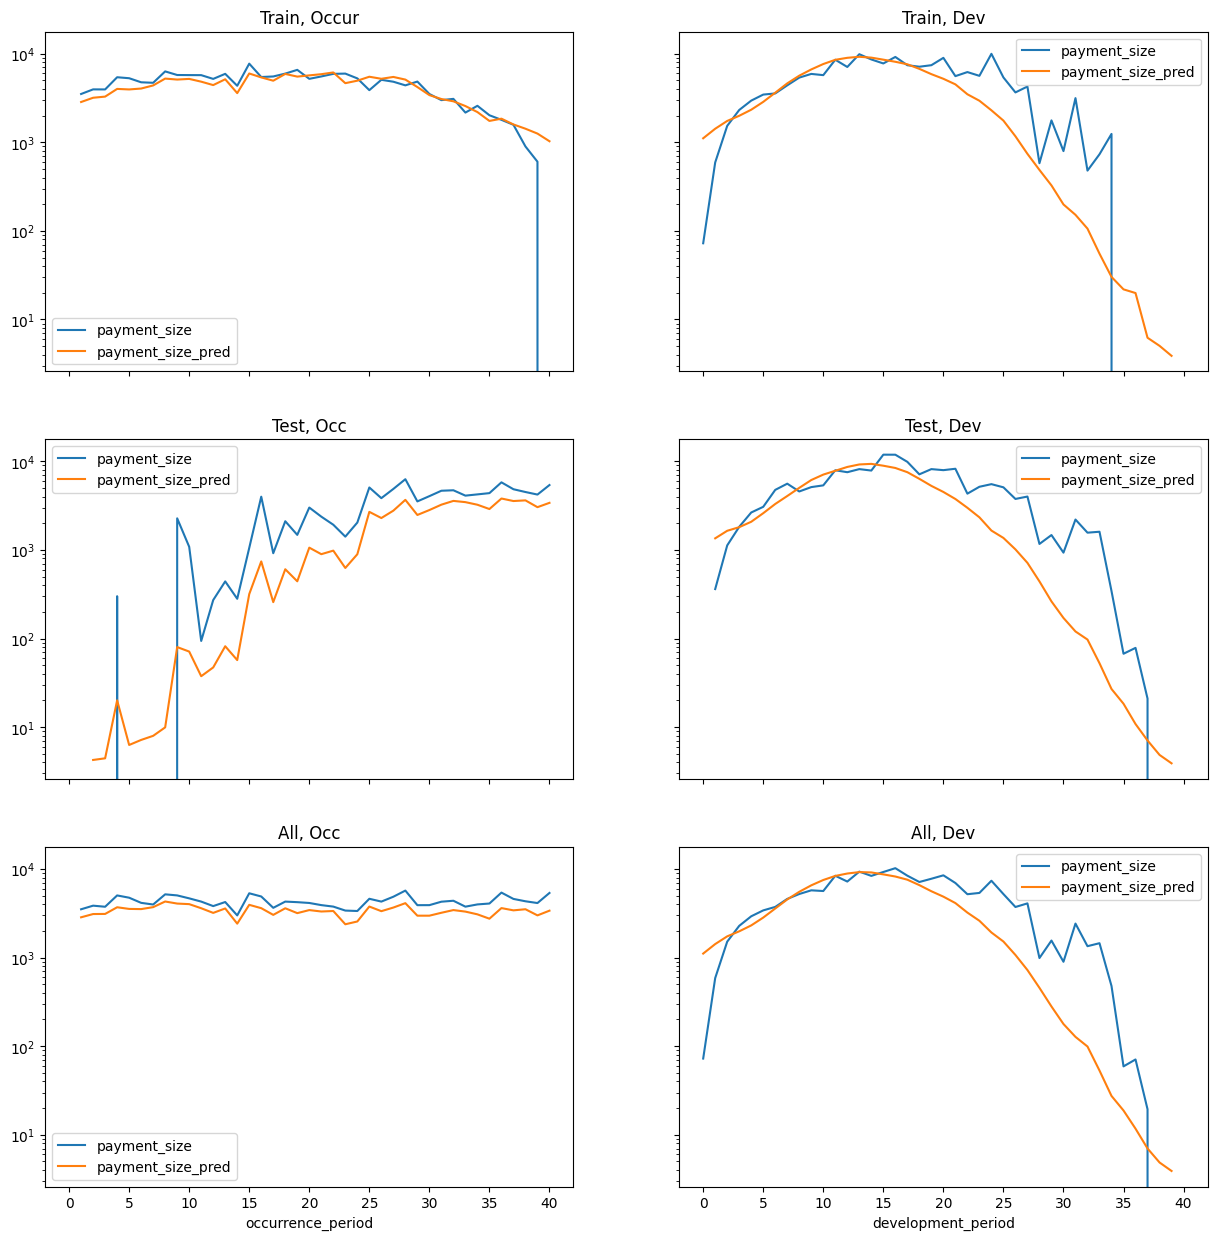

In [ ]:
make_model_subplots(model_MDN_detailed, dat)

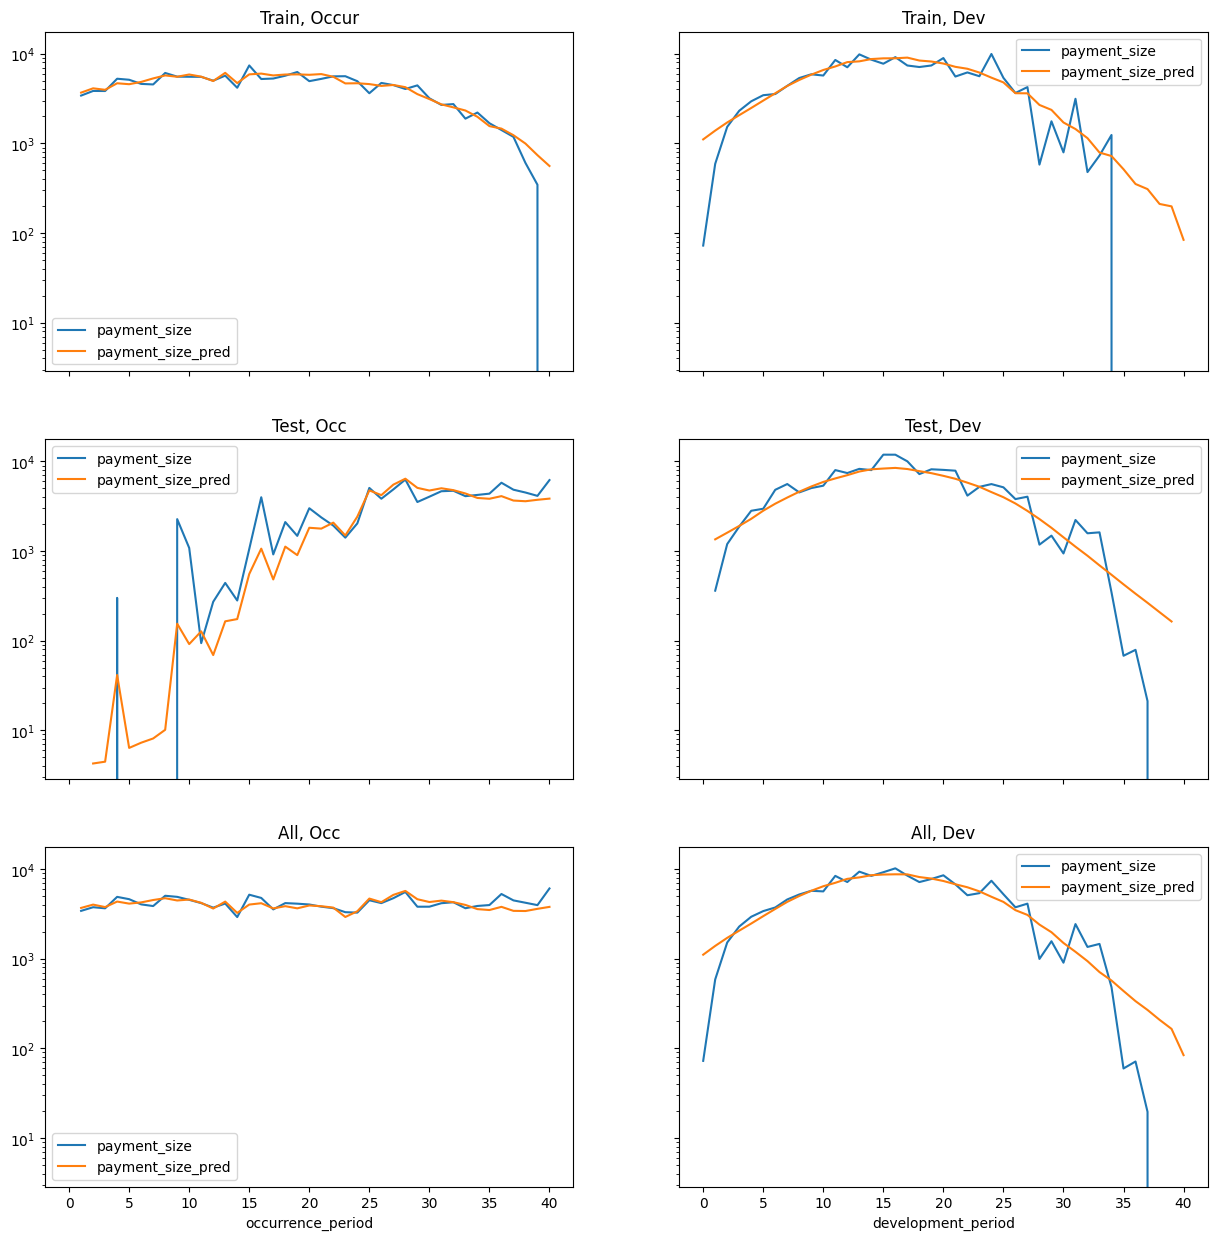

In [ ]:
make_model_subplots(model_MDN_detailed, nn_dat)

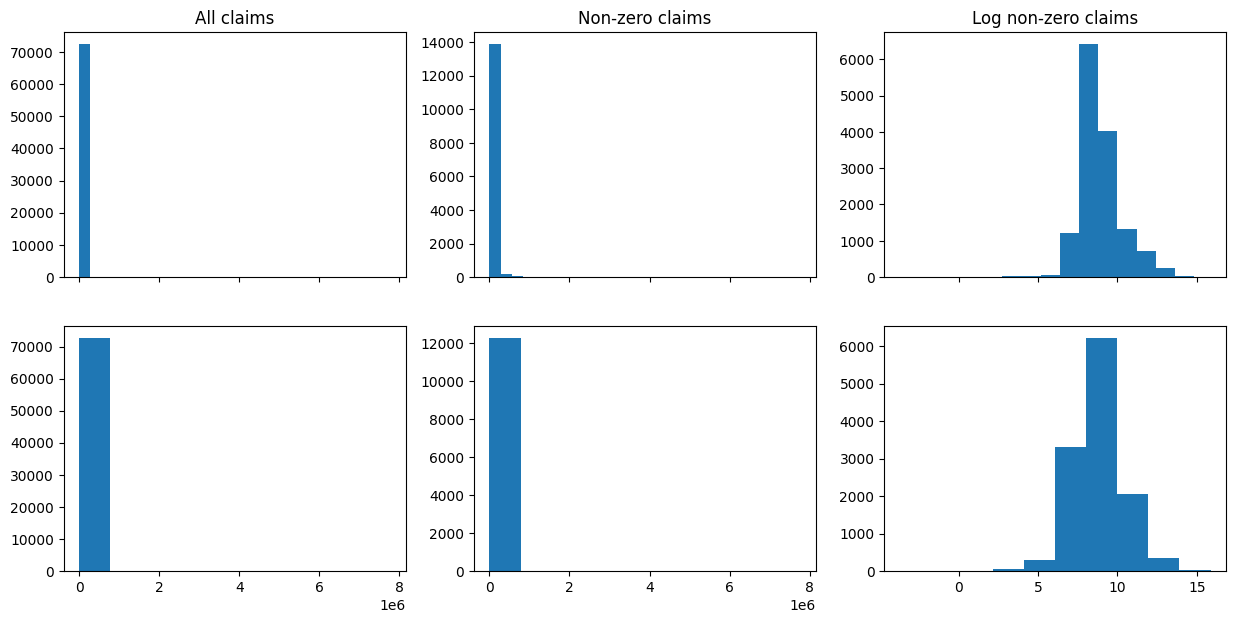

In [ ]:
make_distribution_subplots(model_MDN_detailed)

In [ ]:
dat["pred_mdn_claims"] = model_MDN_detailed.predict(dat)
dat["pred_mdn_claims_decile"] = pd.qcut(dat["pred_mdn_claims"], 10, labels=False, duplicates='drop')

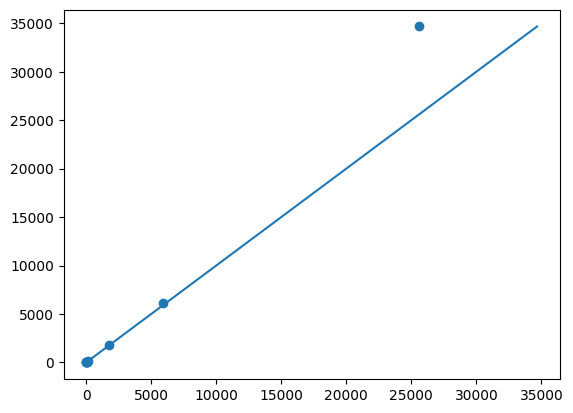

In [ ]:
# Train only
X_sum = dat.loc[dat.train_ind == 1].groupby("pred_mdn_claims_decile").agg("mean").reset_index()

X_sum = dat.groupby("pred_mdn_claims_decile").agg("mean").reset_index()

plt.scatter(X_sum.pred_mdn_claims, X_sum.payment_size)
m = max(X_sum.pred_mdn_claims.max(), X_sum.payment_size.max())
plt.plot([0, m],[0, m])

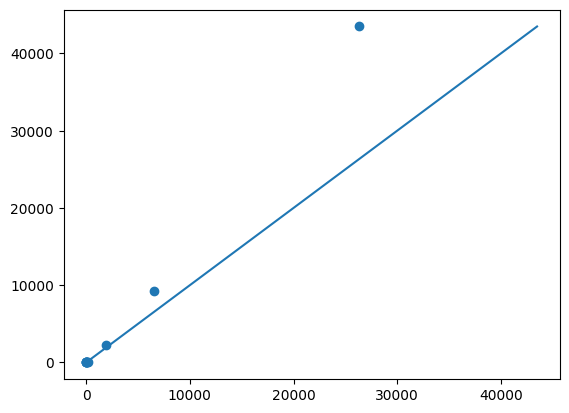

In [ ]:
# Test only
X_sum = dat.loc[dat.train_ind == 0].groupby("pred_mdn_claims_decile").agg("mean").reset_index()

plt.scatter(X_sum.pred_mdn_claims, X_sum.payment_size)
m = max(X_sum.pred_mdn_claims.max(), X_sum.payment_size.max())

plt.plot([0, m],[0, m])

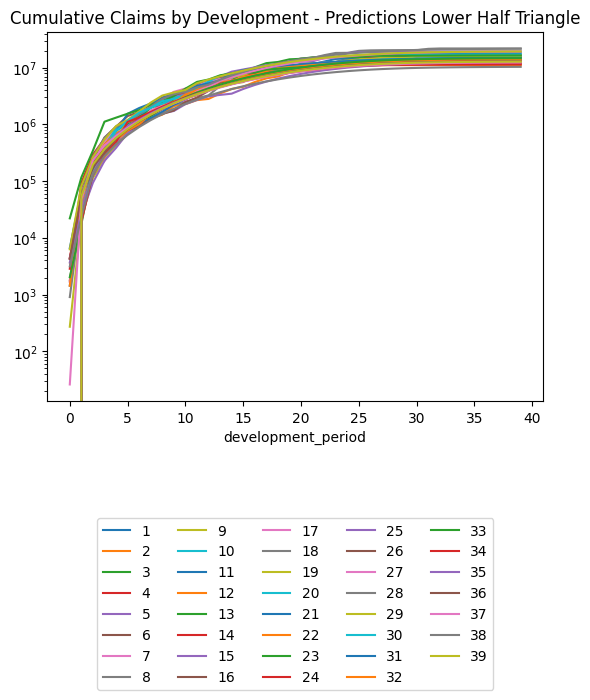

In [ ]:
# for later comparison
dat_mdn_pred, triangle_mdn_detailed = make_pred_set_and_triangle(model_MDN_detailed, nn_train, nn_test)

In [ ]:
dat_mdn_pred.loc[np.abs(dat_spline_det_pred.payment_size_cumulative - dat_mdn_pred.payment_size_cumulative) > 1]

Empty DataFrame
Columns: [claim_no, occurrence_period, development_period, train_ind, payment_size, payment_period, occurrence_time, notidel, data_as_at_development_period, backdate_periods, log1_payment_to_prior_period, payment_count_to_prior_period, has_outstanding_to_prior_period, transaction_count_to_prior_period, payment_period_as_at, has_incurred_to_prior_period, has_payment_to_prior_period, log1_outstanding_to_prior_period, log1_incurred_to_prior_period, payment_size_cumulative]
Index: []

In [ ]:
dat_spline_det_pred.loc[lambda df: (df.claim_no == 349) & (df.train_ind == False)]

claim_no  occurrence_period  development_period  train_ind  payment_size  payment_period  occurrence_time  notidel  data_as_at_development_period  backdate_periods  log1_payment_to_prior_period  payment_count_to_prior_period  has_outstanding_to_prior_period  \
13628       349                  4                  37      False      3,449.24              41             3.86     1.41                             37                 0                         13.51                           5.00                             1.00   
13629       349                  4                  38      False      2,798.46              42             3.86     1.41                             37                 1                         13.51                           5.00                             1.00   
13630       349                  4                  39      False      2,269.00              43             3.86     1.41                             37                 2                         13.51                           5.00                             1.00   

       transaction_count_to_prior_period  payment_period_as_at  has_incurred_to_prior_period  has_payment_to_prior_period  log1_outstanding_to_prior_period  log1_incurred_to_prior_period  payment_size_cumulative  
13628                              14.00                 41.00                          1.00                         1.00                             11.35                          13.62               738,971.45  
13629                              14.00                 41.00                          1.00                         1.00                             11.35                          13.62               741,769.91  
13630                              14.00                 41.00                          1.00                         1.00                             11.35                          13.62               744,038.91

In [ ]:
dat_mdn_pred.loc[lambda df: (df.claim_no == 349) & (df.train_ind == False)]

claim_no  occurrence_period  development_period  train_ind  payment_size  payment_period  occurrence_time  notidel  data_as_at_development_period  backdate_periods  log1_payment_to_prior_period  payment_count_to_prior_period  has_outstanding_to_prior_period  \
13628       349                  4                  37      False      3,449.24              41             3.86     1.41                             37                 0                         13.51                           5.00                             1.00   
13629       349                  4                  38      False      2,798.46              42             3.86     1.41                             37                 1                         13.51                           5.00                             1.00   
13630       349                  4                  39      False      2,269.00              43             3.86     1.41                             37                 2                         13.51                           5.00                             1.00   

       transaction_count_to_prior_period  payment_period_as_at  has_incurred_to_prior_period  has_payment_to_prior_period  log1_outstanding_to_prior_period  log1_incurred_to_prior_period  payment_size_cumulative  
13628                              14.00                 41.00                          1.00                         1.00                             11.35                          13.62               738,971.45  
13629                              14.00                 41.00                          1.00                         1.00                             11.35                          13.62               741,769.91  
13630                              14.00                 41.00                          1.00                         1.00                             11.35                          13.62               744,038.91

## Gradient Boosting Individual Model
----

We create a GBM model to use as a baseline. Advantage of GBMs is that it is really easy to get good, reasonable results. It is unable to extrapolate wildly in unexpected ways, but the disadvantage is that it is unlikely to correctly extrapolate payment period trends. There are no payment period trends in this simulated data, so should do well:

In [ ]:
parameters_gbm = {
    "max_iter": [500, 1000, 2000, 5000], 
    "l2_regularization": [0, 0.001, 0.01, 0.1, 0.3],
    "loss": ["poisson"], 
    "learning_rate": [0.03, 0.07, 0.1]
}

gradient_boosting = Pipeline(
    steps=[
        ("keep", ColumnKeeper(features)),         
        ('gbm', RandomizedSearchCV(
                  HistGradientBoostingRegressor(),
                  parameters_gbm,
                  n_jobs=-1, # Run in parallel
                  n_iter=cv_runs, # Models train slowly, so try only a few models
                  cv=RollingOriginSplit(5,5).split(groups=nn_train.payment_period),
                  random_state=0)),
    ]
)

gradient_boosting.fit(
    nn_train,
    nn_train.payment_size
)

print(gradient_boosting["gbm"].best_params_)

{'max_iter': 2000, 'loss': 'poisson', 'learning_rate': 0.03, 'l2_regularization': 0.01}


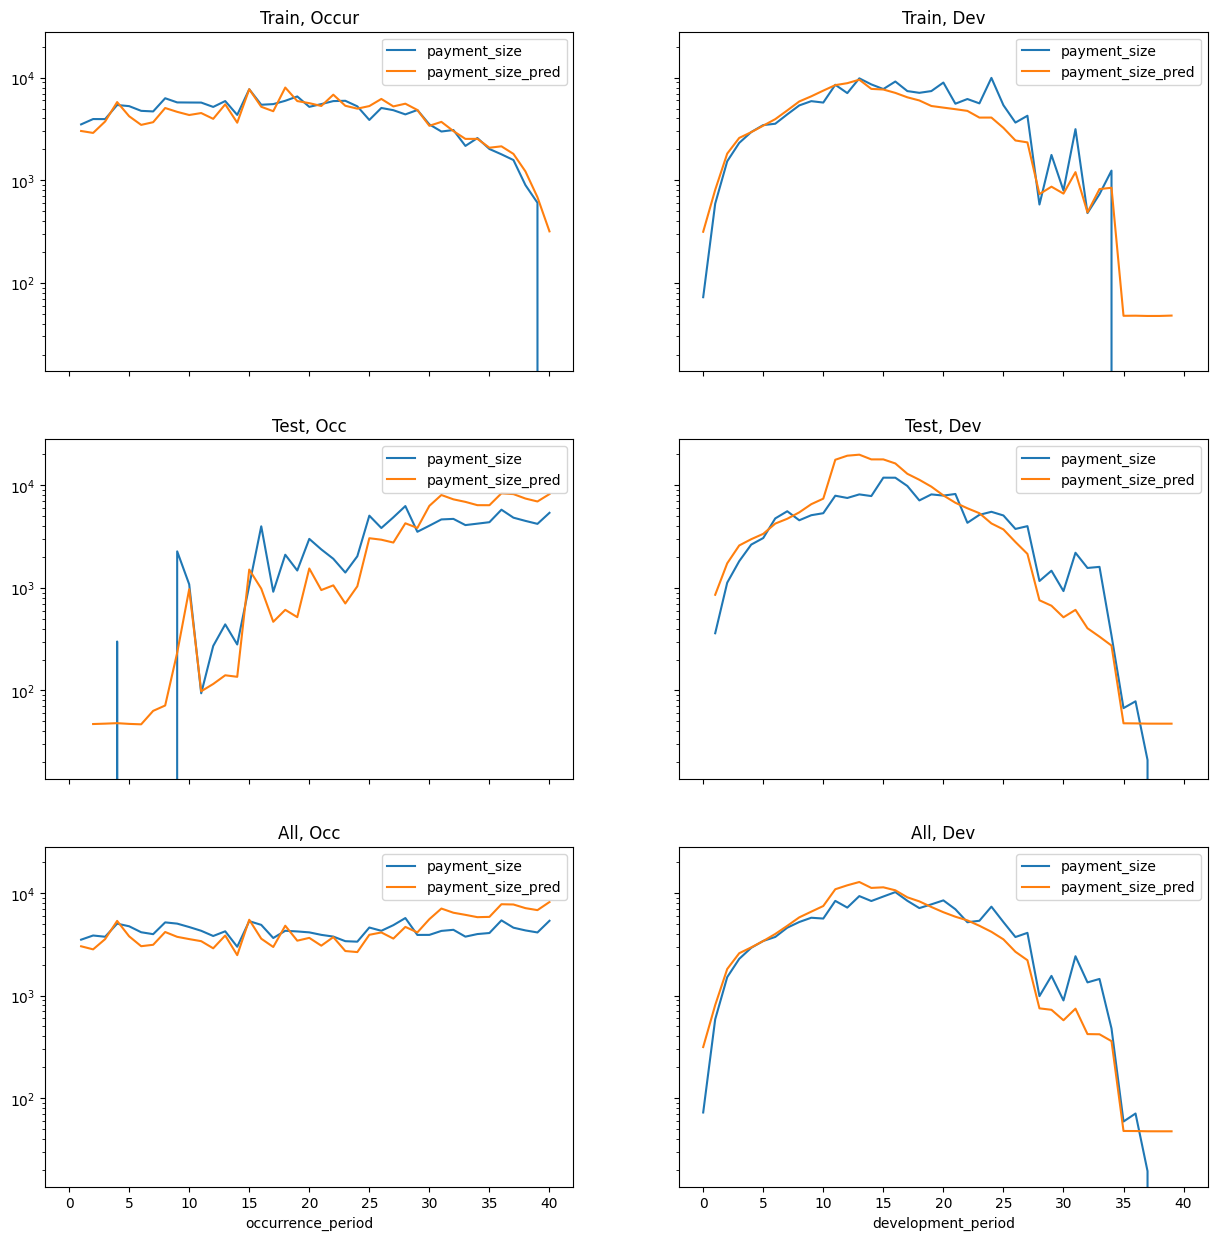

In [ ]:
make_model_subplots(gradient_boosting, dat)

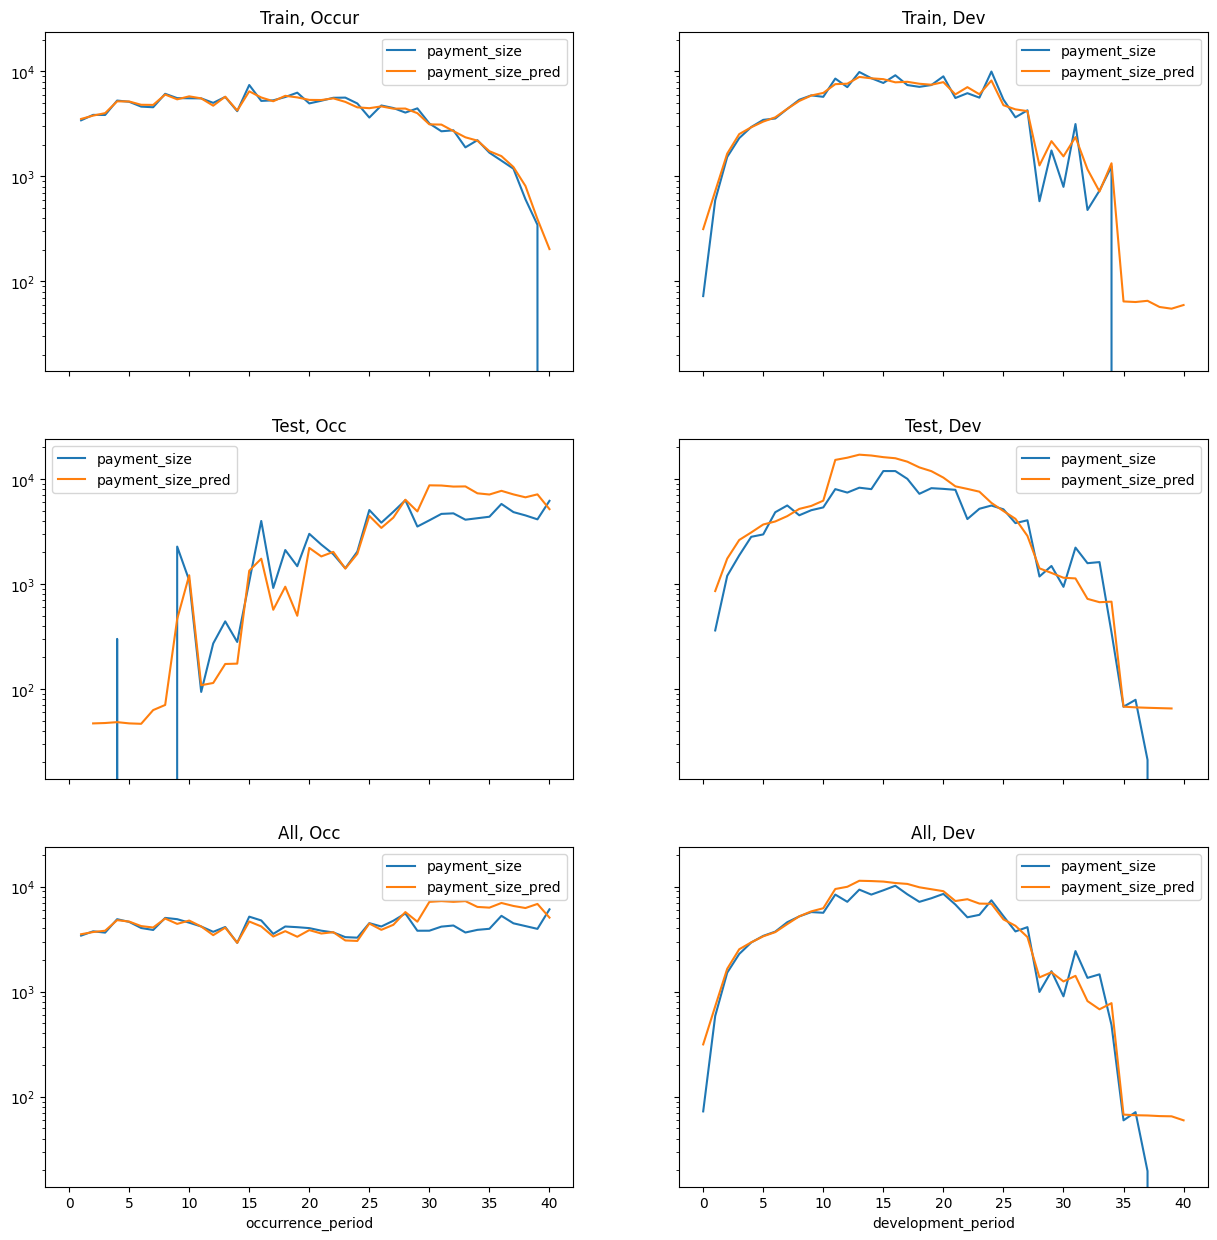

In [ ]:
make_model_subplots(gradient_boosting, nn_dat)

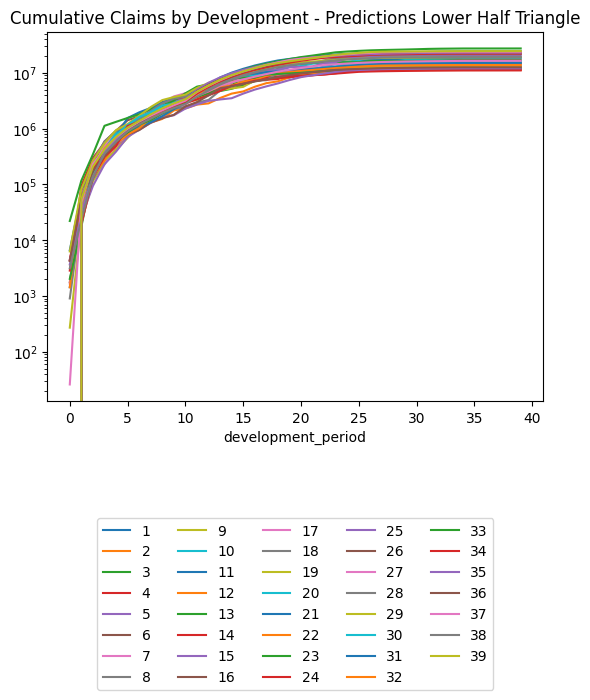

In [ ]:
dat_gbm_pred, triangle_gbm_ind = make_pred_set_and_triangle(gradient_boosting, nn_train, nn_test)

### Individual Claims Predictiveness

Check how the individual models perform on train and test data. 

In [ ]:
dat["pred_gbm_claims"] = gradient_boosting.predict(dat)
dat["pred_gbm_claims_decile"] = pd.qcut(dat["pred_gbm_claims"], 10, labels=False, duplicates='drop')

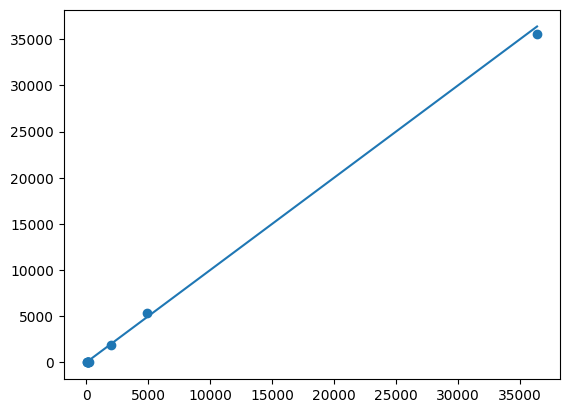

In [ ]:
# Train only
X_sum = dat.loc[dat.train_ind == 1].groupby("pred_gbm_claims_decile").agg("mean").reset_index()

X_sum = dat.groupby("pred_gbm_claims_decile").agg("mean").reset_index()

plt.scatter(X_sum.pred_gbm_claims, X_sum.payment_size)
m = max(X_sum.pred_gbm_claims.max(), X_sum.payment_size.max())
plt.plot([0, m],[0, m])

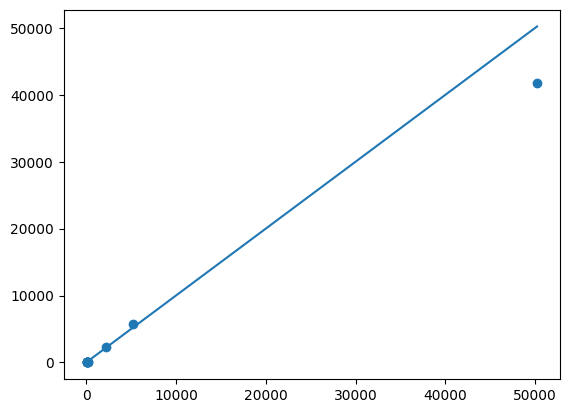

In [ ]:
# Test only
X_sum = dat.loc[dat.train_ind == 0].groupby("pred_gbm_claims_decile").agg("mean").reset_index()

plt.scatter(X_sum.pred_gbm_claims, X_sum.payment_size)
m = max(X_sum.pred_gbm_claims.max(), X_sum.payment_size.max())
plt.plot([0, m],[0, m])

## Ultimate Summary
----

Compare Ultimate projections from the different models

In [ ]:
pd.options.display.float_format = '{:,.0f}'.format

results = pd.concat(
    [(
        triangle.loc[lambda df: df.payment_period == cutoff, ["occurrence_period", "payment_size_cumulative"]]
        .set_index("occurrence_period")
        .rename(columns={"payment_size_cumulative": "Paid to Date"})
    )] +
    [(df.loc[lambda df: df.development_period == num_dev_periods, ["occurrence_period", "payment_size_cumulative"]]
        .set_index("occurrence_period")
        .rename(columns={"payment_size_cumulative": l})) for df, l in zip(
            [triangle,         triangle_cl,    triangle_glm_agg,  triangle_glm_ind, triangle_spline_ind, triangle_resnet_do, triangle_nn_spline, triangle_mdn_spline, triangle_nn_cv, triangle_resnet_detailed, triangle_spline_detailed, triangle_mdn_detailed, triangle_gbm_ind],
            ["True Ultimate", "Chain Ladder", "GLM Chain Ladder", "GLM Individual", "GLM Spline",         "D/O ResNet",      "D/O SplineNet",  "D/O SplineMDN ",   "D/O SplineNet CV", "Detailed ResNet",  "Detailed SplineNet", "Detailed SplineMDN", "Detailed GBM"]
        )
    ],
    axis="columns"
).sort_index()

results

Paid to Date  True Ultimate  Chain Ladder  GLM Chain Ladder  GLM Individual  GLM Spline  D/O ResNet  D/O SplineNet  D/O SplineMDN   D/O SplineNet CV  Detailed ResNet  Detailed SplineNet  Detailed SplineMDN  Detailed GBM
occurrence_period                                                                                                                                                                                                                             
1                    14,076,384     14,076,384    14,076,384        14,076,384      14,076,384  14,076,384  14,076,384     14,076,384      14,076,384        14,076,384       14,076,384          14,076,384          14,076,384    14,076,384
2                    12,657,557     12,657,557    12,657,559        12,657,576      12,670,848  12,669,910  12,682,287     12,687,688      12,687,688        12,697,053       12,657,779          12,657,915          12,657,915    12,661,513
3                    13,146,049     13,146,049    13,146,049        13,146,089      13,173,212  13,177,853  13,206,929     13,218,875      13,218,875        13,239,666       13,146,539          13,146,853          13,146,853    13,154,600
4                    15,438,633     15,509,786    15,438,632        15,438,704      15,486,142  15,488,775  15,530,941     15,546,909      15,546,909        15,575,136       15,452,562          15,448,446          15,448,446    15,450,110
5                    16,169,320     16,169,320    16,169,319        16,169,420      16,234,963  16,258,412  16,327,515     16,350,989      16,350,989        16,394,076       16,170,630          16,171,558          16,171,558    16,185,911
6                    16,819,210     16,819,210    16,819,208        16,819,340      16,903,678  16,976,816  17,089,318     17,122,440      17,122,440        17,187,642       16,821,351          16,822,992          16,822,992    16,843,488
7                    13,773,029     13,773,029    13,879,979        13,880,086      13,949,121  13,967,244  14,094,031     14,124,837      14,124,837        14,193,200       13,775,430          13,777,360          13,777,360    13,806,713
8                    21,912,546     21,912,546    22,184,680        22,184,852      22,293,978  22,246,318  22,443,782     22,480,270      22,480,270        22,579,682       21,916,649          21,920,272          21,920,272    21,966,398
9                    15,770,283     17,388,102    16,012,689        16,012,813      16,091,454  16,145,534  16,344,432     16,368,250      16,368,250        16,462,293       15,912,998          15,880,413          15,880,413    16,100,866
10                   17,522,820     18,517,910    18,136,970        18,137,114      18,226,320  18,105,870  18,377,996     18,392,234      18,392,234        18,514,450       17,629,331          17,606,926          17,606,926    18,635,709
11                   18,459,022     18,563,224    19,199,316        19,199,466      19,292,132  19,307,100  19,648,406     19,643,046      19,643,046        19,790,874       18,645,361          18,600,097          18,600,097    18,579,841
12                   11,115,072     11,342,237    11,687,354        11,687,446      11,743,261  11,879,632  12,139,890     12,117,989      12,117,989        12,228,192       11,175,724          11,172,830          11,172,830    11,210,608
13                   16,288,247     16,828,080    17,189,086        17,189,226      17,270,824  17,616,030  17,994,432     17,937,394      17,937,394        18,094,248       16,516,721          16,489,545          16,489,545    16,500,365
14                   11,227,860     11,589,327    12,173,187        12,173,284      12,230,889  12,865,085  13,254,608     13,170,731      13,170,731        13,328,418       11,471,903          11,452,087          11,452,087    11,452,555
15                   18,792,042     20,236,612    20,874,610        20,874,780      20,976,168  20,813,846  21,216,342     21,104,828      21,104,828        21,263,544       19,619,965          1

In [ ]:
pd.options.display.float_format = '{:,.1f}'.format

leaderboard = []

for col in results.columns:
    leaderboard += [{
        "Method": col,
        "Outstanding Claims Liability": (results.loc[results.index < cutoff, col] - results.loc[results.index < cutoff, "Paid to Date"]).sum(),
        "Period Level MSE": np.sqrt(((results.loc[results.index < cutoff, col] - results.loc[results.index < cutoff, "True Ultimate"])**2).sum()),
        "Period Level Absolute Error": (np.abs(results.loc[results.index < cutoff, col] - results.loc[results.index < cutoff, "True Ultimate"]).sum()),
        "Total OCL Absolute Error": np.abs((results.loc[results.index < cutoff, col] - results.loc[results.index < cutoff, "True Ultimate"]).sum()),   
        "Total OCL Absolute Percent Error": (
            100 * np.abs((results.loc[results.index < cutoff, col] - results.loc[results.index < cutoff, "True Ultimate"]).sum()) / 
            (results.loc[results.index < cutoff, "True Ultimate"] - results.loc[results.index < cutoff, "Paid to Date"]).sum() 
        )
    }]

pd.DataFrame(leaderboard).sort_values("Total OCL Absolute Percent Error")

Method  Outstanding Claims Liability  Period Level MSE  Period Level Absolute Error  Total OCL Absolute Error  Total OCL Absolute Percent Error
1        True Ultimate                 226,495,984.0               0.0                          0.0                       0.0                               0.0
5           GLM Spline                 226,523,664.0      11,507,292.0                 51,295,660.0                  27,682.0                               0.0
9     D/O SplineNet CV                 227,237,152.0      12,081,948.0                 54,952,228.0                 741,177.0                               0.3
7        D/O SplineNet                 224,292,416.0      11,739,676.0                 52,391,616.0               2,203,566.0                               1.0
8       D/O SplineMDN                  224,292,416.0      11,739,676.0                 52,391,616.0               2,203,566.0                               1.0
10     Detailed ResNet                 222,815,495.4      10,066,215.2                 41,985,487.2               3,680,482.8                               1.6
2         Chain Ladder                 230,441,008.0      13,323,997.0                 56,624,468.0               3,945,043.0                               1.7
3     GLM Chain Ladder                 230,446,640.0      13,324,282.0                 56,626,676.0               3,950,646.0                               1.7
4       GLM Individual                 232,382,784.0      12,962,189.0                 56,407,652.0               5,886,814.0                               2.6
6           D/O ResNet                 219,962,912.0      12,635,776.0                 56,489,872.0               6,533,081.0                               2.9
12  Detailed SplineMDN                 206,961,333.4      10,688,836.9                 43,362,654.7              19,534,644.8                               8.6
11  Detailed SplineNet                 206,961,333.4      10,688,836.9                 43,362,654.7              19,534,644.8                               8.6
13        Detailed GBM                 306,684,694.3      30,074,390.8                110,476,154.5              80,188,716.1                              35.4
0         Paid to Date                           0.0      50,952,164.0                226,495,984.0             226,495,984.0                             100.0

The SplineMDN should perform identically to the SplineNet for point estimate based error - by design since weights are loaded in and are set to non-trainable.

## Summary
-----

We have taken a simple chain ladder and added successive enhancements to expand it into first a GLM, then an individual neural network and then a probabilistic mixture density network with specialised architecture and loss function. Key steps, including data transformation, are all transparent in this notebook. We also implemented in Python, a framework for converting Pytorch modules to scikit-learn models, and a rolling origin cross validation approach.

Resulting models perform well compared to benchmarks of the chain ladder and GBM, across all 5 SPLICE datasets.

The summary of the final "Spline-based Individual Mixture Density Network" model design as follows:

### Architecture

* One-way effects - spline based architecture
* Log-link
* ELU activation due to low neuron count
* Adjusted log-normal MDN approach, which also takes into account the observations with zero payments:
    1. Calculate point estimates from a separate module first fit using Poisson loss
    2. Backward solving $\mu$ and $\sigma$ with the mean of a log-normal being $exp(\mu + \sigma^2/2)$
    3. Apply loss to $log(y + \epsilon)$ rather than $y$ (with $\epsilon$ being some small value),
    4. Use $\sqrt ReLU$ + $\epsilon$ as the activation for $\sigma$ rather than $exp$.

### Initialisation:
* Final coefficients generally start at zero which improves numerical stability
* Bias initialise at log(mean) for point estimate models improves convergence
* Bias initialise at values for zero, small, large claims for MDN
* Initialise weights of MDN point estimates to be identical to the SplineNet version, make non-trainable.

### Regularisation:
* L1, Weight decay (similar to L2), Dropout, Constant multiplier factor
* Set up rolling origin cross validation in Python
* Find optimal combination via Random Grid Search. Decided against bayesian optimisation due to added complexity.

### Optimiser:
* AdamW with OneCycle Learning rate scheduler provides fairly fast convergence

### Batch size:
* Use entire dataset per batch. Data is sparse so large batch size is preferred. 

### Calculation:
* GPU acceleration using Nvidia GPUs where available. 
* M1 GPU is also possible with MPS but time savings vs CPU appear to be limited on our current choice of machine.

## Export
----

In [ ]:
# Export code if to see the values in Excel etc.
export = True
if export:
    triangle.pivot(index = "occurrence_period", columns = "development_period", values = "payment_size_cumulative").to_csv(f"payment_triangle_{dataset_no}.csv")
    triangle_train.pivot(index = "occurrence_period", columns = "development_period", values = "payment_size_cumulative").to_csv(f"payment_triangle_train_{dataset_no}.csv")
    triangle_cl.pivot(index = "occurrence_period", columns = "development_period", values = "payment_size_cumulative").to_csv(f"payment_triangle_cl_{dataset_no}.csv")
    triangle_glm_agg.pivot(index = "occurrence_period", columns = "development_period", values = "payment_size_cumulative").to_csv(f"payment_triangle_glm_agg_{dataset_no}.csv")
    triangle_glm_ind.pivot(index = "occurrence_period", columns = "development_period", values = "payment_size_cumulative").to_csv(f"payment_triangle_glm_ind_{dataset_no}.csv")
    triangle_nn_cv.pivot(index = "occurrence_period", columns = "development_period", values = "payment_size_cumulative").to_csv(f"payment_triangle_nn_cv_{dataset_no}.csv")
    triangle_spline_detailed.pivot(index = "occurrence_period", columns = "development_period", values = "payment_size_cumulative").to_csv(f"payment_triangle_nn_det_{dataset_no}.csv")
    triangle_mdn_detailed.pivot(index = "occurrence_period", columns = "development_period", values = "payment_size_cumulative").to_csv(f"payment_triangle_mdn_det_{dataset_no}.csv")
    pd.DataFrame(leaderboard).sort_values("Total OCL Absolute Error").to_csv(f"leaderboard_{dataset_no}.csv")
    results.to_csv(f"payment_results_{dataset_no}.csv")

# References
----

[1] Poon, J.H., 2019. Penalising unexplainability in neural networks for predicting payments per claim incurred. Risks 7, 95.

[2] MT Al-Mudafer, 2020, Probabilistic Forecasting with Neural Networks Applied to Loss Reserving

[3] Savarese and Figueiredo, 2017, Residual Gates: A Simple Mechanism for Improved Network Optimization

